# Chapter 4 - Geocentric Models

Ptolemy: geocentric model. This model achieved very high levels of accuracy by employing _epicycles_ - orbits on orbits. This model was used for over 1000 years.

Of course, it is wrong. But despite that, it remains useful, as long as your goal is to establish the postition of a planet in the night sky. (In fact, this _epicycles_ idea is a form of Fourier series, so in principle, by adding more epicycles we could achieve any level of accuracy that we would like)

*Linear Regression* is the geocentric model of statistics. We know it isn't right, but as long as we use it properly it can be useful.

## Why normal distributions are normal
Let's say 1000 people start on the midway line of a soccer pitch, and start to flip coins. If you get heads you move one step one way; tails, one step the other.
### Normal by addition
Let's see what happens if you do this a bunch:

In [1]:
pos <- replicate(1000, sum(runif(16, -1, 1)))

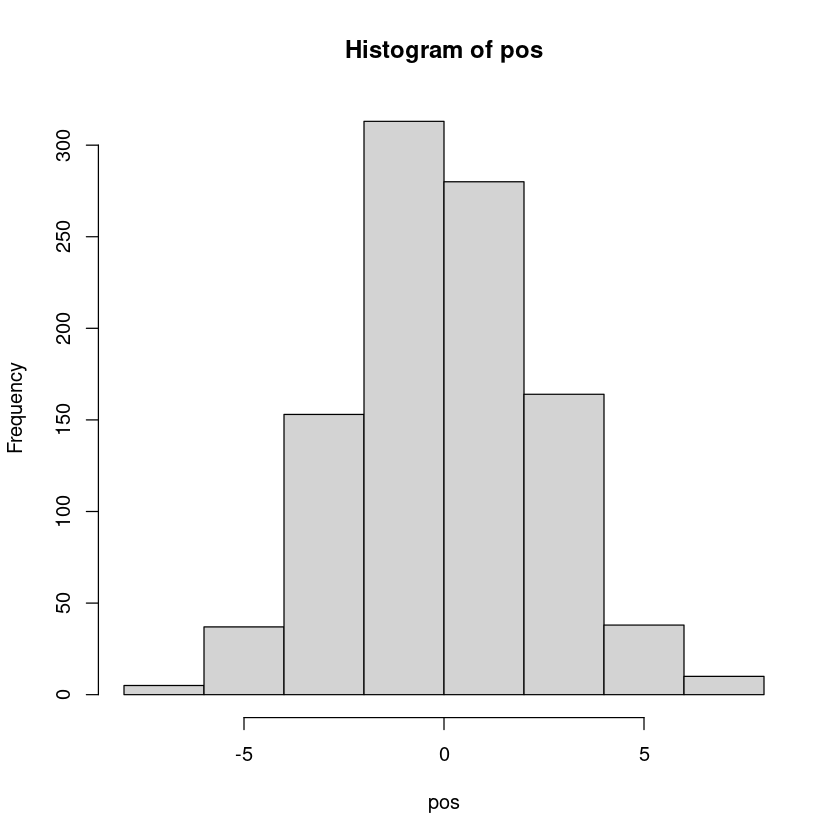

In [2]:
hist(pos)

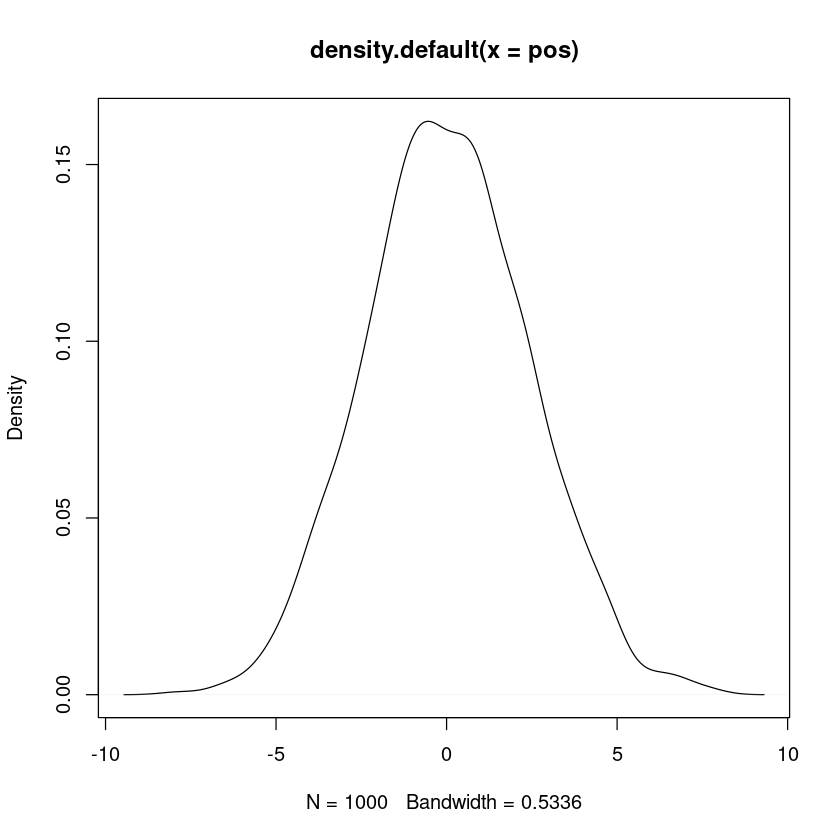

In [3]:
plot(density(pos))

The fact that this looks normal is not surprising - if you take basically any distribution and add together a bunch of different variables from that distribution, then the distribution that you get is normal (some sort of limit theorem).

### Normal by multiplication
Here's another way to get a normal distribution. Say an organism's height is influenced by lots of alleles, and that they interact so that their effects are multiplicative rather than additive. We can simulate this as follows:

Loading required package: rstan

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.21.3, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Loading required package: cmdstanr

This is cmdstanr version 0.5.0

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- Use set_cmdstan_path() to set the path to CmdStan

- Use install_cmdstan() to install CmdStan

Loading required package: parallel

rethinking (Version 2.21)


Attaching package: ‘rethinking’


The following object is masked from ‘package:rstan’:

    stan


The following object is masked from ‘package:stats’:

    rstudent




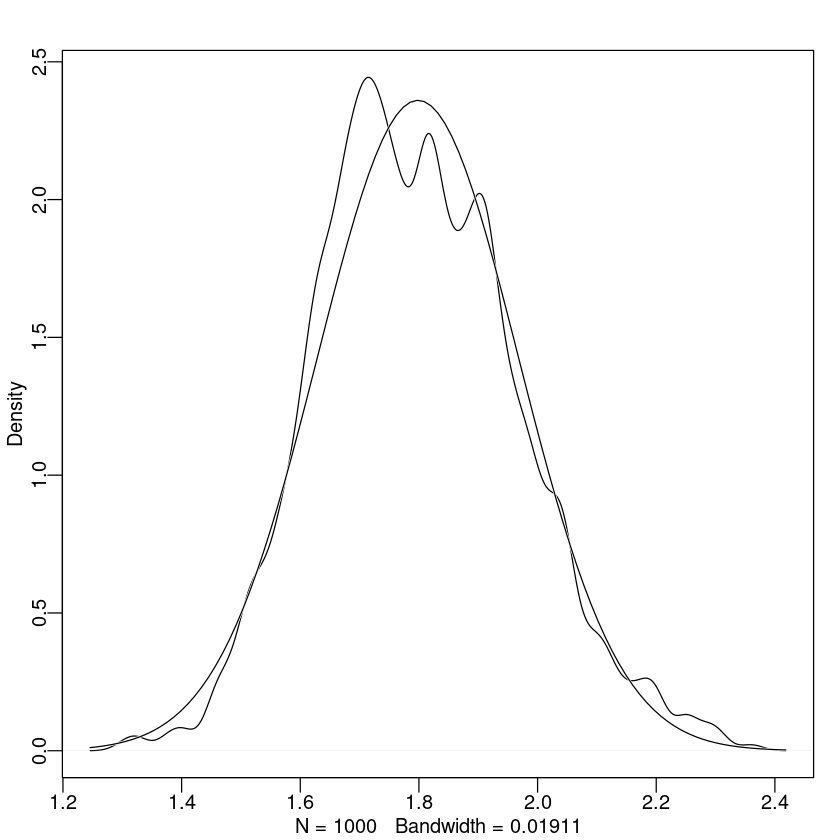

In [4]:
library(rethinking)
growth <- replicate(1000, prod(1 + runif(12, 0, 0.1)))
dens(growth, norm.comp=T)

This works because for small numbers, multiplication is almost the same as addition:
$$
1.1 * 1.1 = (1 + 0.1)(1 + 0.1) = 1 + 0.2 + 0.1 * 0.1 \approx 1.2 = 1 + (0.1 + 0.1)
$$

### Normal by log-multiplication
Of course, the larger the numbers the less the product will converge to a Gaussian. Howether, their *log probabilities* do converge!

log.big <- replicate(1000, log(prod(1 + runif(12, 0, 0.5))))
dens(log.big, norm.comp=T)

This works because taking the log takes multiplication to addition!

### Using Gaussian distributions

The justification for using Gaussians so often is twofold:
1. Ontological
1. Epistemological

**Ontological**

This argument is that the world is full of Gaussian distributions. Almost everything that we measure will be influenced by lots of little bumps, and these tend to produce Gaussians.

**Epistemological**

This argument is that often, we will only know the mean and variance of a distribution for the items that we are interested in. When that is the case, then the Gaussian is the _maximum entropy distribution_. The choice of any other distribution would imply that we have additional knowledge.

One note to be careful of: the Gaussian has very thin tails - most of the density is within one sd of the mean. Many natural processes have comparatively fat tails, which means that modelling them with Gaussians will result in an underestimate of the risk of extreme events.
See: the 2008 financial crisis.

The pdf of the Gaussian is given by 

$$
p(x|\mu, \sigma) = \frac{1}{\sqrt{2\pi \sigma^2}}e^{-\frac{(x - \mu)^2}{2\sigma^2}}
$$

This can be reparameterixed in terms of the *precision* $\tau = \frac{1}{\sigma^2}$. Simply substituting this in gives:
$$
p(x|\mu, \tau) = \frac{\tau}{\sqrt{2\pi}}e^{-\frac{\tau(x - \mu)^2}{2}}
$$

Certain Bayesian model-fitting software requires the distribution to be in this form.

## A language for describing models

Here's a general language / approach to describing statistical models:
1. Recognize a set of variables to work with Some of the variables are observable: we call these `data`. Others are unobservable things like rate or averages: we call these `parameters`.
1. We define each variable in terms of other variables,  or in terms of a probability distribution
1. The combination of variables and their probability distributions defines a _joint generative model_ that can be used both to simulate hypothetical observations as well as analyze real ones.

This approach applies to models in any field - the difficulty is in deciding which variables are important and how they should be connected - not in the mathematics itself.

Once all of these decisions have been made, we write down the model, something like this:
$$
\begin{align*}
y_1 &\sim \text{Normal($\mu_i$, $\sigma$)} \\
\mu_i &= \beta x_i \\
\beta &\sim \text{Normal(0, 10)} \\
\sigma &\sim \text{Exponential(1)} \\
x_i &\sim \text{Normal(0, 1)}\\
\end{align*}
$$

### Re-describing the globe-tossing model

Our globe-tossing model can be re-written in that form:
$$
\begin{align*}
W &\sim \text{Binomial($N$, $p$)} \\
p &\sim \text{Uniform(0, 1)}\\
\end{align*}
$$

We can read this as

> The count $W$ is distributed binomially with sample size $N$ and probability $p$. The prior for $p$ is assumed to be uniform between zero and 1.

In simple models like these, the first line defines the likelihood function for Bayes' Theorem. The other lines define priors. Both of the lines in this model are _stochastic_, as indicated by the $\sim$ symbol. A stochastic relationship is just a mapping of a variable or parameter onto a distribution. It is _stochastic_ because no single instance of the variable is known - instead, it will take on values from the distribution.

## Gaussian model of height

let's build a linear regression model. For the moment, we want a single measurement variable to model as a Gaussian distribution. There will be two parameters, the mean $\mu$ and the sd $\sigma$. Then we'll update the values of $\mu$ and $\sigma$ as the data comes in.

### The data

The data we'll work with is part of the census data for the Dobe area !Kung San, compiled by interviews by Nancy Howell in the 1960s.

In [5]:
data(Howell1)
d <- Howell1
head(d)

,height,weight,age,male
,<dbl>,<dbl>,<dbl>,<int>
1,151.765,47.82561,63,1
2,139.700,36.48581,63,0
3,136.525,31.86484,65,0
4,156.845,53.04191,41,1
5,145.415,41.27687,51,0
6,163.830,62.99259,35,1


In [6]:
# We can also examine the shape 
str(d)

'data.frame':	544 obs. of  4 variables:
 $ height: num  152 140 137 157 145 ...
 $ weight: num  47.8 36.5 31.9 53 41.3 ...
 $ age   : num  63 63 65 41 51 35 32 27 19 54 ...
 $ male  : int  1 0 0 1 0 1 0 1 0 1 ...


In [7]:
# we can also use the `precis` function from `rethinking`
precis(d)

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
height,138.2635963,27.6024476,81.108550,165.73500,▁▁▁▁▁▁▁▂▁▇▇▅▁
weight,35.6106176,14.7191782,9.360721,54.50289,▁▂▃▂▂▂▂▅▇▇▃▂▁
age,29.3443934,20.7468882,1.000000,66.13500,▇▅▅▃▅▂▂▁▁
male,0.4724265,0.4996986,0.000000,1.00000,▇▁▁▁▁▁▁▁▁▇


In [8]:
# We can access just the height column as a vector:
d$height

[1] 151.7650 139.7000 136.5250 156.8450 145.4150 163.8300 149.2250 168.9100
  [9] 147.9550 165.1000 154.3050 151.1300 144.7800 149.9000 150.4950 163.1950
 [17] 157.4800 143.9418 121.9200 105.4100  86.3600 161.2900 156.2100 129.5400
 [25] 109.2200 146.4000 148.5900 147.3200 137.1600 125.7300 114.3000 147.9550
 [33] 161.9250 146.0500 146.0500 152.7048 142.8750 142.8750 147.9550 160.6550
 [41] 151.7650 162.8648 171.4500 147.3200 147.9550 144.7800 121.9200 128.9050
 [49]  97.7900 154.3050 143.5100 146.7000 157.4800 127.0000 110.4900  97.7900
 [57] 165.7350 152.4000 141.6050 158.8000 155.5750 164.4650 151.7650 161.2900
 [65] 154.3050 145.4150 145.4150 152.4000 163.8300 144.1450 129.5400 129.5400
 [73] 153.6700 142.8750 146.0500 167.0050 158.4198  91.4400 165.7350 149.8600
 [81] 147.9550 137.7950 154.9400 160.9598 161.9250 147.9550 113.6650 159.3850
 [89] 148.5900 136.5250 158.1150 144.7800 156.8450 179.0700 118.7450 170.1800
 [97] 146.0500 147.3200 113.0300 162.5600 133.9850 152.4000 160.0200 149.8600
[105] 142.8750 167.0050 159.3850 154.9400 148.5900 111.1250 111.7600 162.5600
[113] 152.4000 124.4600 111.7600  86.3600 170.1800 146.0500 159.3850 151.1300
[121] 160.6550 169.5450 158.7500  74.2950 149.8600 153.0350  96.5200 161.9250
[129] 162.5600 149.2250 116.8400 100.0760 163.1950 161.9250 145.4150 163.1950
[137] 151.1300 150.4950 141.6050 170.8150  91.4400 157.4800 152.4000 149.2250
[145] 129.5400 147.3200 145.4150 121.9200 113.6650 157.4800 154.3050 120.6500
[153] 115.6000 167.0050 142.8750 152.4000  96.5200 160.0000 159.3850 149.8600
[161] 160.6550 160.6550 149.2250 125.0950 140.9700 154.9400 141.6050 160.0200
[169] 150.1648 155.5750 103.5050  94.6150 156.2100 153.0350 167.0050 149.8600
[177] 147.9550 159.3850 161.9250 155.5750 159.3850 146.6850 172.7200 166.3700
[185] 141.6050 142.8750 133.3500 127.6350 119.3800 151.7650 156.8450 148.5900
[193] 157.4800 149.8600 147.9550 102.2350 153.0350 160.6550 149.2250 114.3000
[201] 100.9650 138.4300  91.4400 162.5600 149.2250 158.7500 149.8600 158.1150
[209] 156.2100 148.5900 143.5100 154.3050 131.4450 157.4800 157.4800 154.3050
[217] 107.9500 168.2750 145.4150 147.9550 100.9650 113.0300 149.2250 154.9400
[225] 162.5600 156.8450 123.1900 161.0106 144.7800 143.5100 149.2250 110.4900
[233] 149.8600 165.7350 144.1450 157.4800 154.3050 163.8300 156.2100 153.6700
[241] 134.6200 144.1450 114.3000 162.5600 146.0500 120.6500 154.9400 144.7800
[249] 106.6800 146.6850 152.4000 163.8300 165.7350 156.2100 152.4000 140.3350
[257] 158.1150 163.1950 151.1300 171.1198 149.8600 163.8300 141.6050  93.9800
[265] 149.2250 105.4100 146.0500 161.2900 162.5600 145.4150 145.4150 170.8150
[273] 127.0000 159.3850 159.4000 153.6700 160.0200 150.4950 149.2250 127.0000
[281] 142.8750 142.1130 147.3200 162.5600 164.4650 160.0200 153.6700 167.0050
[289] 151.1300 147.9550 125.3998 111.1250 153.0350 139.0650 152.4000 154.9400
[297] 147.9550 143.5100 117.9830 144.1450  92.7100 147.9550 155.5750 150.4950
[305] 155.5750 154.3050 130.6068 101.6000 157.4800 168.9100 150.4950 111.7600
[313] 160.0200 167.6400 144.1450 145.4150 160.0200 147.3200 164.4650 153.0350
[321] 149.2250 160.0200 149.2250  85.0900  84.4550  59.6138  92.7100 111.1250
[329]  90.8050 153.6700  99.6950  62.4840  81.9150  96.5200  80.0100 150.4950
[337] 151.7650 140.6398  88.2650 158.1150 149.2250 151.7650 154.9400 123.8250
[345] 104.1400 161.2900 148.5900  97.1550  93.3450 160.6550 157.4800 167.0050
[353] 157.4800  91.4400  60.4520 137.1600 152.4000 152.4000  81.2800 109.2200
[361]  71.1200  89.2048  67.3100  85.0900  69.8500 161.9250 152.4000  88.9000
[369]  90.1700  71.7550  83.8200 159.3850 142.2400 142.2400 168.9100 123.1900
[377]  74.9300  74.2950  90.8050 160.0200  67.9450 135.8900 158.1150  85.0900
[385]  93.3450 152.4000 155.5750 154.3050 156.8450 120.0150 114.3000  83.8200
[393] 156.2100 137.1600 114.3000  93.9800 168.2750 147.9550 139.7000 157.4800
[401]  76.2000  66.0400 160.7000 114.3000 146.0500 161.2900  69.8500 133.9850
[409]  67.9450 150.4950 

In [9]:
# We'll just be working with adults (since there is a strong correlation between age and height 
# which will swamp out the relationship we are looking for between between the height and weight)
d2 <- d[d$age >= 18,]
head(d2)

,height,weight,age,male
,<dbl>,<dbl>,<dbl>,<int>
1,151.765,47.82561,63,1
2,139.700,36.48581,63,0
3,136.525,31.86484,65,0
4,156.845,53.04191,41,1
5,145.415,41.27687,51,0
6,163.830,62.99259,35,1


recall that to access the elements of a dataframe, you use `d[row, col]`. 

### The model

Let's look at the density:

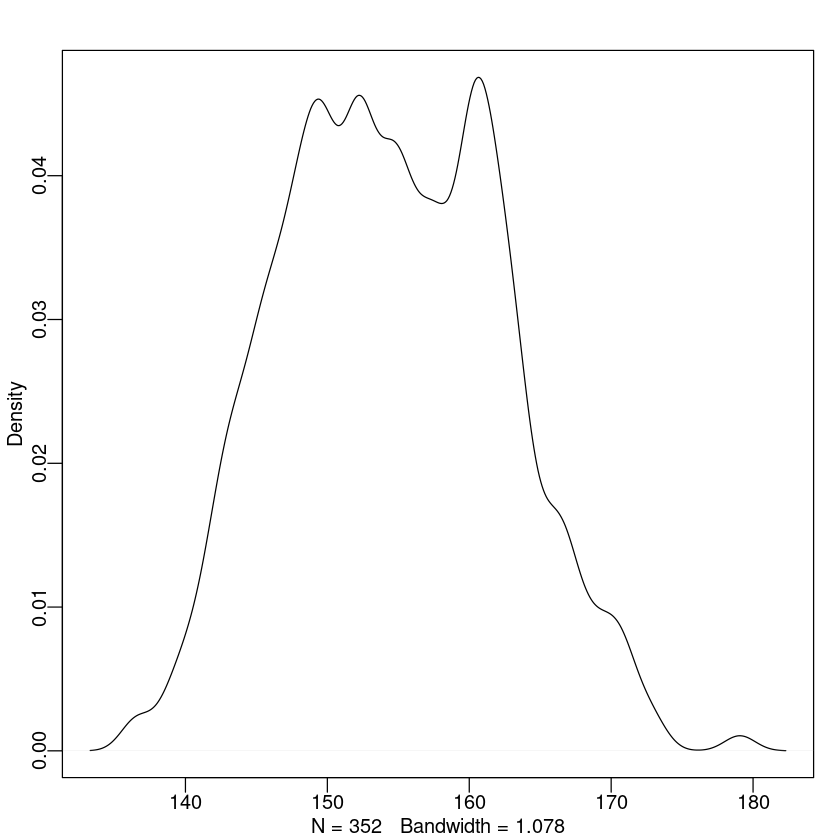

In [10]:
dens(d2$height)

So it looks like this could be apporimately normally distributed, so it seems reasonable to model it that way.

$$
h_i \sim \text{Normal}(\mu,\ \sigma)
$$

Of course, we also need to do something with the parameters $\mu$ and $\sigma$. Let's assign some priors:
$$
\begin{align*}
h_i &\sim \text{Normal}(\mu,\ \sigma) \\
\mu &\sim \text{Normal}(178,\ 20) \\
\sigma &\sim \text{Uniform}(0,\ 50) \\
\end{align*}
$$

Where did these values come from? Well, the author of the textbook is 178cm tall, and the range 138 -- 218 ($\pm 2\sigma$) encompasses the plausible range of human heights. Here, we see that we actually need some domain knowledge to come up with the prior.

Let's plot the priors to get an idea of what the model is starting out with:

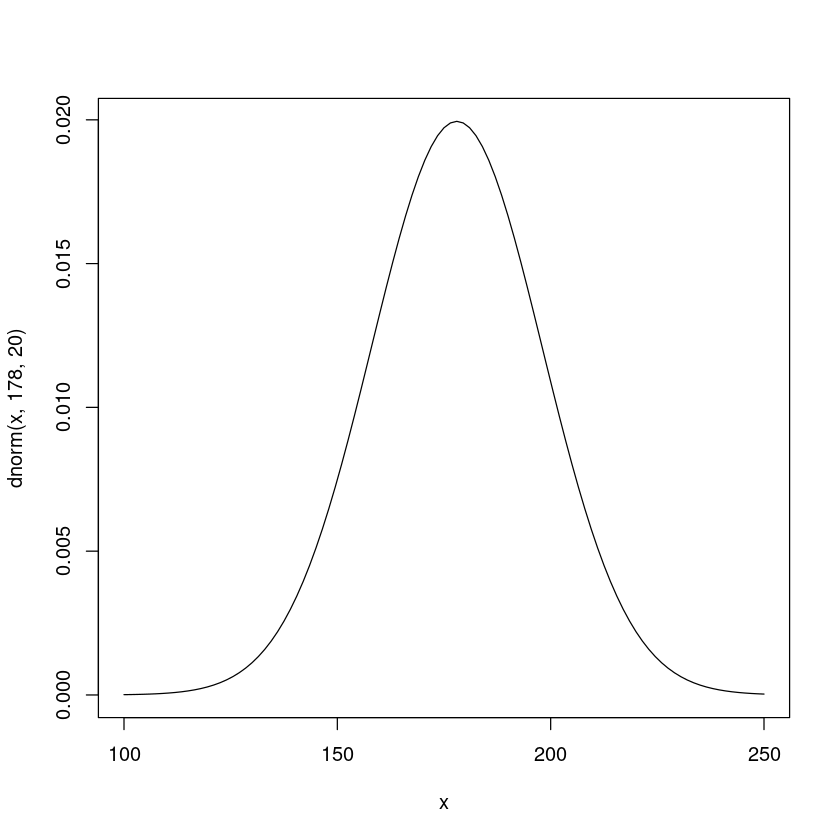

In [11]:
curve(dnorm(x, 178, 20), from=100, to=250)

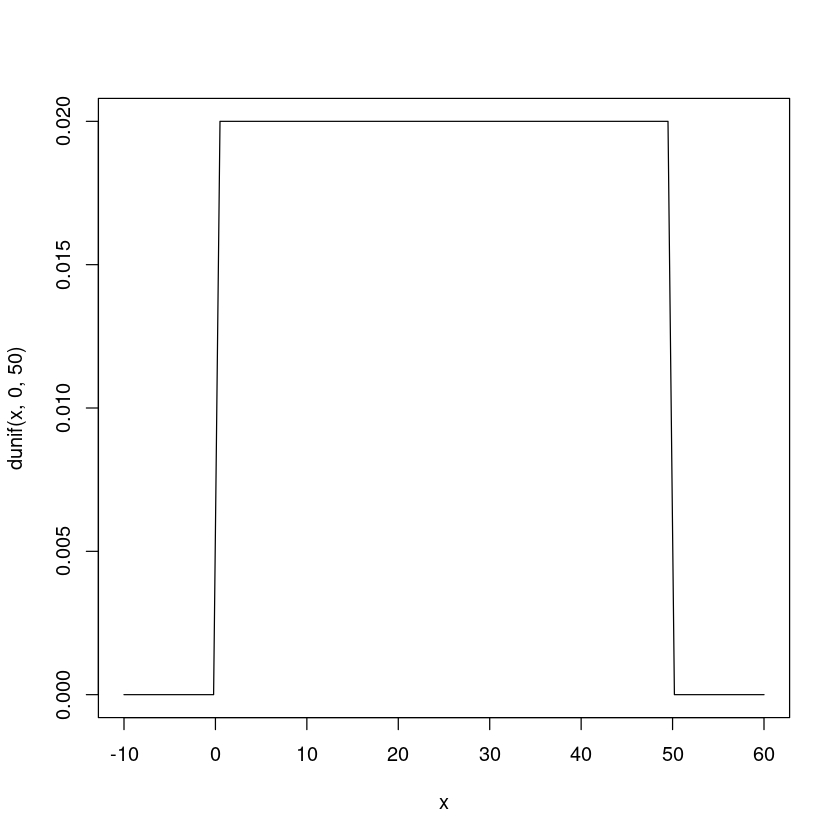

In [12]:
curve(dunif(x, 0, 50), from=-10, to=60)

Now let's do a _prior prdeictive check_ --- that is, let's see what predictions our priors make:

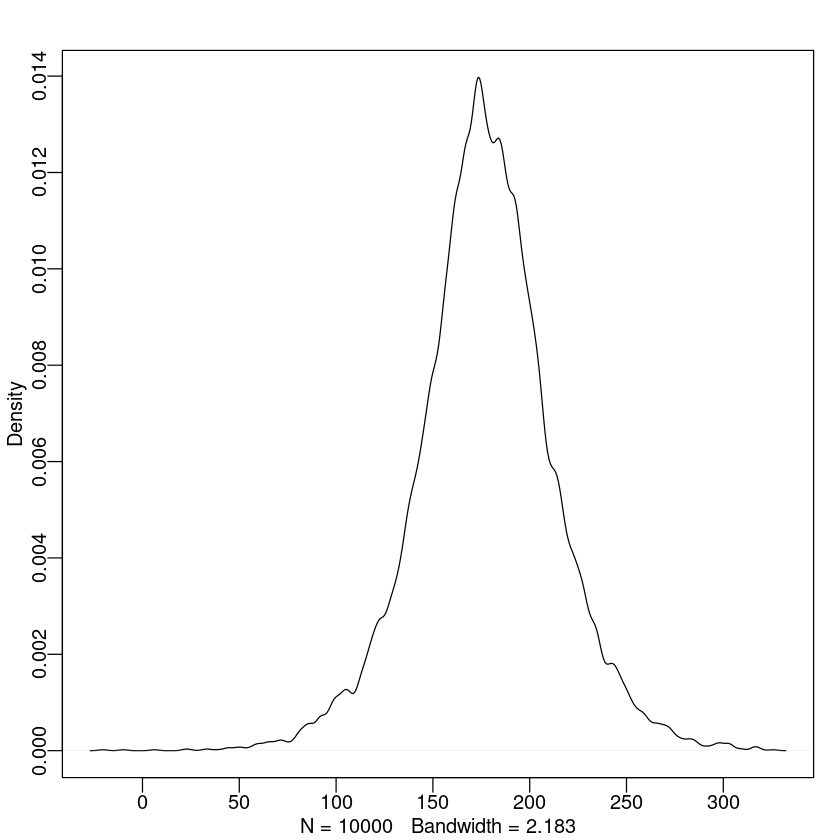

In [13]:
sample_mu <- rnorm(1e4, 178, 20)
sample_sigma <- runif(1e4, 0, 50)
prior_h <- rnorm(1e4, sample_mu, sample_sigma)
dens(prior_h)

Looking at this, we can see that our priors include predictions with quite fat tails: we would be very surprised to see someone 300cm tall, but here there is a surprisingly high likelihood. We should be careful about making our priors too uninformative --- sometimes it can lead to physically impossible results. For instance, let's see what happens if we use a less informative prior for the heights.

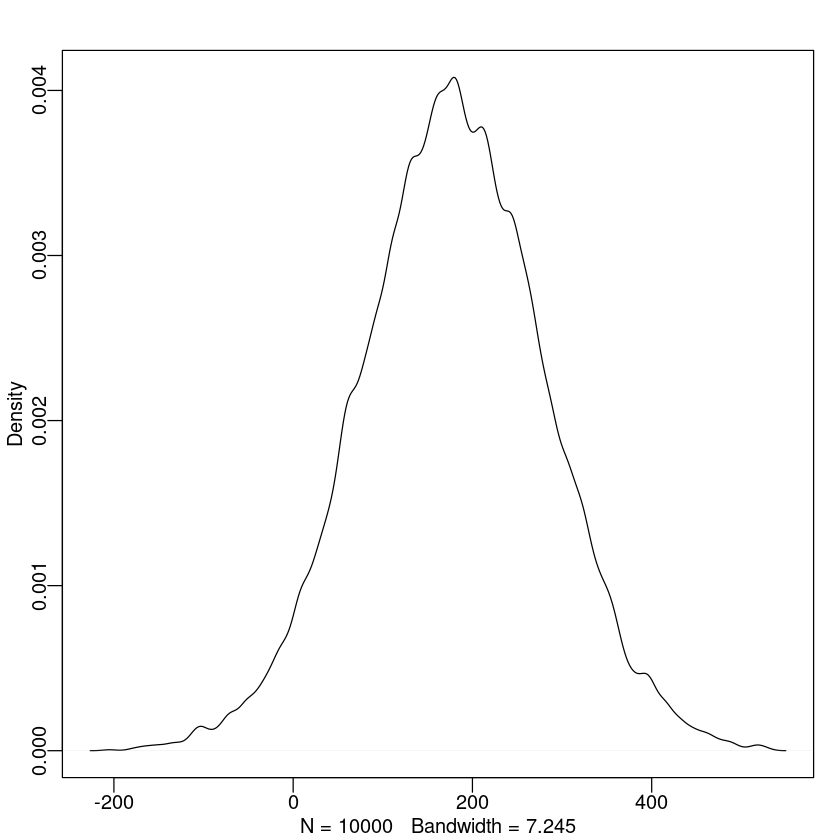

In [14]:
sample_mu <- rnorm(1e4, 178, 100)
sample_sigma <- runif(1e4, 0, 50)
prior_h <- rnorm(1e4, sample_mu, sample_sigma)
dens(prior_h)

Here we see that lots of people are expected to have negative height, and others are much taller than the height of the tallest person ever recorded (272cm). Here we have lots of data, so having silly priors isn't that damaging, but that won't always be the case.

### Grid approximation of the posterior distribution

Here's a way to do this with a grid approximation!

In [15]:
mu.list <- seq(from=150, to=160, length.out=100)
sigma.list <- seq(from=7, to=9, length.out=100)
post <- expand.grid(mu=mu.list, sigma=sigma.list)
post$LL <- sapply(1:nrow(post), function(i)
    sum(
        dnorm(d2$height, post$mu[i], post$sigma[i], log=TRUE)
    )
)
post$prod <- post$LL + dnorm(post$mu, 178, 20, TRUE) + dunif(post$sigma, 0, 50, TRUE)
post$prob <- exp(post$prod - max(post$prod))

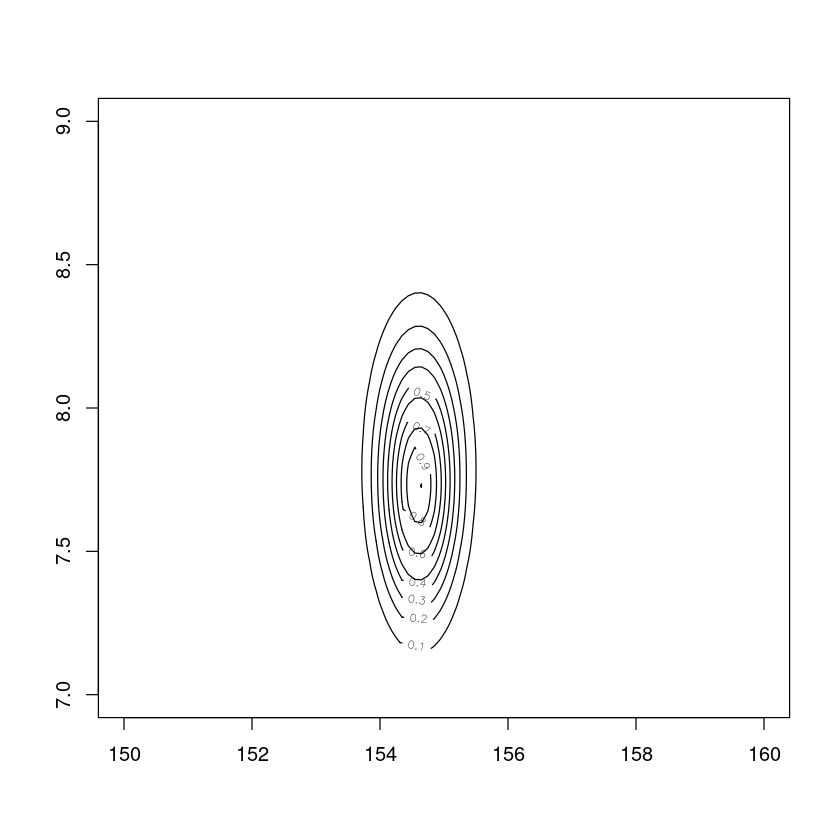

In [16]:
contour_xyz(post$mu, post$sigma, post$prob)

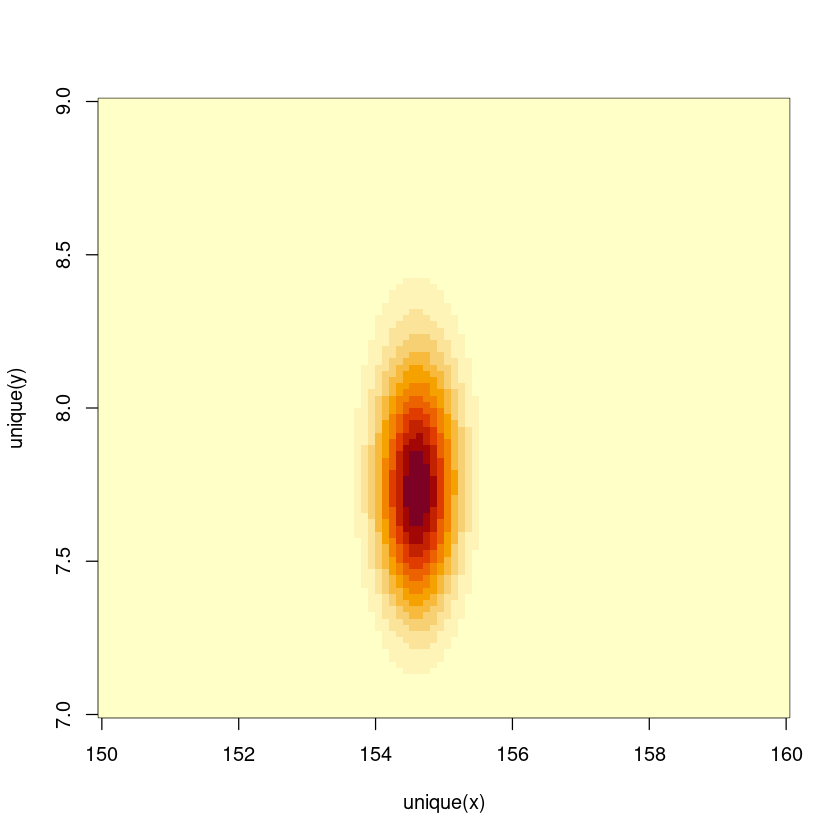

In [17]:
image_xyz(post$mu, post$sigma, post$prob)

### Sampling from the posterior

Of course, we can also use the very general method of sampling from the distribution. The trick is that here we are sampling from the rows in proportion to the likelihood of that row occurring:

In [18]:
sample.rows <- sample(1:nrow(post), size=1e4, replace=TRUE, prob=post$prob)
sample.mu <- post$mu[sample.rows]
sample.sigma <- post$sigma[sample.rows]

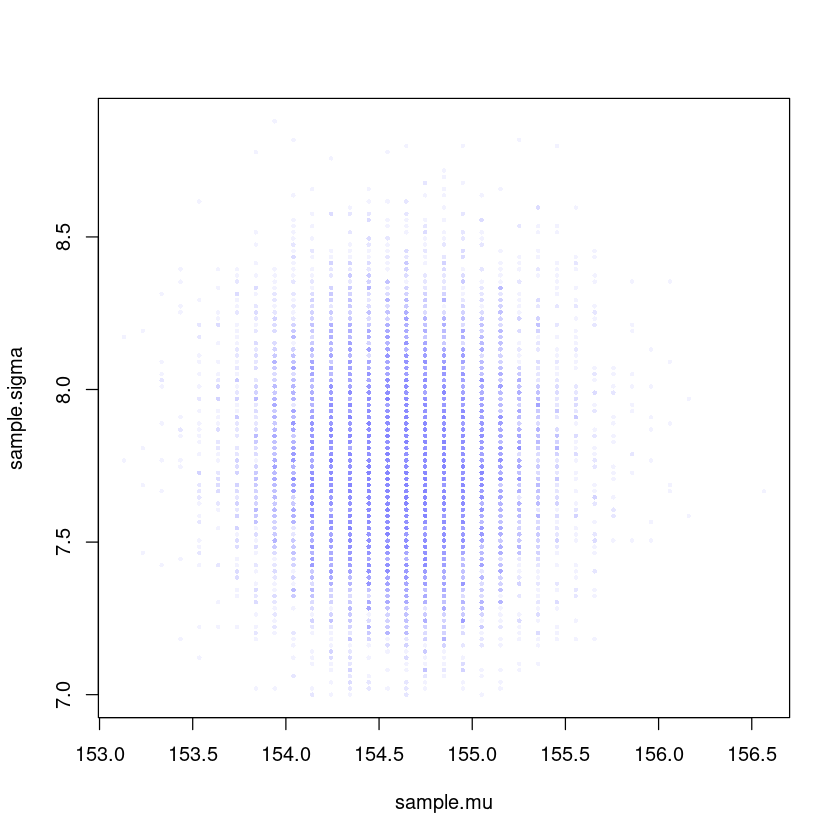

In [19]:
plot(sample.mu, sample.sigma, cex=0.5, pch=16, col=col.alpha(rangi2,0.1))

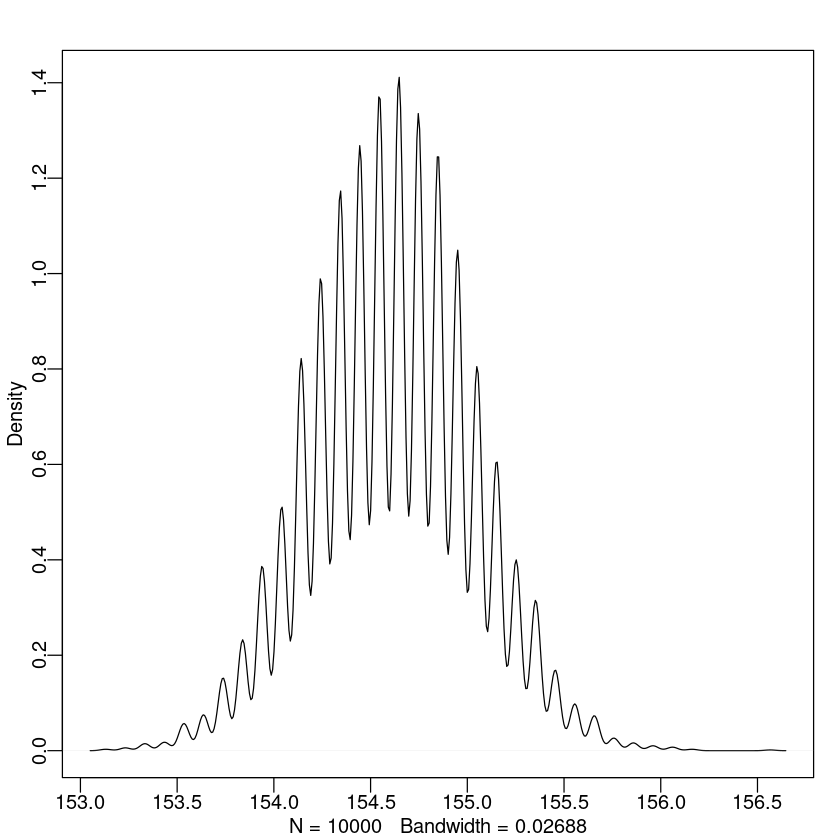

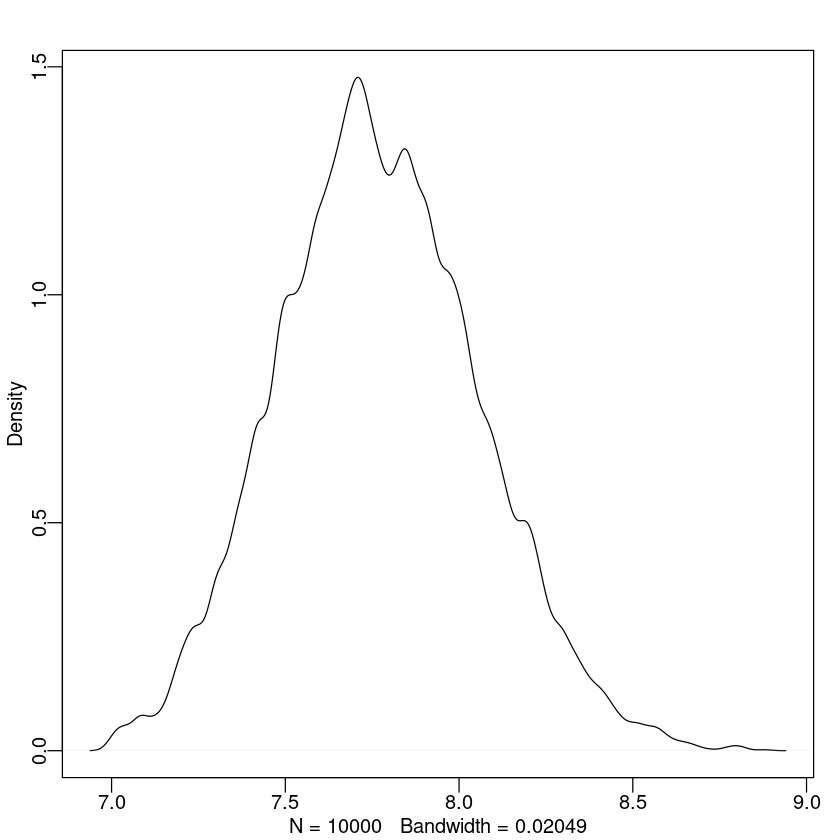

In [20]:
# Now the marginal distributions for mu and sigma
dens(sample.mu)
dens(sample.sigma)

In [21]:
# Posterior compatibility intervals
PI(sample.mu)
PI(sample.sigma)

5%      94% 
153.9394 155.2525

5%      94% 
7.323232 8.232323

### Finding the posterior distribution with `quap`

Now we'll abandon the grid approximation and use a *quadratic approximation* instead.

The `quap` function from the `rethinking` library uses the model definition we used earlier.

In [22]:
d <- Howell1
d2 <- d[d$age >= 18,]

# now we write the model as an alist
flist <- alist(
    height ~ dnorm(mu, sigma),
    mu ~ dnorm(178, 20),
    sigma ~ dunif(0, 50)
)

# fit the model to the data
m4.1 <- quap(flist, data=d2)

In [23]:
precis(m4.1)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
mu,154.607023,0.4119947,153.948576,155.265471
sigma,7.731333,0.2913860,7.265642,8.197024


The priors that we used were very weak; let's see what happens when we use a more informative prior for $\mu$:

In [24]:
m4.2 <- quap(
    alist(
        height ~ dnorm(mu, sigma),
        mu ~ dnorm(178, 0.1),
        sigma ~ dunif(0, 50)
    ),
    data=d2,
)
precis(m4.2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
mu,177.86375,0.1002354,177.70356,178.02395
sigma,24.51756,0.9289235,23.03297,26.00216


We used a very strong prior, so $mu$ has barely changed from the prior. However, $\sigma$ has changed! This is because the certainty about $mu$ changes the values for $\sigma$.

### Sampling from `quap`
The above explains how to use `quap` to get the quadratic approximation, but we'd also like to sample from it. How do we do this?

In [25]:
# Get the variance / covariance matrix for the resulting distribution:
vcov(m4.1)

,mu,sigma
mu,0.1697395929,0.0002180298
sigma,0.0002180298,0.0849058006


We can decompose it into two elements:
1. A vector of variances for the parameters, and
1. A correlation matrix that tells us how changes in any parameter lead to correlated changes in the others.

In [26]:
diag(vcov(m4.1))
cov2cor(vcov(m4.1))

mu     sigma 
0.1697396 0.0849058

,mu,sigma
mu,1.000000000,0.001816167
sigma,0.001816167,1.000000000


Notice that the covariances are near 0 - this tells us that for this simple model, $\sigma$ and $\mu$ are close to independent.

In [27]:
# use the extract.samples function from rethinking to grab values:
post <- extract.samples(m4.1, n=1e4)
head(post)

,mu,sigma
,<dbl>,<dbl>
1,154.8004,7.426072
2,154.0160,8.084437
3,154.5143,7.600915
4,154.7694,7.485661
5,154.4182,7.686298
6,154.1857,7.604763


In [28]:
# These values should be close to the values from before:
precis(post)

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
mu,154.610070,0.4130550,153.957270,155.26536,▁▁▁▅▇▂▁▁
sigma,7.732029,0.2946993,7.257321,8.20631,▁▁▁▂▅▇▇▃▁▁▁


## Linear prediction

We now have a model of the heights in a population of adults. Typically, we are interested in modeling how an outcome is related to some other variable, a *predictor variable*. If the predictor variable has any statistical association with the outcome variable, then we can use it to predict the outcome.

So now let's look at how the height covaries with weight.

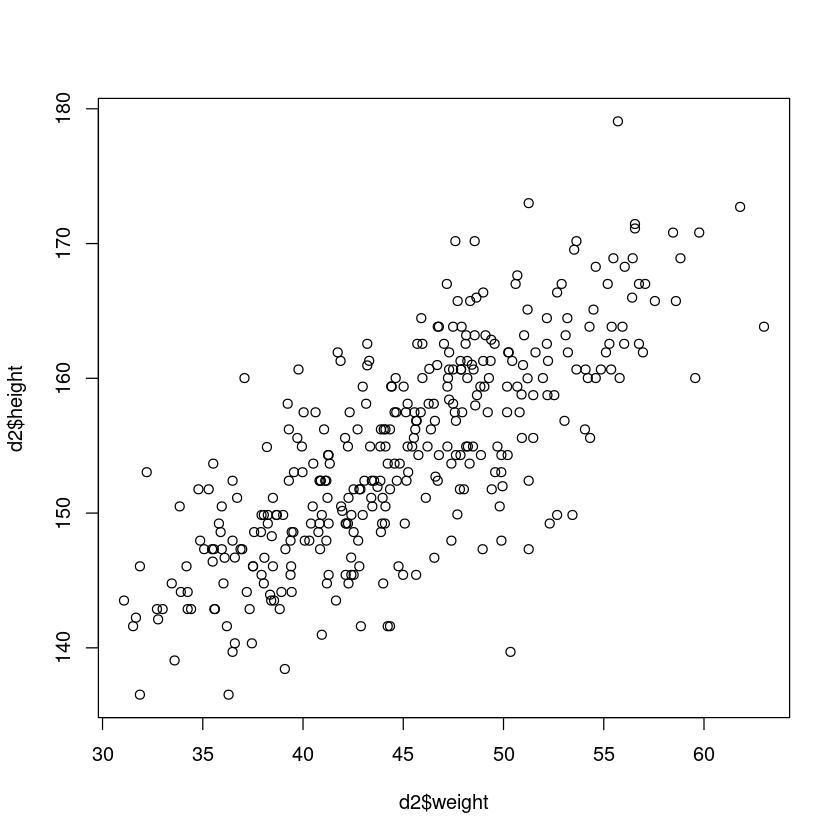

In [29]:
data(Howell1); d <- Howell1; d2 <- d[d$age >= 18,]
plot(d2$height ~ d2$weight)

Looking at this, it seems clear that there is some sort of relationship! But how do we take the next step to incorporate what we know about about model so that it can make predictions?

### The linear model strategy

The strategy is to make the parameter for the mean of a Gaussian distribution, $\mu$, into a linear function of the predictor variable and other, new parameters that we invent. This strategy is often called the *linear model*.

Let $x$ be the name for the column of weight measurements. Then our new model for predicting height as a function of weight is:

$$
\begin{align*}
h_i &\sim \text{Normal}(\mu_i, \sigma) & \text{[likelihood]} \\
\mu_i &= \alpha + \beta(x_i - \bar{x}) & \text{[linear model]} \\
\alpha &\sim \text{Normal}(178, 20) \\
\beta &\sim \text{Normal(0, 10)} \\
\sigma &\sim \text{Uniform}(0, 50) \\
\end{align*}
$$

#### Probability of the data

Notice that now, each height depends on its own particular $\mu_i$, which in turn depends on the particular $x_i$.

#### Linear model

This means that now $\mu_i$ is no longer a parameter to be estimated, but is now constructed from the other parameters, particularly $\alpha$ and $\beta$. Notice that this is not a stochastic relationship - $=$ rather than $\sim$. The parameters $\alpha$ and $\beta$ are ones that we made up to control how the mean $\mu_i$ can vary across the data.

In order to understand our priors, let's simulate values from them:

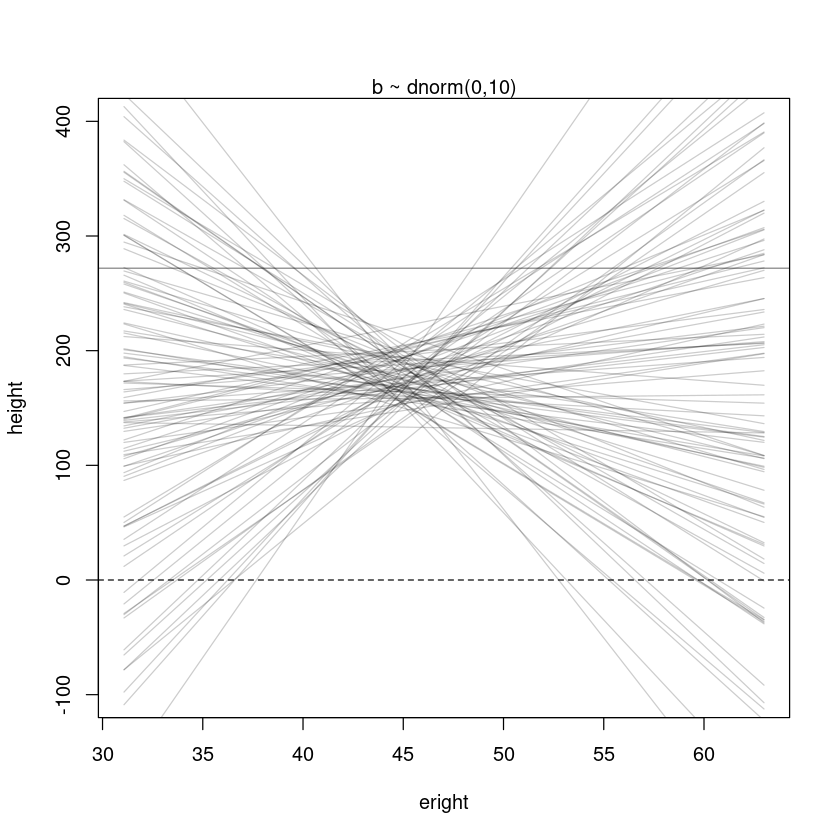

In [30]:
set.seed(2971)

# simulating 100 lines drawn from the prior
N <- 100
a <- rnorm(N, 178, 20)
b <- rnorm(N, 0, 10)

# Now plot all 100 lines
plot(NULL, xlim=range(d2$weight), ylim=c(-100, 400),
     xlab="eright", ylab="height",
    )
abline(h=0, lty=2)
abline(h=272, lty=1, lwd=0.5)
mtext("b ~ dnorm(0,10)")
xbar <- mean(d2$weight)
for ( i in 1:N ) {
    curve(a[i] + b[i] * (x - xbar),
          from=min(d2$weight),
          to=max(d2$weight),
          add=T,
          col=col.alpha("black", 0.2),
      )
}

Notice that this is not really believable - the line at 272 is the world's tallest person, and anything below zero seems$\dots$ unlikely. We can definitely do better!

First thing: we expect that the relationship between weight and height to be positive. One way to do that is to ensure that the slope parameter $\beta$ is positive by drawing it from a Log-Normal distribution. Basically, this would mean that the log of that values of $\beta$ would be normally distributed. For our model:
$$
\beta \sim \text{Log-Normal}(0,1)
$$

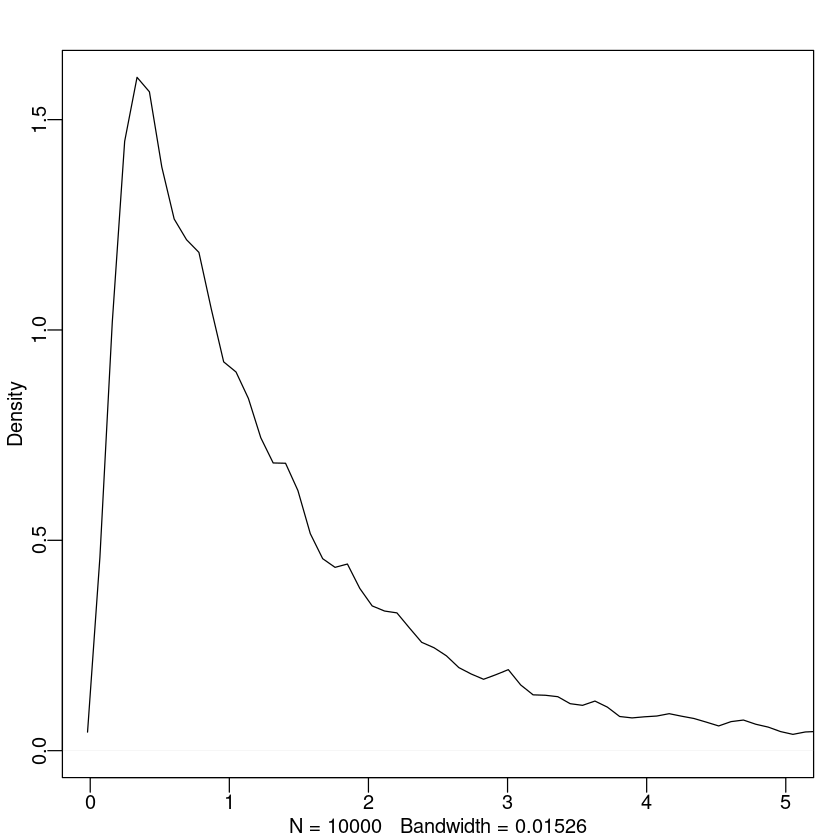

In [31]:
b <- rlnorm(1e4,0,1)
dens(b, xlim=c(0,5), adj=0.1)

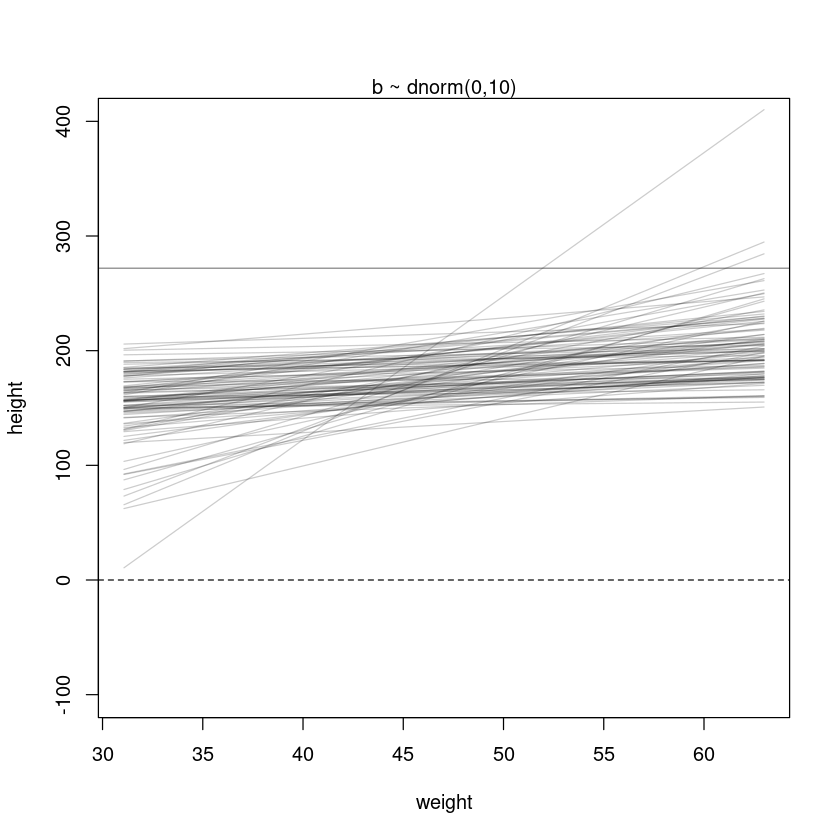

In [32]:
# now let's see what happens to our prior predictions
set.seed(2971)

# simulating 100 lines drawn from the prior
N <- 100
a <- rnorm(N, 178, 20)
# we changed this to a log-normal prior and changed the sigma from 10 to 1
b <- rlnorm(N, 0, 1)

# Now plot all 100 lines
plot(NULL, xlim=range(d2$weight), ylim=c(-100, 400),
     xlab="weight", ylab="height",
    )
abline(h=0, lty=2)
abline(h=272, lty=1, lwd=0.5)
mtext("b ~ dnorm(0,10)")
xbar <- mean(d2$weight)
for ( i in 1:N ) {
    curve(a[i] + b[i] * (x - xbar),
          from=min(d2$weight),
          to=max(d2$weight),
          add=T,
          col=col.alpha("black", 0.2),
      )
}

Right away we can see that this is far more credible.

### Finding the posterior distribution

The code to find the posterior is very similar to what we already did.

In [33]:
xbar <- mean(d2$weight)

# fit the model
m4.3 <- quap(
    alist(
        height ~ dnorm(mu, sigma),
        mu <- a + b * (weight - xbar),
        a ~ dnorm(178, 20),
        b ~ dlnorm(0, 1),
        sigma ~ dunif(0, 50)
    ),
    data=d2,
)

### Interpreting the posterior distribution

One trouble with statistical models is that they can be hard to interpret.

There are two broad categories of processing:
1. Reading tables
1. Plotting simulations

For simple models, sometimes you can glean a lot of information from a table of numbers. But as models become more complex, simulations and graphs and whatnot are going to be the way to go. Plotting the predictions of your models can also allow you to inquire about things that are hard to read from tables:
1. Whether or not the model fitting process worked correctly
1. The *absolute* magnitude, rather than the merely *relative* magnitude, of a relationship between outcome and predictor
1. The uncertainty surrounding an average relationship
1. The uncertainty surrounding the implied predictions of the model, as these are distinct from mere parameter uncertainty

In [34]:
precis(m4.3)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,154.6013671,0.27030766,154.1693633,155.0333710
b,0.9032807,0.04192363,0.8362787,0.9702828
sigma,5.0718809,0.19115478,4.7663786,5.3773831


If we look at the value for $b$ ($\beta$), we see that plausible values are around 0.9. We should think of this as saying that according to our model, someone 1kg heavier is expected to be about 0.9cm taller.

In [35]:
round(vcov(m4.3), 3)

,a,b,sigma
a,0.073,0.000,0.000
b,0.000,0.002,0.000
sigma,0.000,0.000,0.037


So we actually see almost no covariance among the different variables.

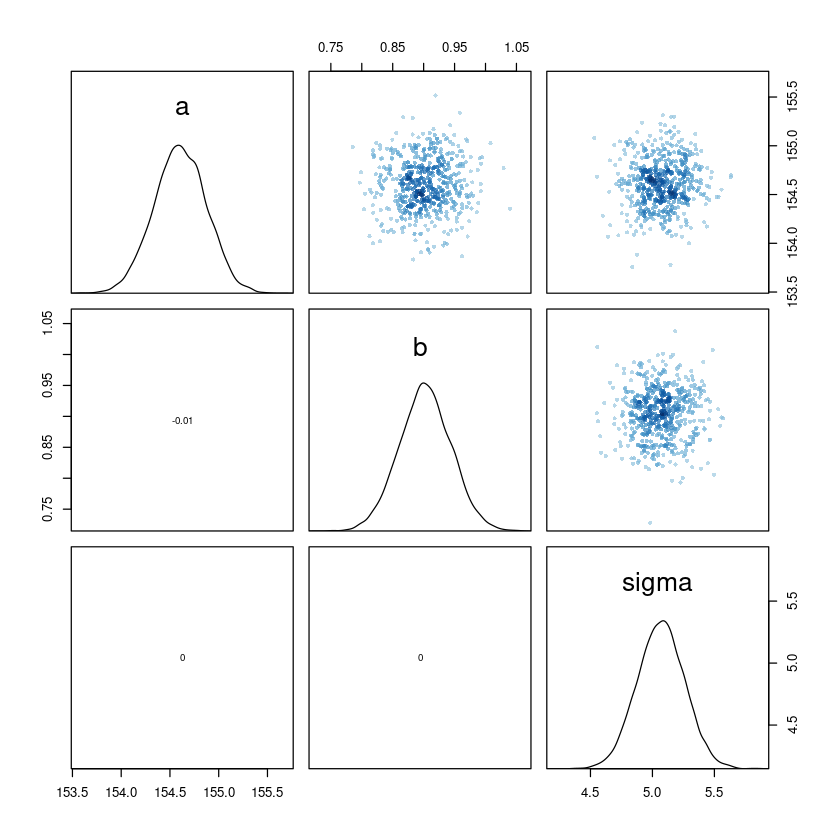

In [36]:
pairs(m4.3)

#### Plotting the posterior inference against the data

It's almost always better to plot the posterior inference against the data. This both helps with interpreting the posterior and can serve as an informal check of model validity.

Let's start with a simple one: the data, and one line

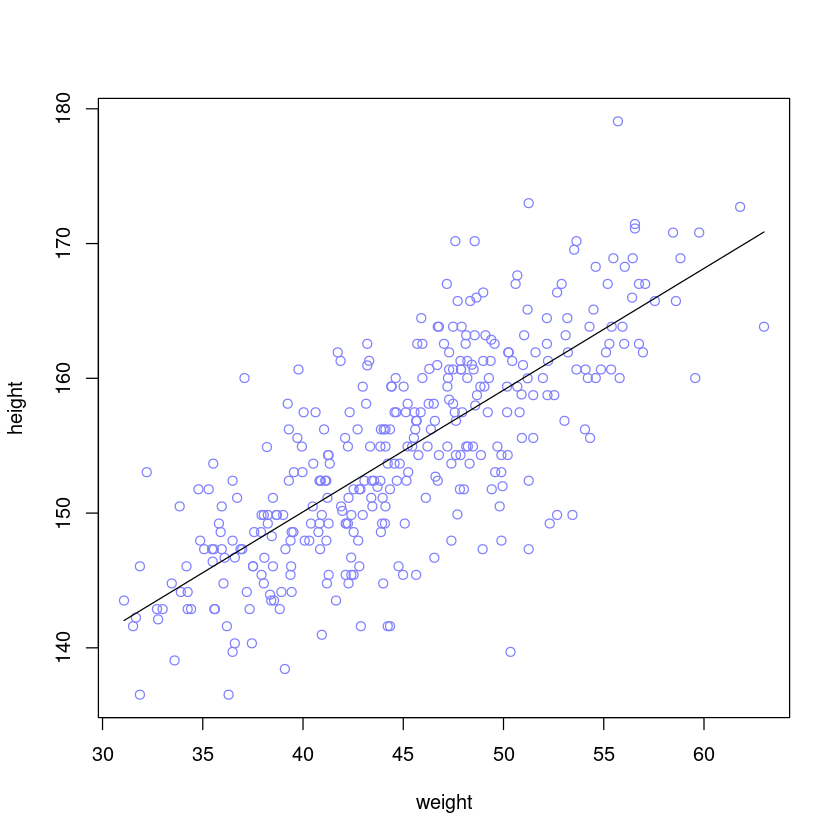

In [37]:
plot(height ~ weight, data=d2, col=rangi2)
post <- extract.samples(m4.3)
a_map <- mean(post$a)
b_map <- mean(post$b)
curve(a_map + b_map * (x - xbar), add=T)

Each point is an individual, and the line here is formed from the mean of $a$ and $b$.

#### Adding uncertainty around the mean

The mean line (the one that we plotted) is really just the single most plausible line. There are lots of other ones as well!

To do this, let's take a look at the samples:

In [38]:
post <- extract.samples(m4.3)
post[1:5,]

,a,b,sigma
,<dbl>,<dbl>,<dbl>
1,154.5789,0.9376825,5.220756
2,154.4067,0.8937310,4.752735
3,154.4622,0.9150822,5.341227
4,154.2649,0.9236067,5.160423
5,155.1258,0.9495934,5.108891


Let's add the uncertainty back in. We'll do this without all of the data, so that we can see the effect of adding more data in has on the level of certainty

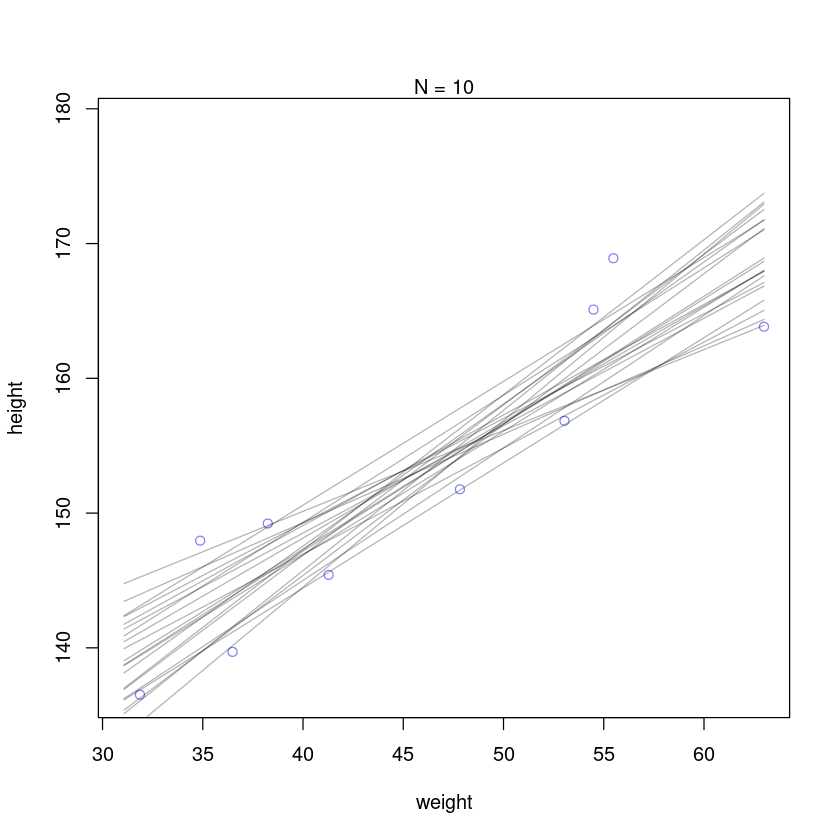

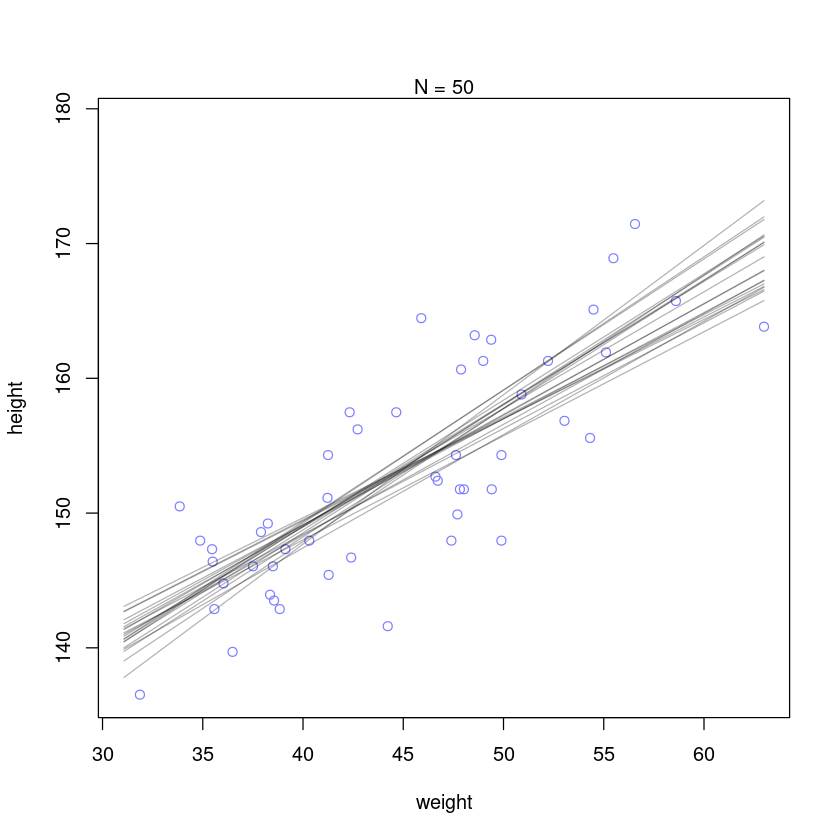

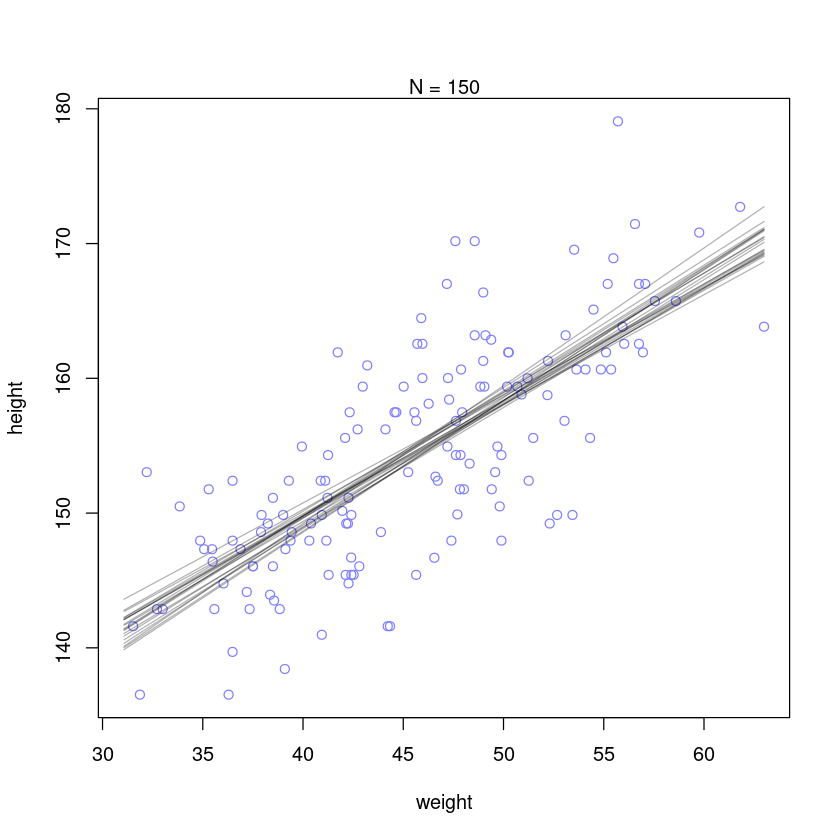

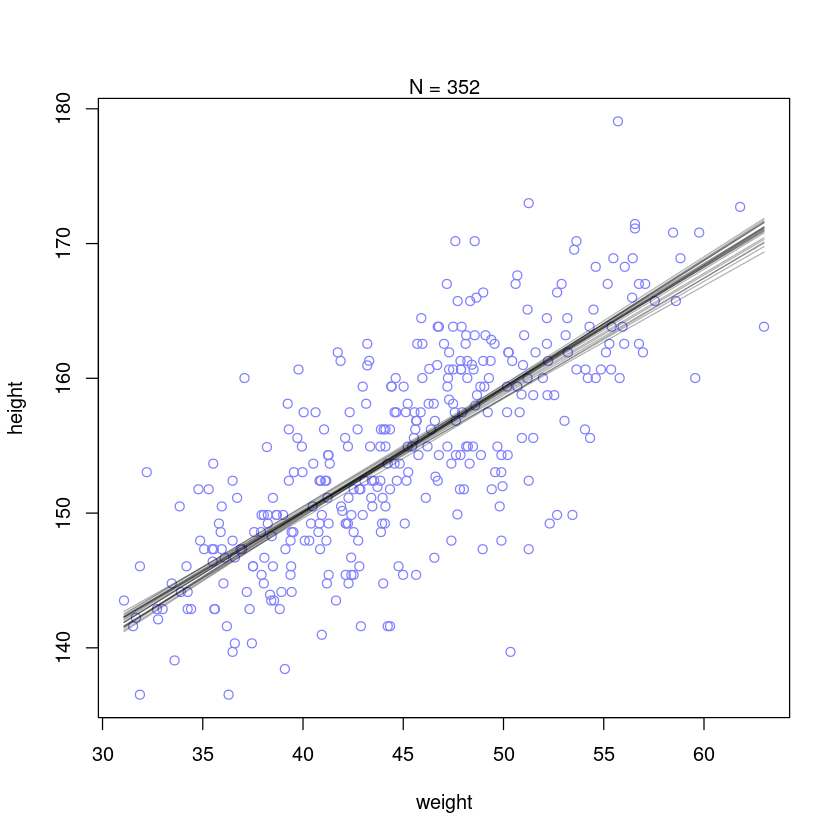

In [39]:
for (N in c(10, 50, 150, 352)) {
    dN <- d2[1:N,]
    mN <- quap(
        alist(
            height ~ dnorm(mu, sigma),
            mu <- a + b * (weight - mean(weight)),
            a ~ dnorm(178, 20),
            b ~ dlnorm(0, 1),
            sigma ~ dunif(0, 50)
        ),
        data=dN
    )

    # Now choose 20 lines and plot them
    post <- extract.samples(mN, n=20)

    plot(dN$weight, dN$height, xlim=range(d2$weight), ylim=range(d2$height), col=rangi2, xlab="weight", ylab="height")
    mtext(concat("N = ", N))

    # plot the lines, with transparency
    for (i in 1:20) {
        curve(
            post$a[i] + post$b[i] * (x - mean(dN$weight)),
            col=col.alpha("black", 0.3), add=TRUE
        )
    }
}


So we can see that as we get more information, we become more confident about our predictions.

#### Plotting regression intervals and contours

Often, a more informative approach to what we just did is to plot some sort of interval around the mean line.

Focus for a moment on a single individual, weighing (say) 50kg. We can quickly make a list of 10 000 values of $\mu$ for this individual:

In [40]:
post <- extract.samples(m4.3)
mu_at_50 <- post$a + post$b * (50 - xbar)
mu_at_50

[1] 159.3457 159.3008 158.6059 159.1450 159.2880 158.8278 158.6024 159.0867
    [9] 159.7208 159.3828 159.0538 159.2775 159.1143 158.3348 159.0993 158.9829
   [17] 159.1478 158.9917 159.1985 158.8457 159.8220 159.1810 159.5342 158.6001
   [25] 158.4106 158.7468 159.8537 159.3374 159.0208 158.5033 159.5049 159.1258
   [33] 159.0484 159.0366 158.7852 158.8986 159.6458 159.4208 159.8632 158.7737
   [41] 159.3176 159.1003 158.8371 159.2845 159.6993 159.2630 159.5484 159.2309
   [49] 158.7257 159.2439 159.4383 159.1695 159.5127 158.9710 158.7893 159.2325
   [57] 159.3458 159.3287 158.6988 158.0852 159.0522 159.4457 158.6658 159.0561
   [65] 159.7231 158.7768 159.3309 159.2773 159.2011 159.1038 159.0575 159.0713
   [73] 159.3253 159.5401 159.0159 159.3227 158.6563 159.2945 158.8843 159.3788
   [81] 159.3520 159.6440 158.4293 159.2131 158.7058 158.6124 159.3043 158.9299
   [89] 158.3248 158.3958 159.2037 158.8270 159.4279 158.9989 159.0667 158.9166
   [97] 159.8524 158.9125 158.9654 158.7783 158.9990 158.9931 159.3649 158.6802
  [105] 159.0113 159.4768 159.1709 159.0496 158.8034 158.3495 158.9035 159.3447
  [113] 158.6212 159.1658 159.4529 159.4501 159.2291 158.8391 158.7768 158.5986
  [121] 158.8673 159.2496 159.0479 158.4555 159.1293 159.3524 158.9163 159.1298
  [129] 159.3531 159.8536 159.3452 158.8075 159.0024 159.4193 159.1699 159.2796
  [137] 159.3796 159.0176 159.5011 159.2722 159.1377 159.4994 159.0323 159.2178
  [145] 159.0654 159.2760 159.6202 158.7038 159.3875 159.3317 158.8247 158.7847
  [153] 159.1686 159.2097 158.5623 158.5762 159.1551 159.1325 159.2123 158.9132
  [161] 159.3205 159.5759 159.4917 159.0068 159.0652 158.5630 158.9552 158.8514
  [169] 158.7956 159.1840 159.3153 159.1323 158.9848 159.5928 158.9330 158.8246
  [177] 159.1286 159.0882 159.2548 158.5736 159.1003 159.3568 158.9731 159.2468
  [185] 158.1626 159.3262 159.4752 159.0168 158.6022 159.4489 159.0441 159.8322
  [193] 158.8883 159.3576 158.9774 159.8544 159.3087 158.8707 158.9308 159.0465
  [201] 159.5862 158.8366 159.5308 158.8082 158.5800 158.9861 158.9558 159.4759
  [209] 158.8066 159.1104 159.0037 159.0669 159.1510 159.0825 158.3066 159.4867
  [217] 158.6831 158.6542 159.2946 159.4672 159.0770 158.9051 158.8318 158.7225
  [225] 159.9453 159.4745 158.7336 158.8458 159.0320 159.2802 158.9305 159.5381
  [233] 158.8314 159.5193 159.1687 158.8944 158.8950 159.3002 159.5103 159.2178
  [241] 159.3247 158.5496 160.1180 158.9183 159.3878 158.8373 158.5356 158.8186
  [249] 159.1769 159.0695 159.3770 158.6764 159.2600 159.1513 158.6342 158.9658
  [257] 159.0229 159.5165 158.7486 158.6305 159.3003 159.9219 159.1838 158.7475
  [265] 159.4883 159.5989 159.5157 158.5651 159.0908 158.7055 159.6320 159.2021
  [273] 159.2177 159.1821 158.8325 159.0979 159.1612 159.4080 158.7104 159.5055
  [281] 158.6600 159.3345 159.2910 159.1734 159.2553 159.6051 158.3744 159.1714
  [289] 158.5172 159.0263 159.0565 159.1663 158.8596 159.1060 159.2543 159.8308
  [297] 159.1963 159.5860 158.8180 158.8030 159.3729 159.3868 158.5615 159.4929
  [305] 158.7710 158.9665 159.3960 158.9736 159.0101 158.5091 158.7917 159.0247
  [313] 158.4386 159.7501 159.4741 159.0615 159.0109 159.4728 159.1949 159.0194
  [321] 158.5268 159.1639 158.8646 158.9845 159.0618 158.8478 159.0611 159.3378
  [329] 159.4979 159.6617 158.9840 158.9526 158.7749 159.2434 158.9231 158.6639
  [337] 159.3483 159.6504 159.6513 159.4718 158.7644 159.0549 158.9715 158.8971
  [345] 159.2038 158.8229 159.4362 159.5439 158.8076 159.4665 158.8993 158.6628
  [353] 159.3658 159.5830 159.4044 159.0207 158.7611 158.3732 159.0340 158.5332
  [361] 158.3122 159.2990 159.1676 158.7763 159.3660 159.4282 158.3608 159.4339
  [369] 158.5849 159.5722 159.4778 158.6067 159.2281 159.2591 159.3310 159.4926
  [377] 158.6006 158.8299 158.7036 159.1364 158.9596 159.7678 159.1255 158.6150
  [385] 158.9429 159.2346 159.6178 159.2912 159.0225 159.6068 159.4749 159.0193
  [393] 158.7409 159.5775 159.1675 158.9879 159.4991 159.2838 159.5901 158.8211
  [4

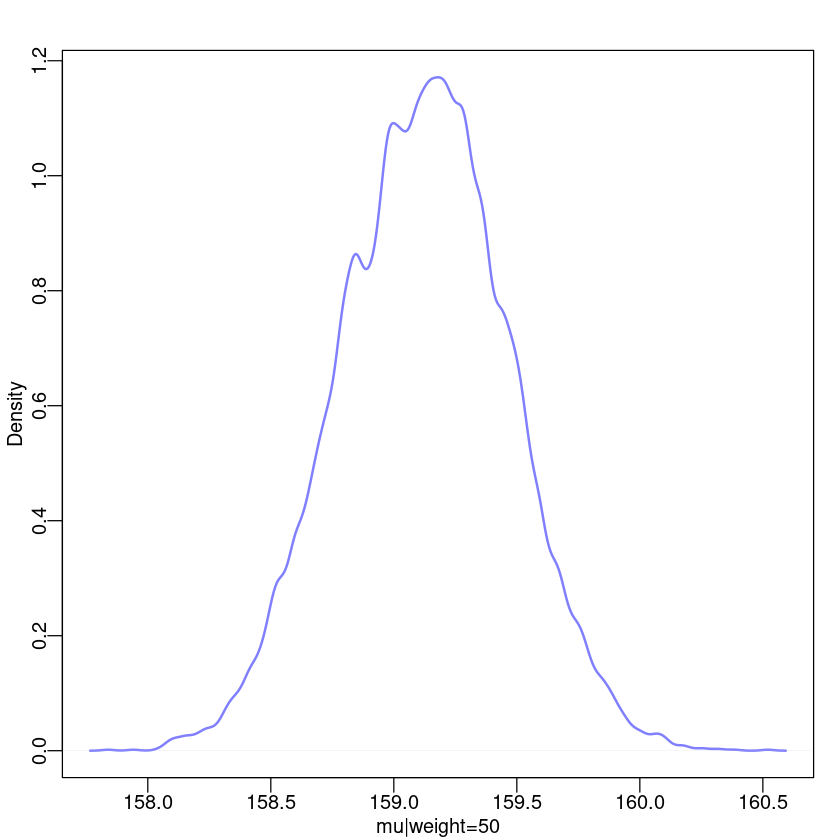

In [41]:
dens(mu_at_50, col=rangi2, lwd=2, xlab="mu|weight=50")

Since this is a distribution, we can find intervals for it, same as for any distribution:

In [42]:
PI(mu_at_50, prob=0.89)

5%      94% 
158.5683 159.6647

To do this for all values (not just 50), we can use the `link` function from `rethinking`. What it does is to take the `quap` approximation, sample from the posterior distribution, and then compute $\mu$ for each case in the data and sample from the posterior distribution.

In [43]:
mu <- link(m4.3)
str(mu)

 num [1:1000, 1:352] 157 157 157 157 158 ...


So what we end up with is a big matrix of values for $\mu$. Each column is a case (row) in the data. Since there are 352 rows in $d2$, there are 352 columns in the matric $mu$ above.

In [44]:
# define sequences of weights to compute predictions for
# these values will be on the horizontal axis
weight.seq <- seq(from=25, to=70, by=1)

# use link to compute mu
# for each sample from posterior
# and for each weight in weight.seq
mu <- link( m4.3, data=data.frame(weight=weight.seq))
str(mu)

 num [1:1000, 1:46] 138 136 137 136 137 ...


Now there are only 46 columns, since we only fed it 46 input values.

The final step is to summarize the distribution for each weight value. We'll up `apply`, which applies a function of your choice to a matrix

In [45]:
# summarize the distributions of mu
mu.mean <- apply(mu, 2, mean)
mu.PI <- apply(mu, 2, PI, prob=0.89)

```R
aply(mu, 2, mean)
```
Should be read as 'Apply the function `mean` to each column (dimension "2") of the matrix'

In [46]:
mu.mean

[1] 136.5223 137.4270 138.3317 139.2364 140.1411 141.0459 141.9506 142.8553
 [9] 143.7600 144.6647 145.5694 146.4741 147.3788 148.2835 149.1883 150.0930
[17] 150.9977 151.9024 152.8071 153.7118 154.6165 155.5212 156.4259 157.3307
[25] 158.2354 159.1401 160.0448 160.9495 161.8542 162.7589 163.6636 164.5683
[33] 165.4731 166.3778 167.2825 168.1872 169.0919 169.9966 170.9013 171.8060
[41] 172.7107 173.6155 174.5202 175.4249 176.3296 177.2343

In [47]:
mu.PI

5%,135.0892,136.0616,137.0262,137.9920,138.9579,139.9237,140.8939,141.8541,142.8196,143.7910,⋯,167.9757,168.8244,169.6622,170.4931,171.3282,172.1585,172.9925,173.8323,174.6725,175.5184
94%,137.8951,138.7263,139.5753,140.4229,141.2775,142.1341,142.9903,143.8280,144.6656,145.5149,⋯,170.2506,171.2268,172.1978,173.1622,174.1323,175.1177,176.0986,177.0539,178.0191,178.9851


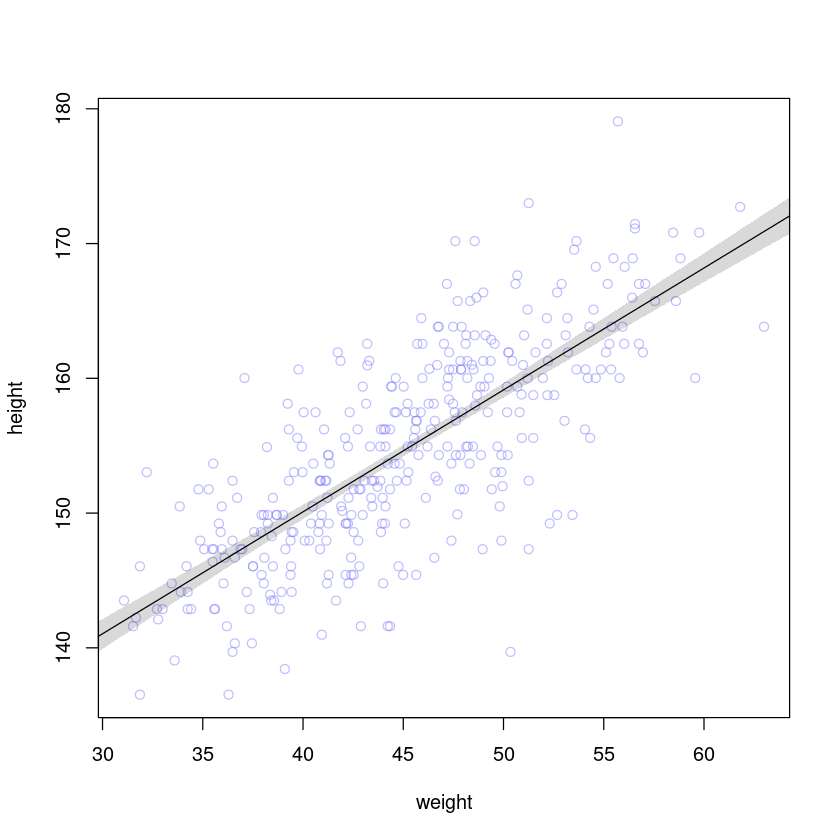

In [48]:
# plot raw data, fading out the points to make line and interval more visible
plot(height ~ weight, data=d2, col=col.alpha(rangi2,0.5))

# plot the MAP lines, aka the mean mu for each weight
lines(weight.seq, mu.mean)

# plot a shaded region for 89% PI
shade(mu.PI, weight.seq)

To summarize, here's the recipe for generating predictions and intervals from the posterior of a fit model:
1. Use `link` to generate distributions of posterior values of $\mu$. The default behaviour of `link` is to use the original data, so you have to pass it a list of new horizontal ais values you want to plot posterior predictions across
1. Use summary functions like `mean` or `PI` to find averages and lower and upper bounds of $\mu$ for each value of the predictor variable
1. Finally, use plotting functions like `lines` and `shade` to draw the lines and intervals. Or, you might plot the distributions of the predictions, or do further numerical calculations with them

** How `link` works **

The `link` function is not terribly complicated. Here's how it might look in our case:

In [49]:
post <- extract.samples(m4.3)
mu.link <- function(weight) post$a + post$b * (weight - xbar)
weight.seq <- seq(from=25, to=70, by=1)
mu <- sapply(weight.seq, mu.link)
mu.mean <- apply(mu, 2, mean)
mu.PI <- apply(mu, 2, PI)

In [50]:
mu.mean

[1] 136.5519 137.4550 138.3581 139.2612 140.1643 141.0674 141.9704 142.8735
 [9] 143.7766 144.6797 145.5828 146.4859 147.3890 148.2920 149.1951 150.0982
[17] 151.0013 151.9044 152.8075 153.7105 154.6136 155.5167 156.4198 157.3229
[25] 158.2260 159.1291 160.0321 160.9352 161.8383 162.7414 163.6445 164.5476
[33] 165.4506 166.3537 167.2568 168.1599 169.0630 169.9661 170.8692 171.7722
[41] 172.6753 173.5784 174.4815 175.3846 176.2877 177.1907

In [51]:
mu.PI

5%,135.1395,136.1057,137.0768,138.0440,139.0118,139.9768,140.9429,141.9087,142.8728,143.8376,⋯,167.9067,168.7443,169.5822,170.4206,171.2634,172.1023,172.9452,173.7862,174.6224,175.4604
94%,137.9672,138.8059,139.6474,140.4865,141.3249,142.1704,143.0139,143.8543,144.6879,145.5315,⋯,170.2367,171.2065,172.1768,173.1388,174.1076,175.0769,176.0446,177.0010,177.9730,178.9463


#### Prediction intervals

Now let's walk through generating and 89% prediction interval for actual heights, not just the average height, $\mu$. This means we'll incorporate the standard deviation $\sigma$ and its uncertainty as well. Remember, the first line of the statistical model here is
$$
h_i \sim \text{Normal}(\mu_i, \sigma)
$$

What we've done so far is just use samples from the posterior to visualize the uncertainty in $\mu_i$, the linear model of the mean. But actual predictions of the height also depend on the distribution in the first line.

Here's how we do that. Imagine simulating heights. For any unique weight value, you samples from a Gaussian distribution with the correct mean $\mu$ for that weight, using the correct value of $\sigma$ samples from the same posterior distribution. If we do this for every sample from the posterior, for every weight value of interest, we end up with a collection of simulated heights that embody the uncertainty in the posterior as well as the uncertainty in the Gaussian distribution of heights. There is a tool called `sim` which does this:

In [52]:
sim.heights <- sim(m4.3, data=list(weight=weight.seq))
str(sim.heights)

 num [1:1000, 1:46] 130 130 133 146 144 ...


This is much like the earlier one, $\mu$, but contains sunmulated heights, not distributions of average heights.

We can summarize these simulated heights in the same way we summarize the distributions of $\mu$, by using `apply`:

In [53]:
heights.PI <- apply(sim.heights, 2, PI, prob=0.89)

Now we can plot everything which we have:
1. The average line
1. The shaded region of 89% plausible $\mu$
1. The boundaries of the simulated heights the model expects

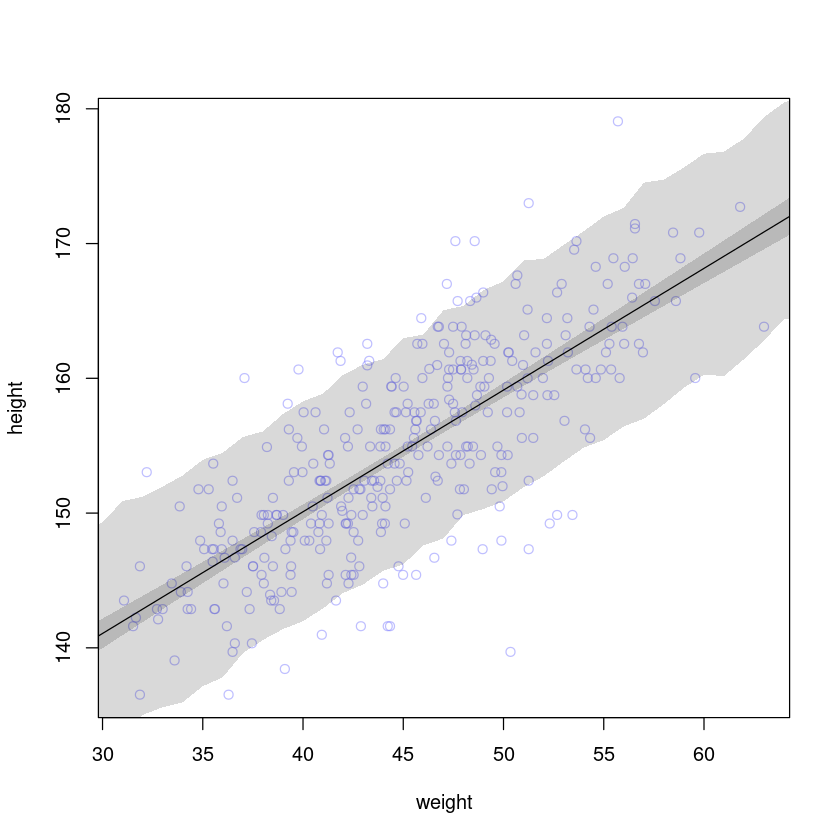

In [54]:
# raw data
plot(height ~ weight, d2, col=col.alpha(rangi2, 0.5))

# MAP line
lines(weight.seq, mu.mean)

# Draw the HPDI for line
shade(mu.PI, weight.seq)

# Draw PI region for simulated heights
shade(heights.PI, weight.seq)

The roughness in the shaded region is due to variance in the simulation. We can always increase the number of points that we use to smooth it out:

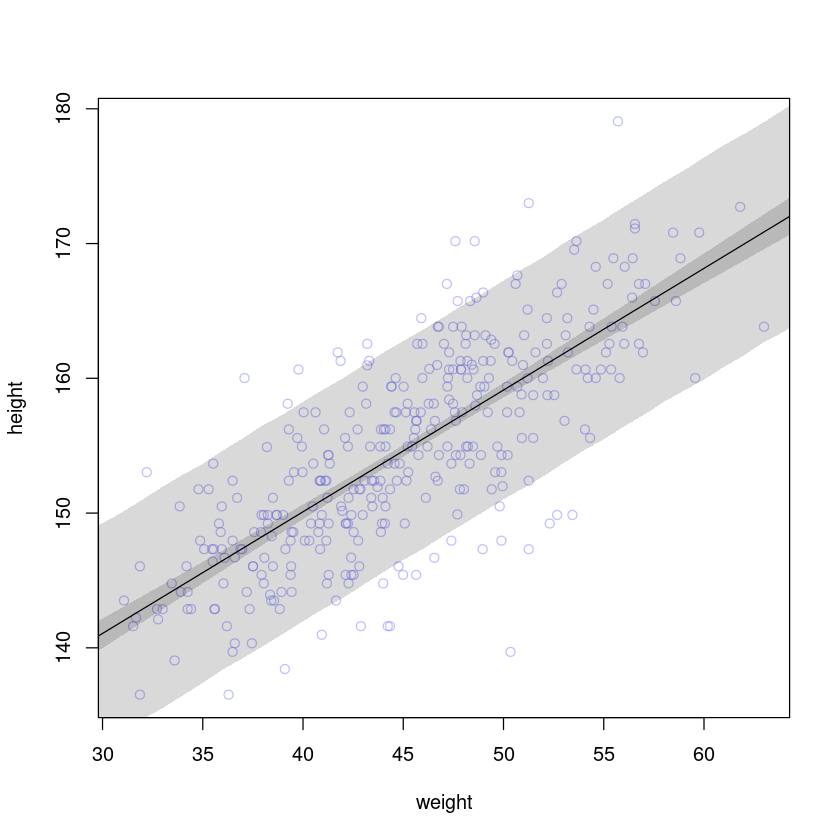

In [55]:
# increasing the number of points used
sim.heights <- sim(m4.3, data=list(weight=weight.seq), n=1e5)
heights.PI <- apply(sim.heights, 2, PI, prob=0.89)

plot(height ~ weight, d2, col=col.alpha(rangi2, 0.5))
lines(weight.seq, mu.mean)
shade(mu.PI, weight.seq)
shade(heights.PI, weight.seq)

** Rolling your own `sim` **

Just like with `link`, it's useful to know how to do things.

For every distribution (like `dnorm`), there is a companion simulation function. For the Gaussian, that is `rnorm`, and it simulates sampling from a Gaussian distribution. What we want R to di is to simulate a height for eac hset of samples, and to do this for each value of weight. The following will do it:

In [56]:
post <- extract.samples(m4.3)
weight.seq <- 25:70
sim.height <- sapply(weight.seq, function(weight)
    rnorm(
        n=nrow(post),
        mean=post$a + post$b * (weight - xbar),
        sd=post$sigma
    )
)
height.PI <- apply(sim.height, 2, PI, prob=0.89)

## Curves from lines

In the next chapter, we'll build linear models with more than one predictor variable. Before that though, let's build a model with a curve rather than a line. There are two common methods: _polynomial regression_ and _b-splines_.

### Polynomial regression
Polynomial regression uses powers of the predictor variable as additional predictors. This is an easy way to add some curviness to the models. Let's use polynomial regression to model the data for all of the !Kung, not just the adults.

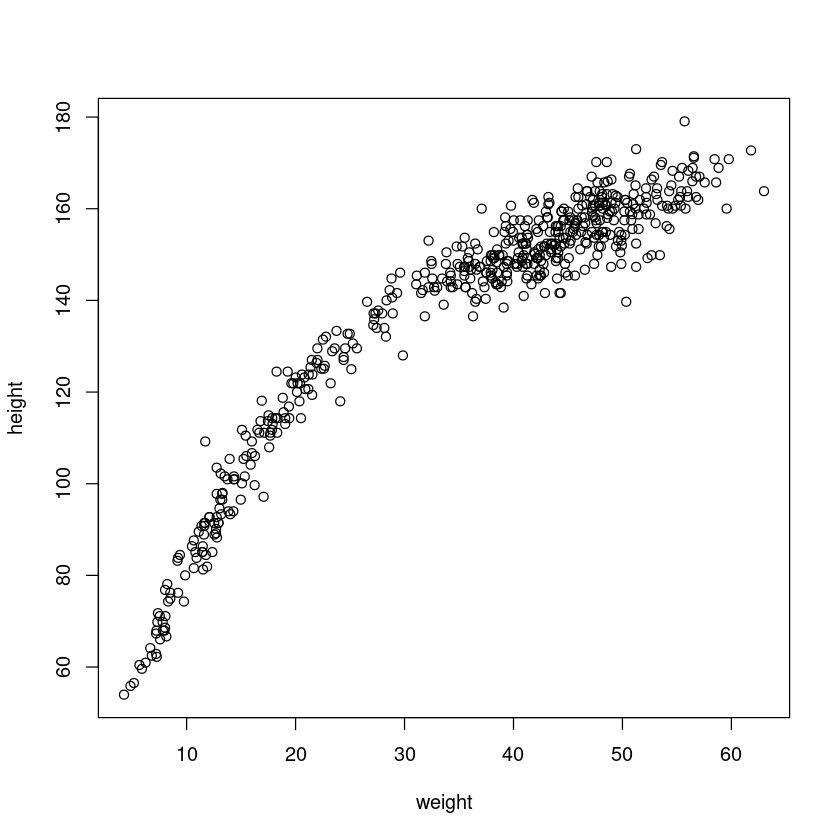

In [57]:
d <- Howell1

plot(height ~ weight, d)

The relationship is visibly curved - clearly a linear model will not work very well!

The most common polynomial refgression is a parabolic model of the mean. Let $x$ be the standardixed body weight. Then the parabolic equation for the mean height is:
$$
\mu_i = \alpha + \beta_1 x_i + \beta_2 x_i^2
$$

Fitting the model is easy - interpreting it is hard!

The first thing that we need to do is to *standardize* the predictor variable. This means applying the transformation $x \to \frac{x - \bar{x}}{sd(x)}$ - taking $x$ to its z score.

With this new parameter, here's our model:
$$
\begin{align*}
h_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta_1 x_i + \beta_2 x_i ^ 2 \\
\alpha &\sim \text{Normal}(178, 20) \\
\beta_1 &\sim \text{Log-Normal}(0, 1) \\
\beta_2 &\sim \text{Normal}(0, 1) \\
\sigma &\sim \text{Uniform}(0, 50) \\
\end{align*}
$$

The confusing thing here is assigning a prior for $\beta_2$, the parameter on the squared value of $x$.

In [58]:
# building the model
d$weight_s <- (d$weight - mean(d$weight)) / sd(d$weight) # standardized
d$weight_s2 <- d$weight_s ^ 2 #squared - no need to calculate it every time

m4.5 <- quap(
    alist(
        height ~ dnorm(mu, sigma),
        mu <- a + b1*weight_s + b2*weight_s2,
        a ~ dnorm(178, 20),
        b1 ~ dlnorm(0, 1),
        b2 ~ dnorm(0, 1),
        sigma ~ dunif(0, 50)
    ),
    data=d
)

In [59]:
precis(m4.5)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,146.055481,0.3689255,145.465867,146.645095
b1,21.733026,0.2888405,21.271403,22.194649
b2,-7.801266,0.2741548,-8.239418,-7.363113
sigma,5.773496,0.1763920,5.491587,6.055404


It's a little more difficult to interpret this, so let's plot it instead!

In [60]:
weight.seq <- seq(from=-2.2, to=2.2, length.out=30)
pred_dat <- list(weight_s=weight.seq, weight_s2=weight.seq^2)
mu <- link(m4.5, data=pred_dat)
mu.mean <- apply(mu, 2, mean)
mu.PI <- apply(mu, 2, PI, prob=0.89)
sim.height <- sim(m4.5, data=pred_dat)
height.PI <- apply(sim.height, 2, PI, prob=0.89)

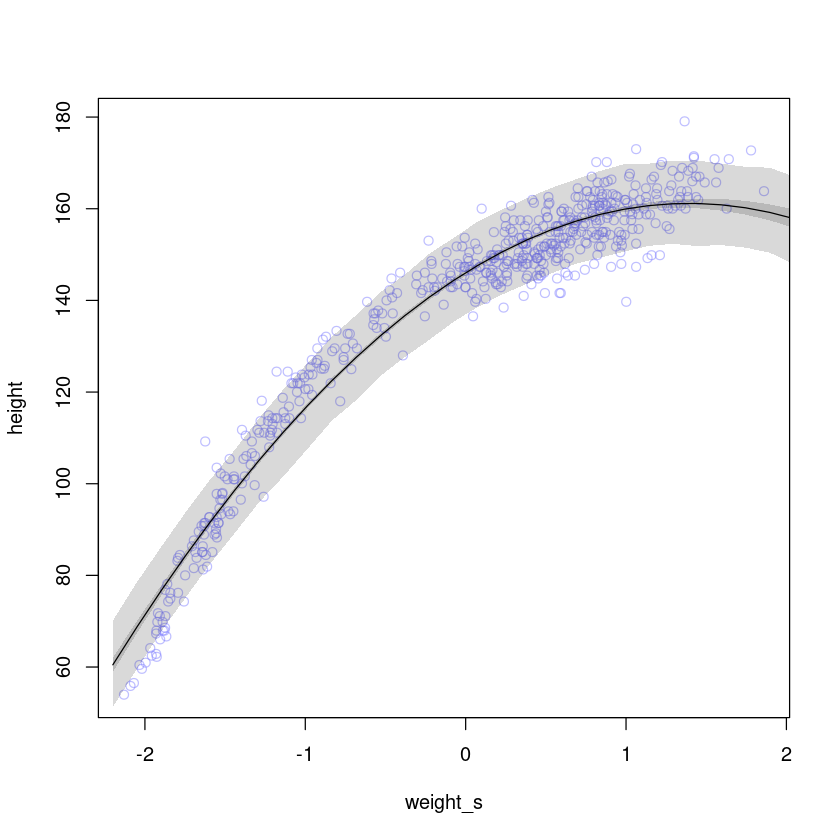

In [61]:
plot(height ~ weight_s, d, col=col.alpha(rangi2, 0.5))
lines(weight.seq, mu.mean)
shade(mu.PI, weight.seq)
shade(height.PI, weight.seq)

This looks like a better approximation than the linear one, especially at the ends! We might be able to make it better by using another, cubic term:
$$
\begin{align*}
h_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta_1 x_i + \beta_2 x_i ^ 2 + \beta_3 x_i ^ 3 \\
\alpha &\sim \text{Normal}(178, 20) \\
\beta_1 &\sim \text{Log-Normal}(0, 1) \\
\beta_2 &\sim \text{Normal}(0, 1) \\
\beta_3 &\sim \text{Normal}(0, 1) \\
\sigma &\sim \text{Uniform}(0, 50) \\
\end{align*}
$$

In [62]:
d$weight_s3 <- d$weight_s^3
m4.6 <- quap(
    alist(
        height ~ dnorm(mu, sigma),
        mu <- a + b1*weight_s + b2*weight_s2 + b3*weight_s3,
        a ~ dnorm(178, 20),
        b1 ~ dlnorm(0, 1),
        b2 ~ dnorm(0, 1),
        b3 ~ dnorm(0, 1),
        sigma ~ dunif(0, 50)
    ),
    data=d
)

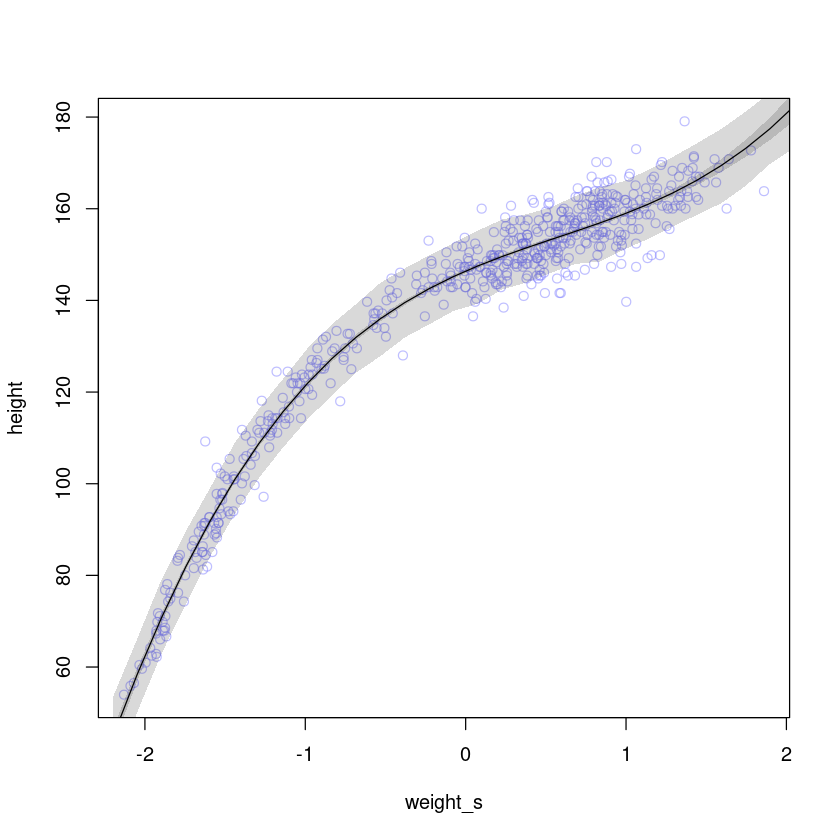

In [63]:
weight.seq <- seq(from=-2.2, to=2.2, length.out=30)
pred_dat <- list(weight_s=weight.seq, weight_s2=weight.seq^2, weight_s3=weight.seq^3)
mu <- link(m4.6, data=pred_dat)
mu.mean <- apply(mu, 2, mean)
mu.PI <- apply(mu, 2, PI, prob=0.89)
sim.height <- sim(m4.6, data=pred_dat)
height.PI <- apply(sim.height, 2, PI, prob=0.89)

plot(height ~ weight_s, d, col=col.alpha(rangi2, 0.5))
lines(weight.seq, mu.mean)
shade(mu.PI, weight.seq)
shade(height.PI, weight.seq)

This looks even better! One of the problems is that this model doesn't really give us any sort of insight into the process here - why would a cubic model fit human growth curves? Who knows! Also we need to be careful - just because a model fits the data better doesn't mean that it is a better model. Also, we can always just keep adding terms to fit the data perfectly - obviously this isn't the best idea!

If we want to, we can also recover the initial units (rather than the z-scores):

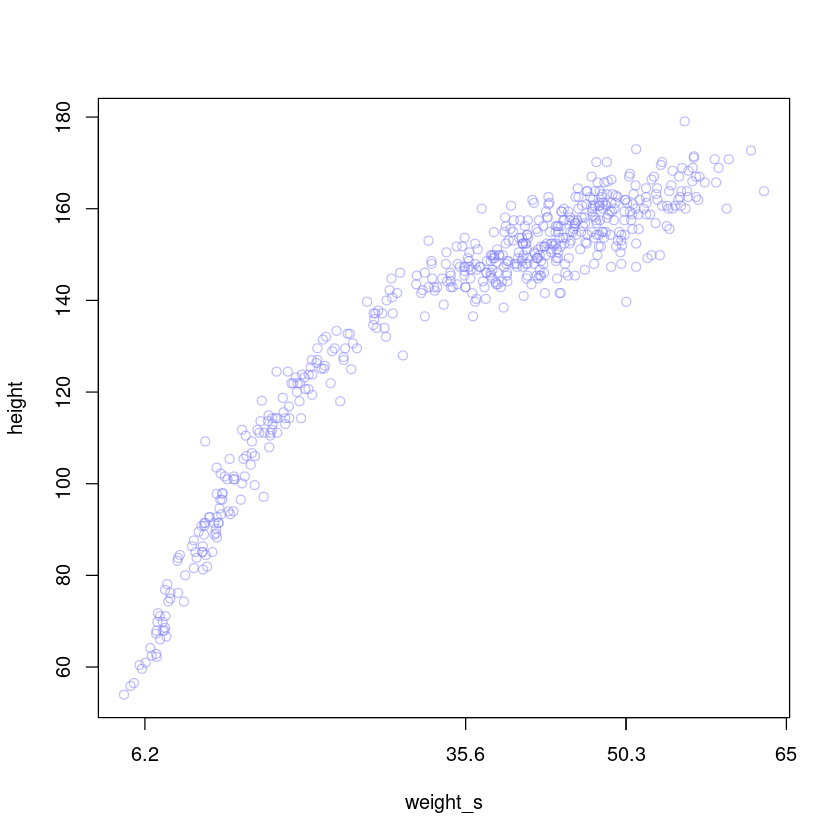

In [64]:
plot(height ~ weight_s, d, col=col.alpha(rangi2, 0.5), xaxt="n") # turn off the axis

# now we explicity construct the axis:
at <- c(-2, 1, 0, 1, 2)
labels <- at * sd(d$weight) + mean(d$weight)
axis(side=1, at=at, labels=round(labels,1))

### Splines

A spline was originally a piece of wood or whatnot that was fixed in a few places and allowed to assume a smooth curve. Mathematically, a spline is a smooth function which is built out of smaller component functions. There are many kinds of splines. Here, we'll look at *b-splines* - the "b" stands for "basis".

We'll use cherry blossom data to see how they work.

In [65]:
library(rethinking)
data(cherry_blossoms)
d <- cherry_blossoms
precis(d)

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
year,1408.000000,350.8845964,867.77000,1948.23000,▇▇▇▇▇▇▇▇▇▇▇▇▁
doy,104.540508,6.4070362,94.43000,115.00000,▁▂▅▇▇▃▁▁
temp,6.141886,0.6636479,5.15000,7.29470,▁▃▅▇▃▂▁▁
temp_upper,7.185151,0.9929206,5.89765,8.90235,▁▂▅▇▇▅▂▂▁▁▁▁▁▁▁
temp_lower,5.098941,0.8503496,3.78765,6.37000,▁▁▁▁▁▁▁▃▅▇▃▂▁▁▁


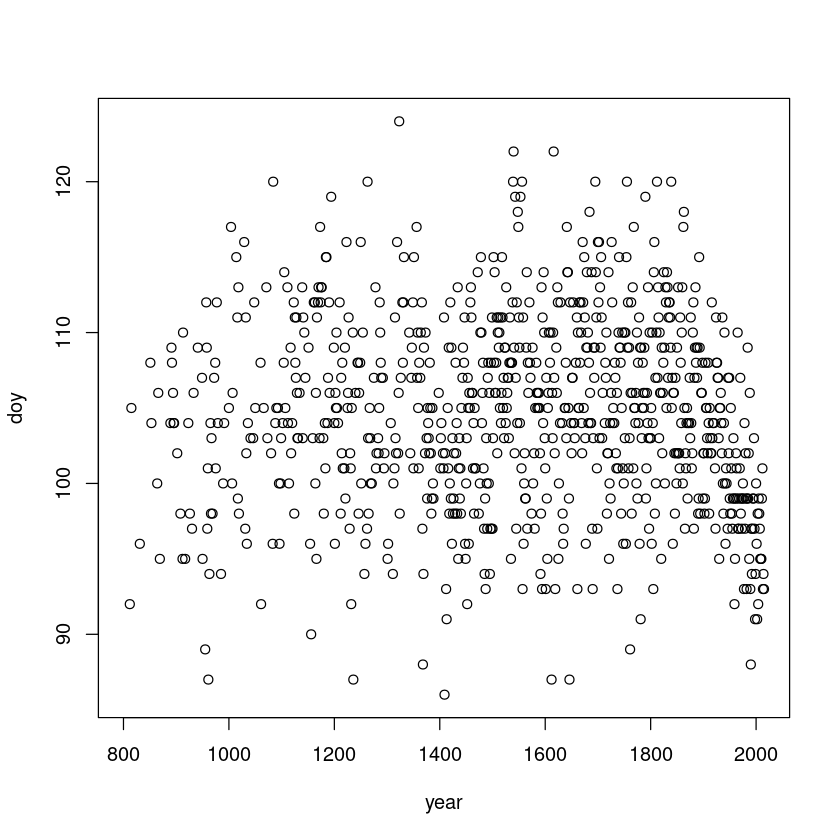

In [66]:
plot(doy ~ year, data=d)

There might be some sort of wiggly trend here - it's hard to tell!

Let's try to build up a prediction by using splines. Basically, we are going to divide up `year` into lots of little segments, and assign a parameter to each part. The parameters are turned on and off appropriately. Each of the synthetic variables created by each spline component is there to turn some stuff on and off. Each of the synthetic variables is called a *basis function*. Then the linear model ends up being
$$
\mu_i = \alpha + w_1 B_{i,1} + w_2 B_{i,2} + w_3 B_{i,3} + \dots
$$

Where $B_{i,n}$ is the value of the $n$th basis function on row $i$, and the $w$ parameters are the weights for each. The parameters act like slopes, adjusting the influence of each basis function onf the mean $\mu_i$.

How do we construct the basis variables $B$? First we divide the full range on the horizontal axis into four parts, using pivot points called *knots*. The knots act as pivots for five different basis functions, our $B$ variables. The variables are used to gently transition from onie region to the next. Beginning at the left, basis function 1 has value 1 and all of the others are set to zero. As we move rightwards towards the second know, basis 1 declines and bases 2 increates. At know 2, basis 2 has value 1, and all of the others are set to zero.

One nice thing is that the basis functions are very local. At each point on the horizontal axis, only two (at most) basis functions have a non-zero value - the ones on either side of the point.

So, let's build the code. First we need to get the knots. Let's evenly space them by quantiles.

In [67]:
d2 <- d[complete.cases(d$doy),]
num_knots <- 15
knot_list <- quantile(d2$year, probs=seq(0,1,length.out=num_knots))
knot_list

0% 7.142857% 14.28571% 21.42857% 28.57143% 35.71429% 42.85714%       50% 
      812      1036      1174      1269      1377      1454      1518      1583 
57.14286% 64.28571% 71.42857% 78.57143% 85.71429% 92.85714%      100% 
     1650      1714      1774      1833      1893      1956      2015

The next choice is the degree of the polynomial. This determines how basis functions combine, which determines how the parameters interact to produce the spline. Luckily, R has a function that can do all of this for us

In [68]:
library(splines)
B <- bs(d2$year,
       knots=knot_list[-c(1,num_knots)],
        degree=3,
        intercept=TRUE
   )
B

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
1.00000000,0.0000000,0.0000000000,0.000000e+00,0,0,0,0,0,0,0,0,0,0,0,0,0
0.96035713,0.0393123,0.0003298367,7.286030e-07,0,0,0,0,0,0,0,0,0,0,0,0,0
0.76650948,0.2207460,0.0125594810,1.850922e-04,0,0,0,0,0,0,0,0,0,0,0,0,0
0.56334070,0.3856737,0.0493848352,1.600741e-03,0,0,0,0,0,0,0,0,0,0,0,0,0
0.54526700,0.3986837,0.0541894688,1.859854e-03,0,0,0,0,0,0,0,0,0,0,0,0,0
0.45273210,0.4597597,0.0837138624,3.794349e-03,0,0,0,0,0,0,0,0,0,0,0,0,0
0.43712204,0.4690287,0.0896000902,4.249213e-03,0,0,0,0,0,0,0,0,0,0,0,0,0
0.41438627,0.4819157,0.0987005024,4.997488e-03,0,0,0,0,0,0,0,0,0,0,0,0,0
0.28262329,0.5387095,0.1663475144,1.231968e-02,0,0,0,0,0,0,0,0,0,0,0,0,0
0.27124388,0.5417994,0.1736519200,1.330480e-02,0,0,0,0,0,0,0,0,0,0,0,0,0


The matrix `B` has 827 rows and 17 columns. Each row is a yearm corresponding to the rows in the `d2` dataframe. Each colum is a basis function, one of our synthetic variables defining a span of years within which a corresponding parameter will influence prediction. To display the basis functions, just plot each column against the year:

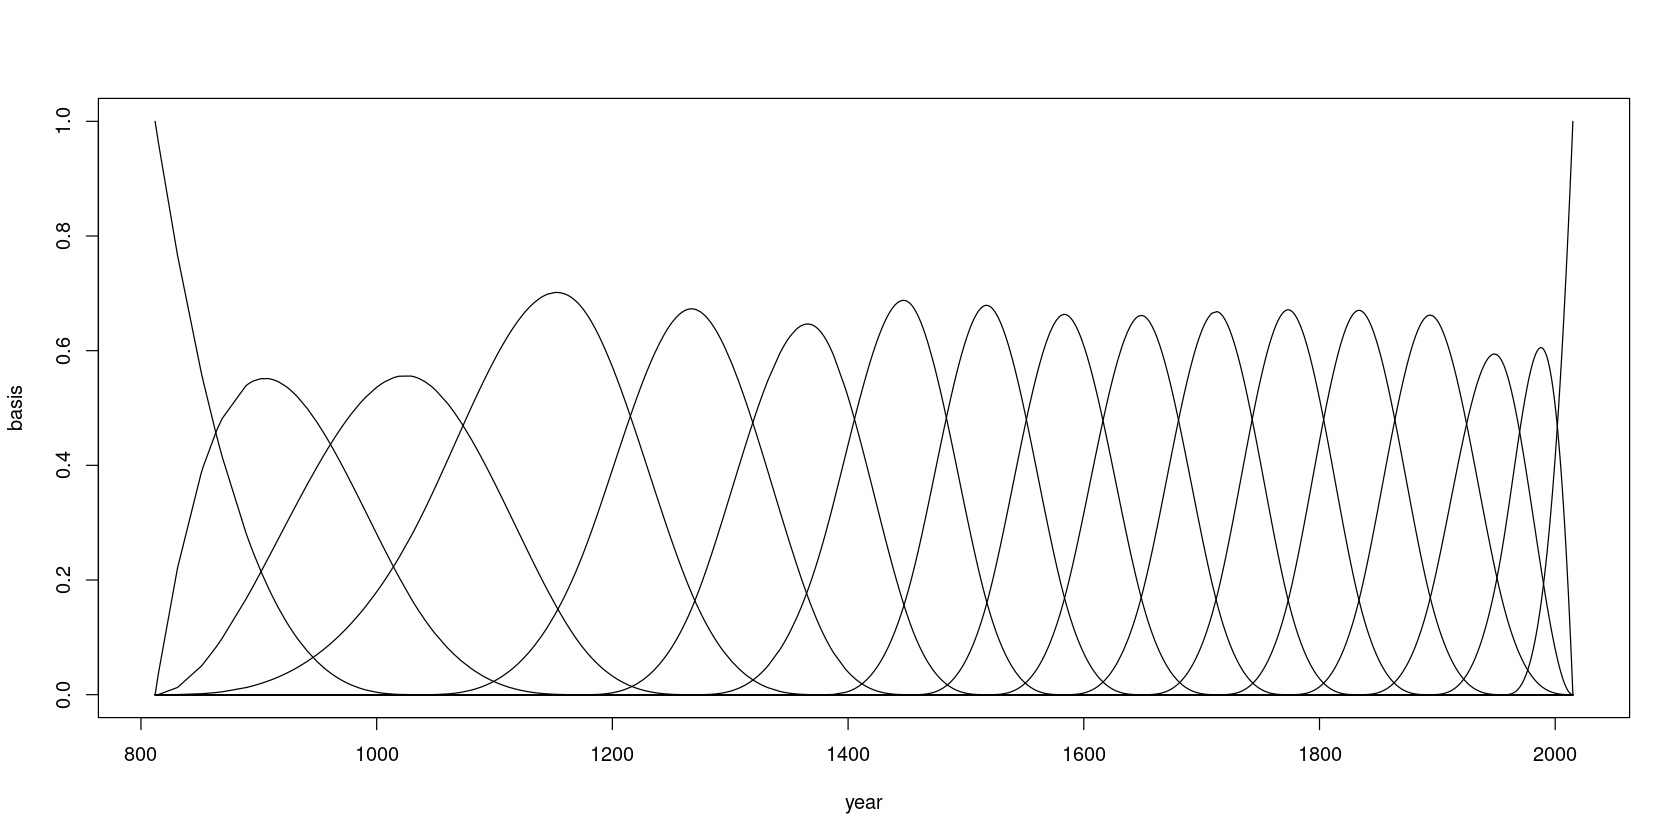

In [69]:
library(repr)
options(repr.plot.width=14)
plot(NULL, xlim=range(d2$year), ylim=c(0,1), xlab="year", ylab="basis")
for (i in 1:ncol(B)) {
    lines(d2$year, B[,i])
}

To get the actual weights, we need to define the model and make it run! In mathemtical terms:
$$
\begin{align*}
D_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i = \alpha + \sum_{k=1}^K w_k B_{k,i} \\
\end{align*}
$$

And then the priors:
$$
\begin{align*}
\alpha &\sim \text{Normal}(100,10) \\
w_j &\sim \text{Normal}(0,10) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}
$$

This is also the first time that we've used an exponential distribution. They are useful for scale parameters - ones that must be positive. The way to read an exponential distribution is to think of it as containing no more information than an average deviation. The average is the inverse of the rate. So in this case it is $1 / 1 = 1$.

Now to the model. The only trick is how to do the sum, and for that we just use matrix multiplication.

In [70]:
m4.7 <- quap(
    alist(
        D ~ dnorm(mu, sigma),
        mu <- a + B %*% w,
        a ~ dnorm(100, 10),
        w ~ dnorm(0, 10),
        sigma ~ dexp(1)
    ),
    data=list(D=d2$doy, B=B),
    start=list(w=rep(0,ncol(B))),
)

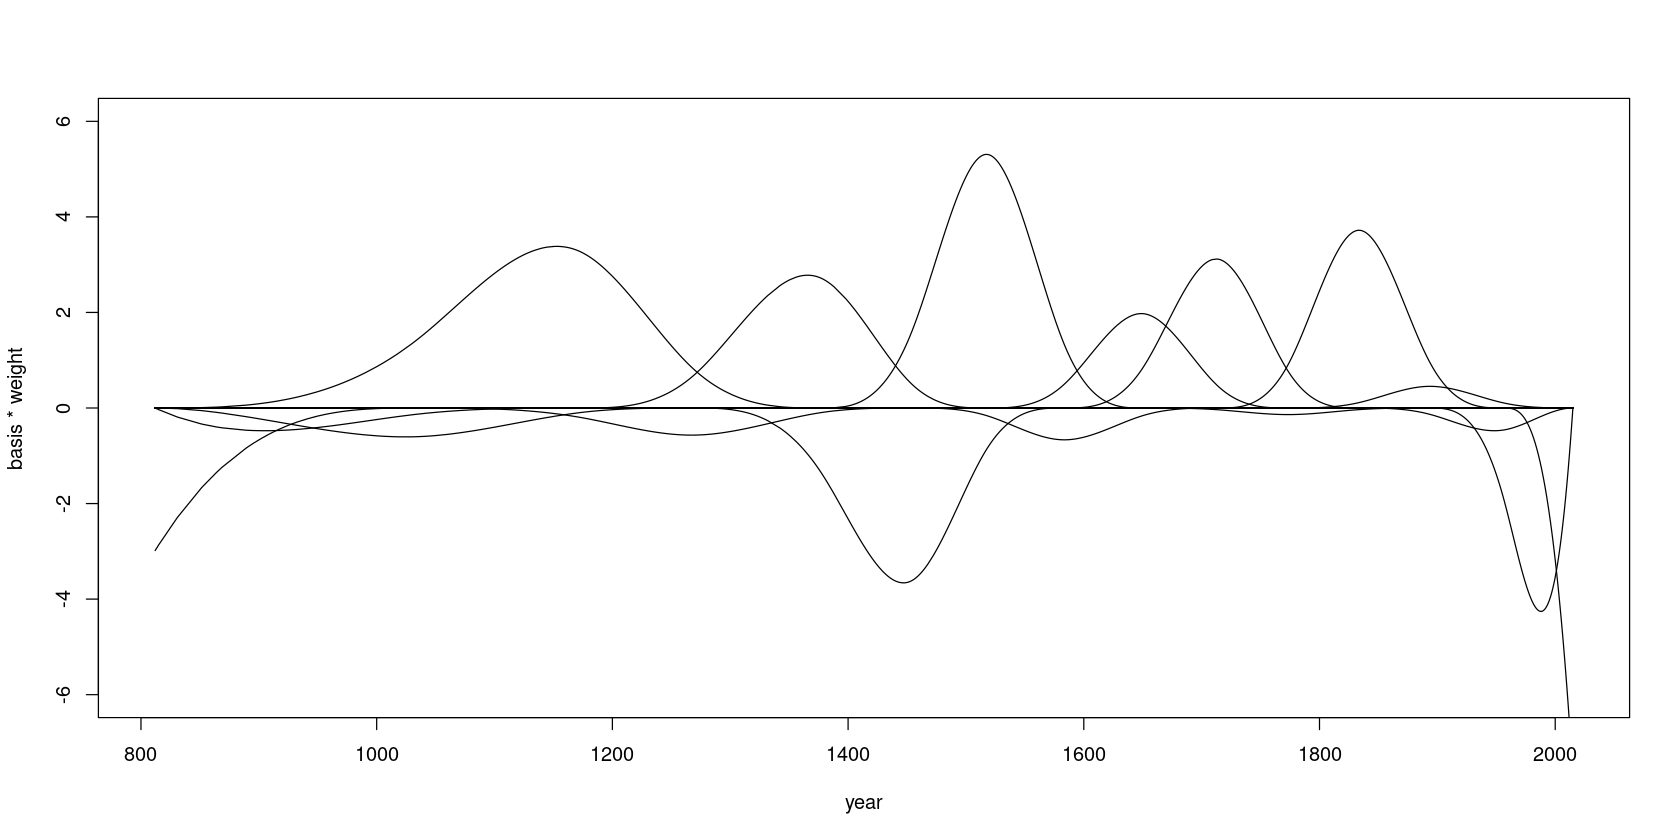

In [71]:
# Let's plot the posterior predictions to see what is going on
post <- extract.samples(m4.7)
w <- apply(post$w, 2, mean)
plot(NULL, xlim=range(d2$year), ylim=c(-6,6), xlab="year", ylab="basis * weight")
for (i in 1:ncol(B)) lines(d2$year, w[i]*B[,i])

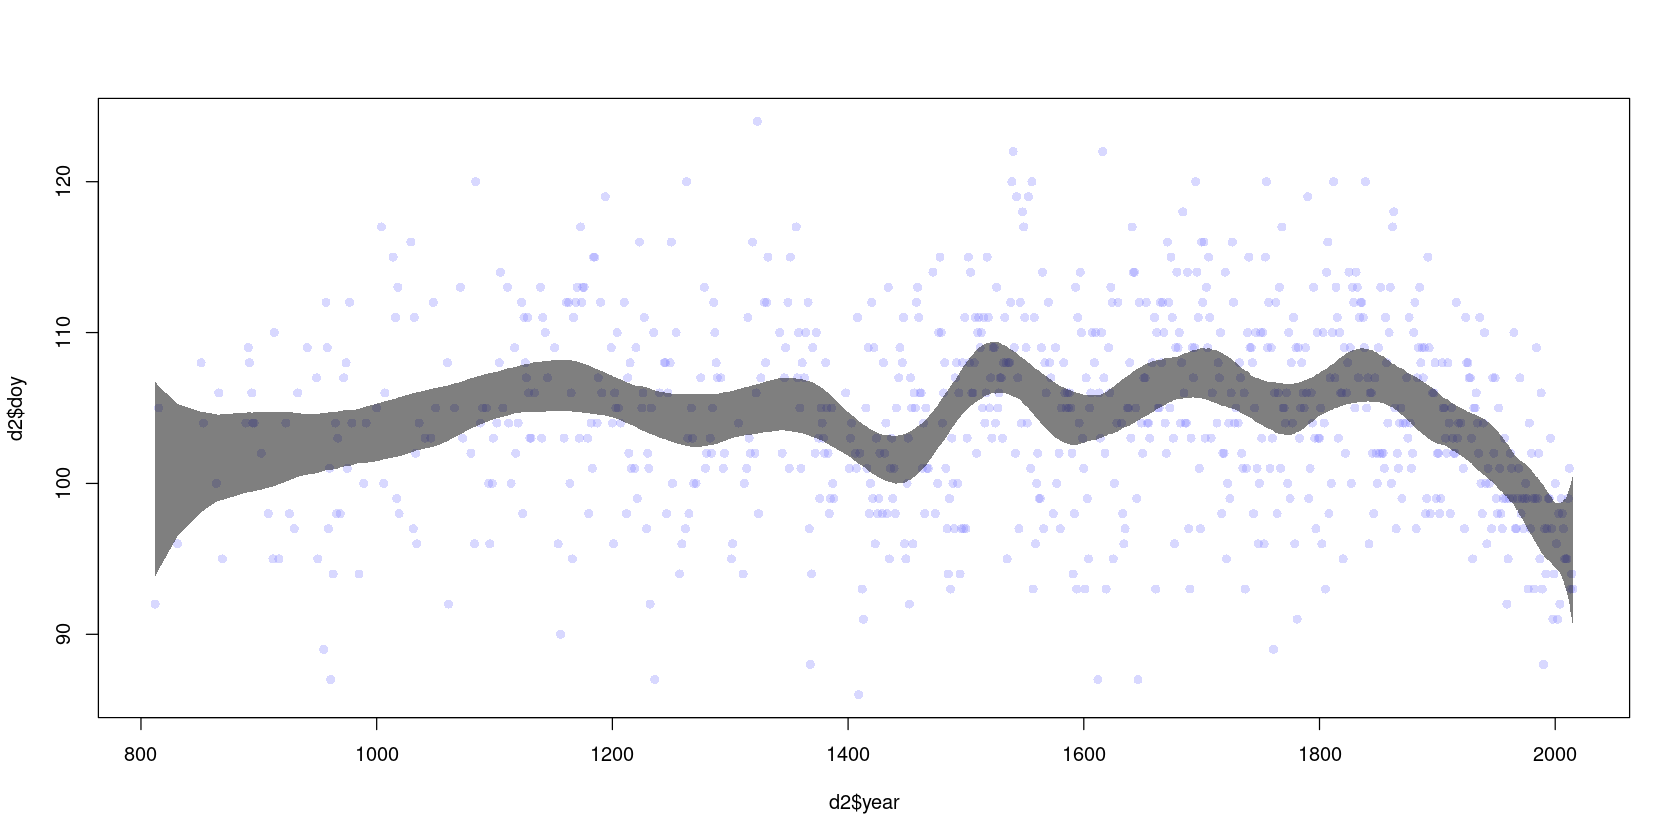

In [72]:
# 97% posterior interval for mu
mu <- link(m4.7)
mu_PI <- apply(mu, 2, PI, 0.97)
plot(d2$year, d2$doy, col=col.alpha(rangi2, 0.3), pch=16)
shade(mu_PI, d2$year, col=col.alpha("black", 0.5))

### Smooth functions for a rough world

The splines in the previous section are just the beginning. An entire class of models, *generalized additive models* (GAMs), focuses on predicting an outcome variable using smooth functions of some predictor variables. The topic is deep enough to deserve its own book.

## Practice

*4E1* In the model definition below, which line is the likelihood?
$$
\begin{align}
y_i &\sim \text{Normal}(\mu, \sigma) \\
\mu &\sim \text{Normal}(0, 10) \\
\sigma &\sim \text{Exponential}(1)
\end{align}
$$

The first one.

*4E2* In the model definition just above, how many parameters are in the posterior distribution?

Two - $\mu$ and $\sigma$.

*4E3* Using the model definition above, write down the appropriate form of Bayes' theorem that includes the proper likelihood and priors

Bayes' Theorem: $P(A|B) = \frac{P(B|A) P(A)}{P(B)}$

$$
\begin{align*}
Pr(\mu,\sigma | y) &= \frac{Pr(y | \mu, \sigma) Pr(\mu, \sigma)}{\int \int Pr(y|\mu,\sigma) Pr(\sigma) \Pr(\mu) d\mu d\sigma} \\
                    &= \frac{Normal(y|\mu, \sigma) Normal(\mu|0,10) Exponential(\sigma|1)}{\int \int Normal(y|\mu, \sigma) Normal(\mu|0,10) Exponential(\sigma|1)d\mu d\sigma}
\end{align*}
$$

*4E4* In the model definition below, which line is the linear model?
$$
\begin{align*}
y_i &\sim \text{Normal}(\mu,\sigma) \\
\mu_i &= \alpha + \beta x_i \\
\alpha &\sim \text{Normal}(0,10) \\
\beta &\sim \text{Normal}(0,1) \\
\sigma &\sim \text{Exponential}(2)
\end{align*}
$$

The second line

*4E5* In the model definition just above, how many parameters are in the posterior distribution?

Three - $\alpha$, $\beta$, and $\sigma$.

*4M1* For the model definition below, simulate observed $y$ values from the prior.
$$
\begin{align*}
y_i &\sim \text{Normal}(\mu,\sigma) \\
\mu &\sim \text{Normal}(0,10) \\
\sigma &\sim \text{Exponential}(1) \\
\end{align*}
$$

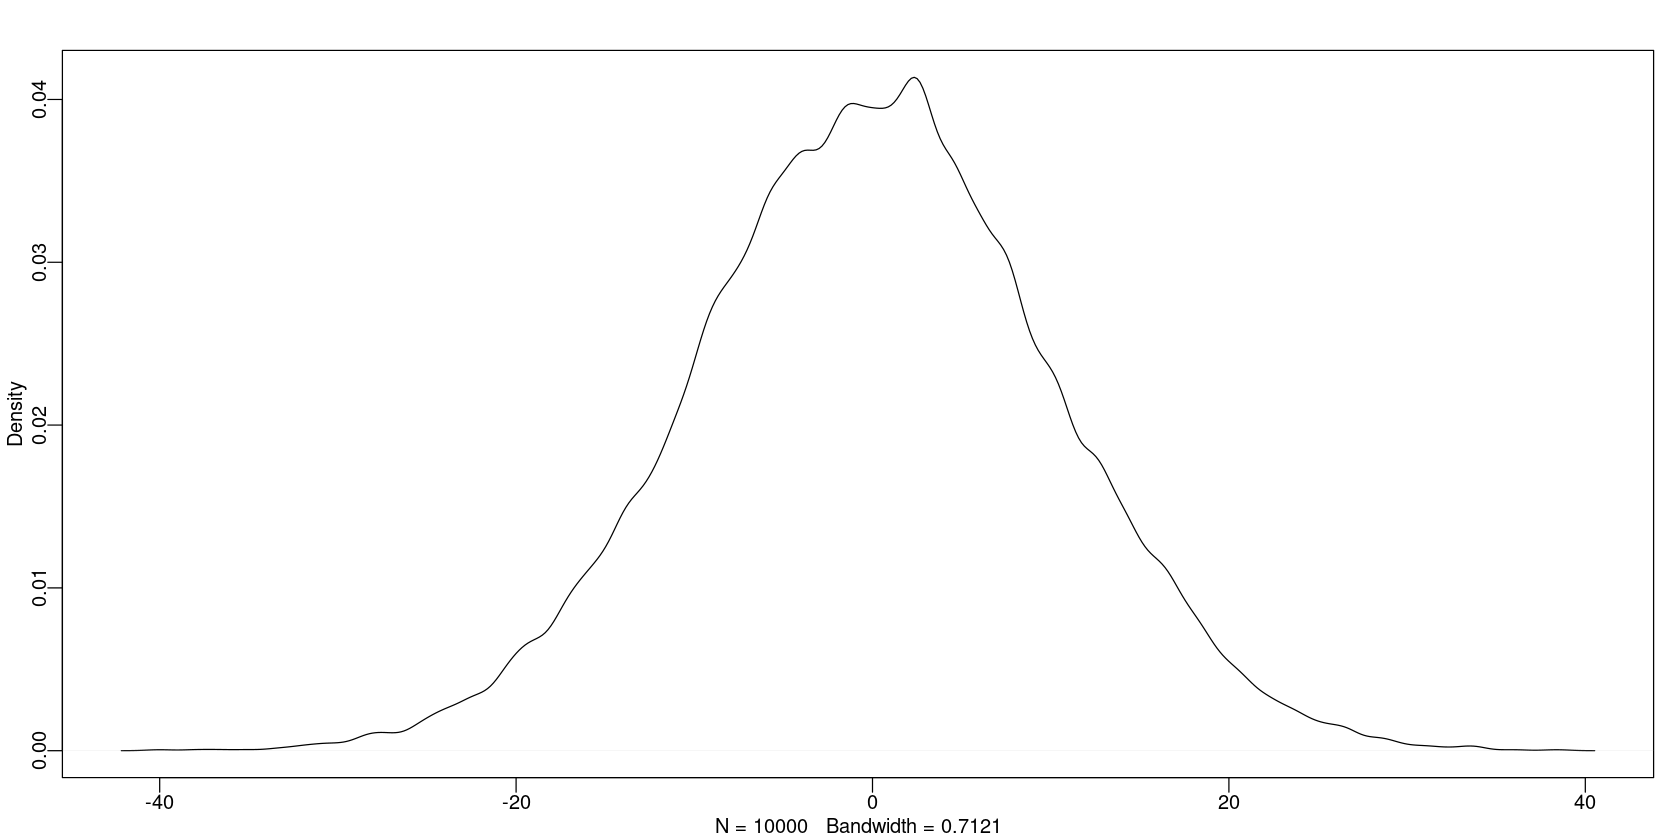

In [73]:
NUM_SAMPLES = 1E4
mus = rnorm(NUM_SAMPLES, 0, 10)
sigmas = rexp(NUM_SAMPLES, 1)
ys = rnorm(NUM_SAMPLES, mus, sigmas)
dens(ys)

*4M2* Translate the above into a `quap` formula

In [74]:
alist(
        y ~ dnorm(mu, sigma),
        mu ~ dnorm(0,10),
        sigma ~ dexp(1)
    )

[[1]]
y ~ dnorm(mu, sigma)

[[2]]
mu ~ dnorm(0, 10)

[[3]]
sigma ~ dexp(1)


*4M3* Translate the `quap` model formula below into a mathematical model definition

```R
y ~ dnorm(mu, sigma),
mu <- a + b * x,
a ~ dnorm(0,10),
b ~ dunif(0,1),
sigma ~ dexp(1)
```

$$
\begin{align*}
y_i &\sim \text{Normal}(\mu_i,\sigma) \\
\mu_i &= a + b*x_i \\
a &\sim \text{Normal}(0,10) \\
b &\sim \text{Uniform}(0,1) \\
\sigma &\sim \text{Exponential}(1) \\
\end{align*}
$$

*4M4* A samples of students is measured for heights each year for 3 years. After the third year, you want to fit a linear regression predicting height using year as a predictor. Write down the matehmatical model definition for this regression, using any variable names and priors you choose. Be prepared to defend your choice of priors.

$$
\begin{align*}
h_i &\sim Normal(\mu_i,\sigma) \\
\mu_i &= \alpha + \beta y_i \\
\alpha &\sim Normal(176, 20) \\
\beta &\sim Normal(1, 2) \\
\sigma &\sim Log-Normal(0, 20) \\
\end{align*}
$$

*4M5* Now suppose that I remind you that every student got taller every year. Does this information lead you to change your choice of priors? How?

Yes - need to ensure that the parameter $\beta$ is positive:
$$
\begin{align*}
h_i &\sim Normal(\mu_i,\sigma) \\
\mu_i &= \alpha + \beta y_i \\
\alpha &\sim Log-Normal(0, 1) \\
\beta &\sim Normal(1, 2) \\
\sigma &\sim Log-Normal(0, 1) \\
\end{align*}
$$

*4M6* Now suppose that I tell you that the variance among heights for students of the same age is never more than 64 cm. Does this information lead you to revise your priors?

Yes - need to ensure that $\sigma \in [0, 64]$. Probably the best way to do this is to ensure that it comes from a uniform distribution.
$$
\begin{align*}
h_i &\sim Normal(\mu_i,\sigma) \\
\mu_i &= \alpha + \beta y_i \\
\alpha &\sim Log-Normal(0, 1) \\
\beta &\sim Normal(1, 2) \\
\sigma &\sim Uniform(0, 64) \\
\end{align*}
$$

*4M7* Refit model `m4.43` from the chapter, but omit the mean `xbar`. Compare the new model's posterior to that of the original model. In particular, look at the covariance among the parameters. What is different? Then compare the posterior predictions of both models.

In [75]:
d <- Howell1
d2 <- d[d$age >= 18,]
m4m7 <- quap(
    alist(
        height ~ dnorm(mu, sigma),
        mu <- a + b * weight,
        a ~ dnorm(178, 20),
        b ~ dlnorm(0, 1),
        sigma ~ dunif(0, 50)
    ),
    data=d2,
)

In [76]:
round(vcov(m4.3),3)

,a,b,sigma
a,0.073,0.000,0.000
b,0.000,0.002,0.000
sigma,0.000,0.000,0.037


In [77]:
round(vcov(m4m7), 3)

,a,b,sigma
a,3.601,-0.078,0.009
b,-0.078,0.002,0.000
sigma,0.009,0.000,0.037


So it looks here like there is now a much larger covariance among the different parameters.

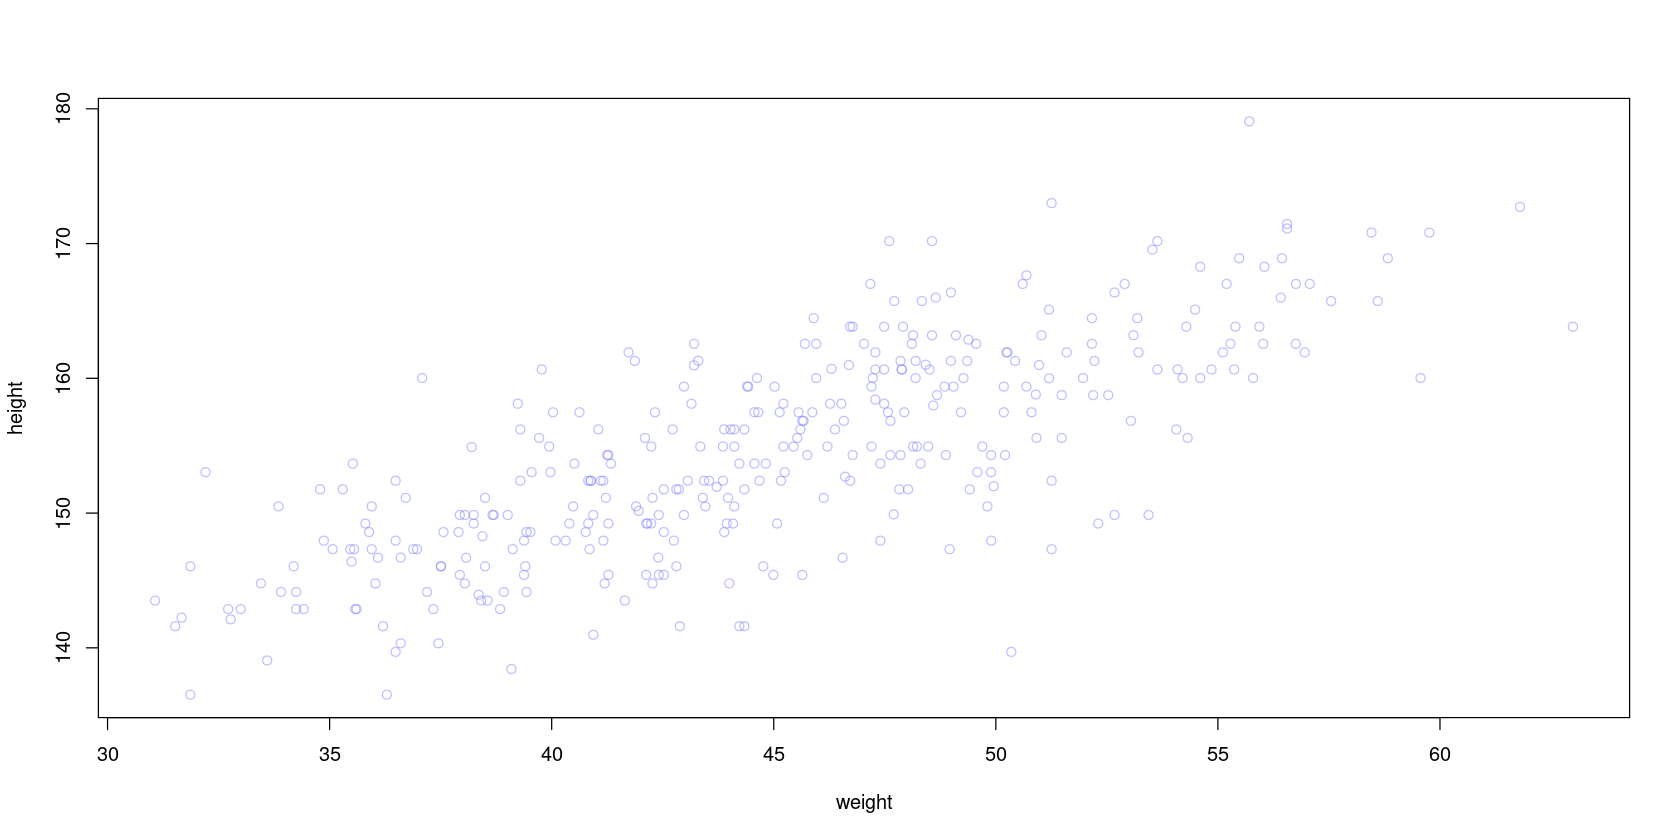

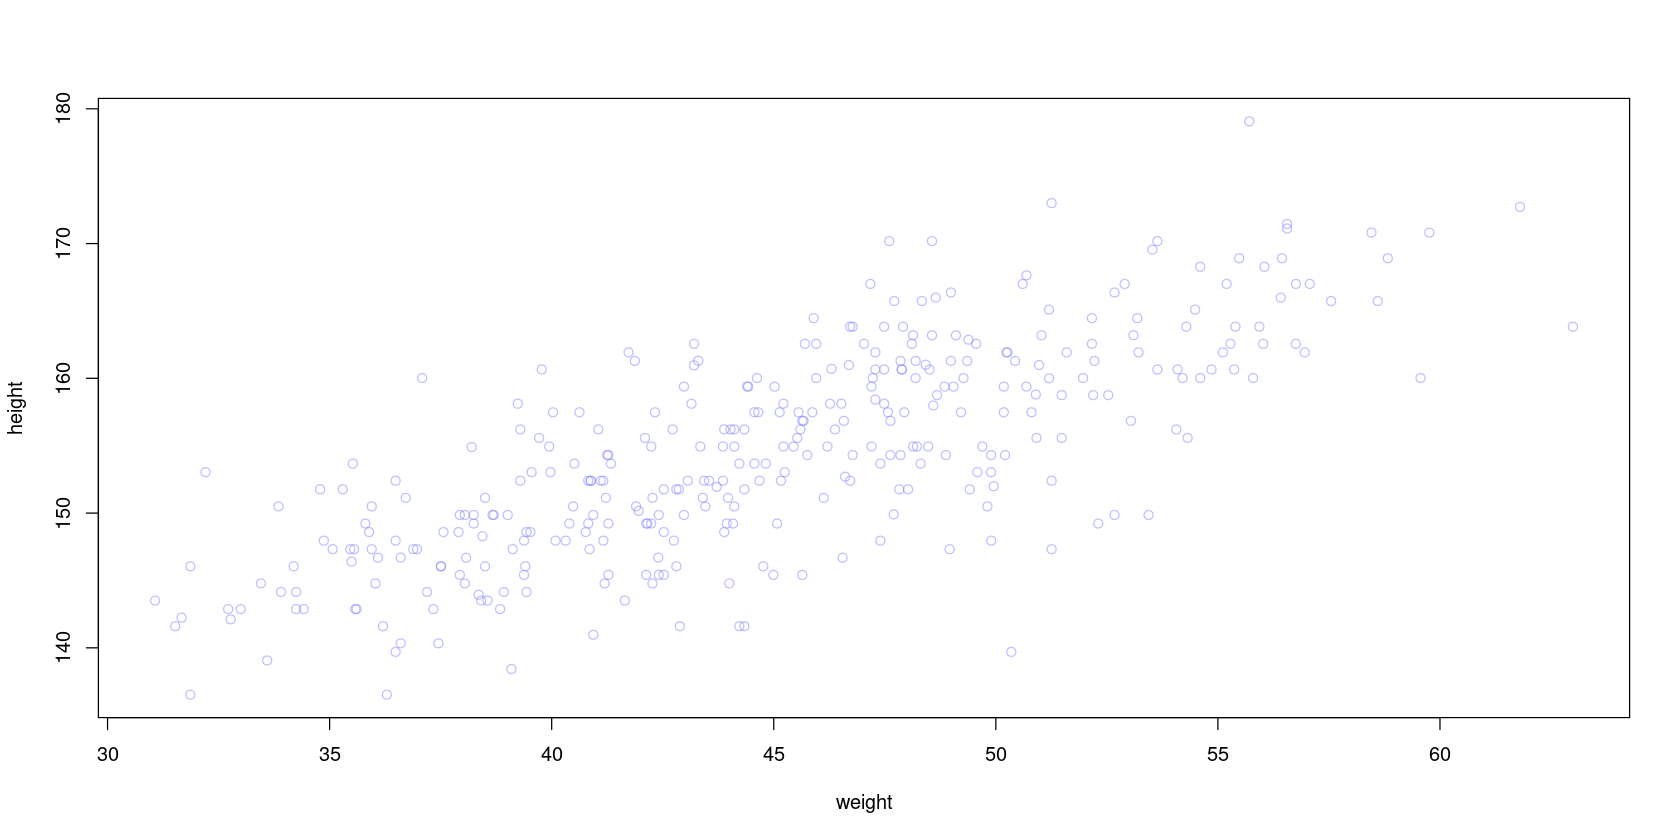

In [88]:
for (model in c(m4.3, m4m7)) {
    sim.heights <- sim(model, data=list(weight=weight.seq), n=1e4)
    heights.PI <- apply(sim.heights, 2, PI, prob=0.89)

    plot(height ~ weight, d2, col=col.alpha(rangi2, 0.5))
    lines(weight.seq, mu.mean)
    shade(mu.PI, weight.seq)
    shade(heights.PI, weight.seq)
}

These predictions look to be the same!

*4M8* In the chapter, we used 15 knots with the cherry blossom spline. INcrease the number of knots and observe what happens to the resulting spline. Then adjust also the width of the prior on the weights - change the standard deviation of the prior and watch what happens. What do you think the comination of know k=number and the prior on the weights controls?

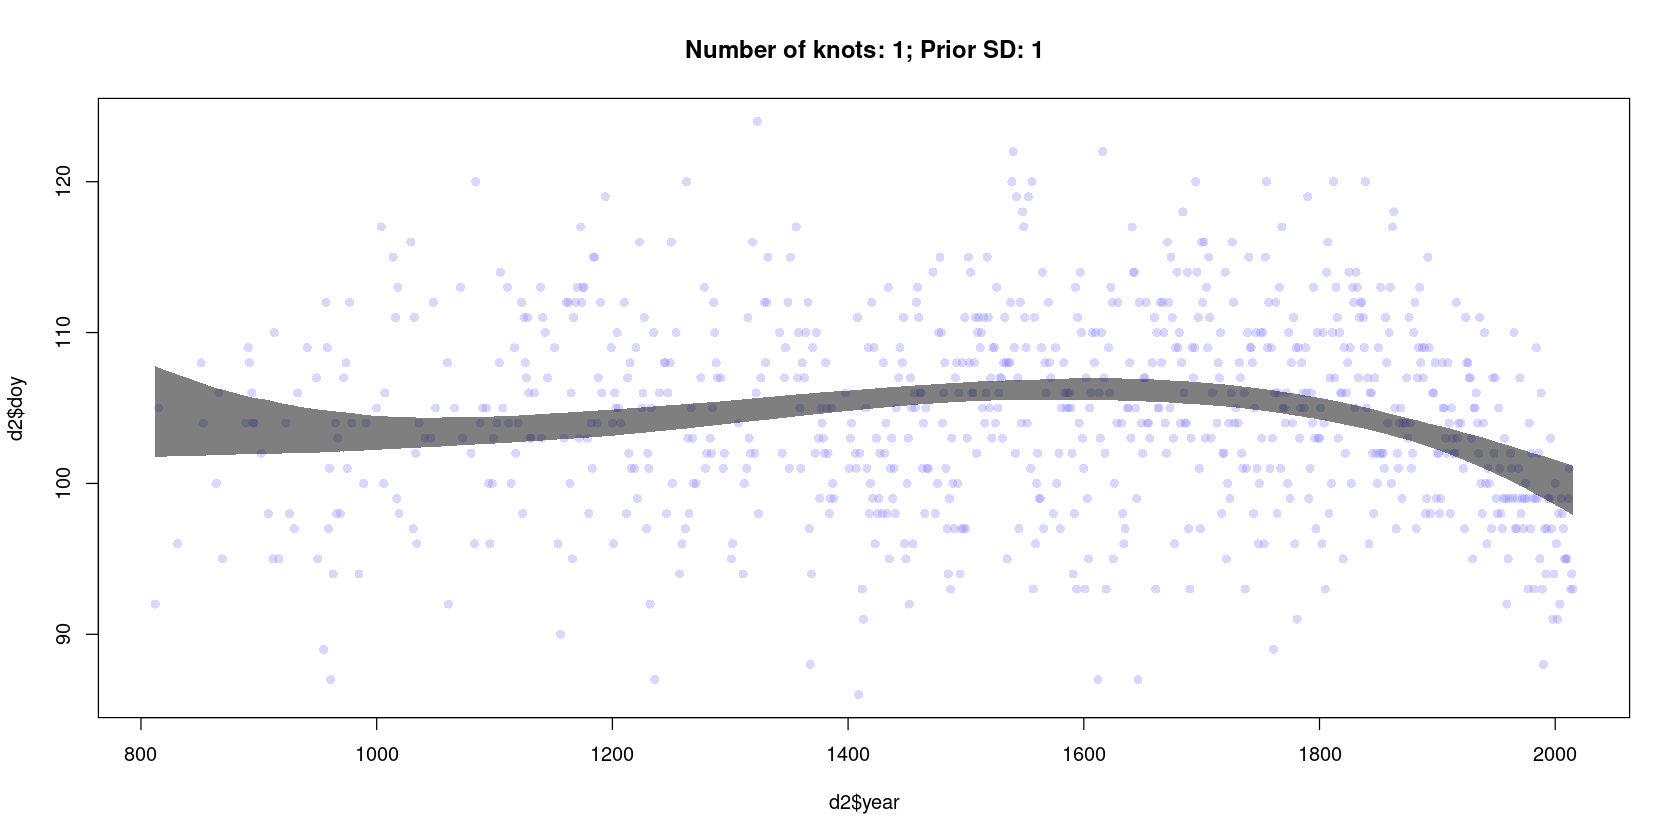

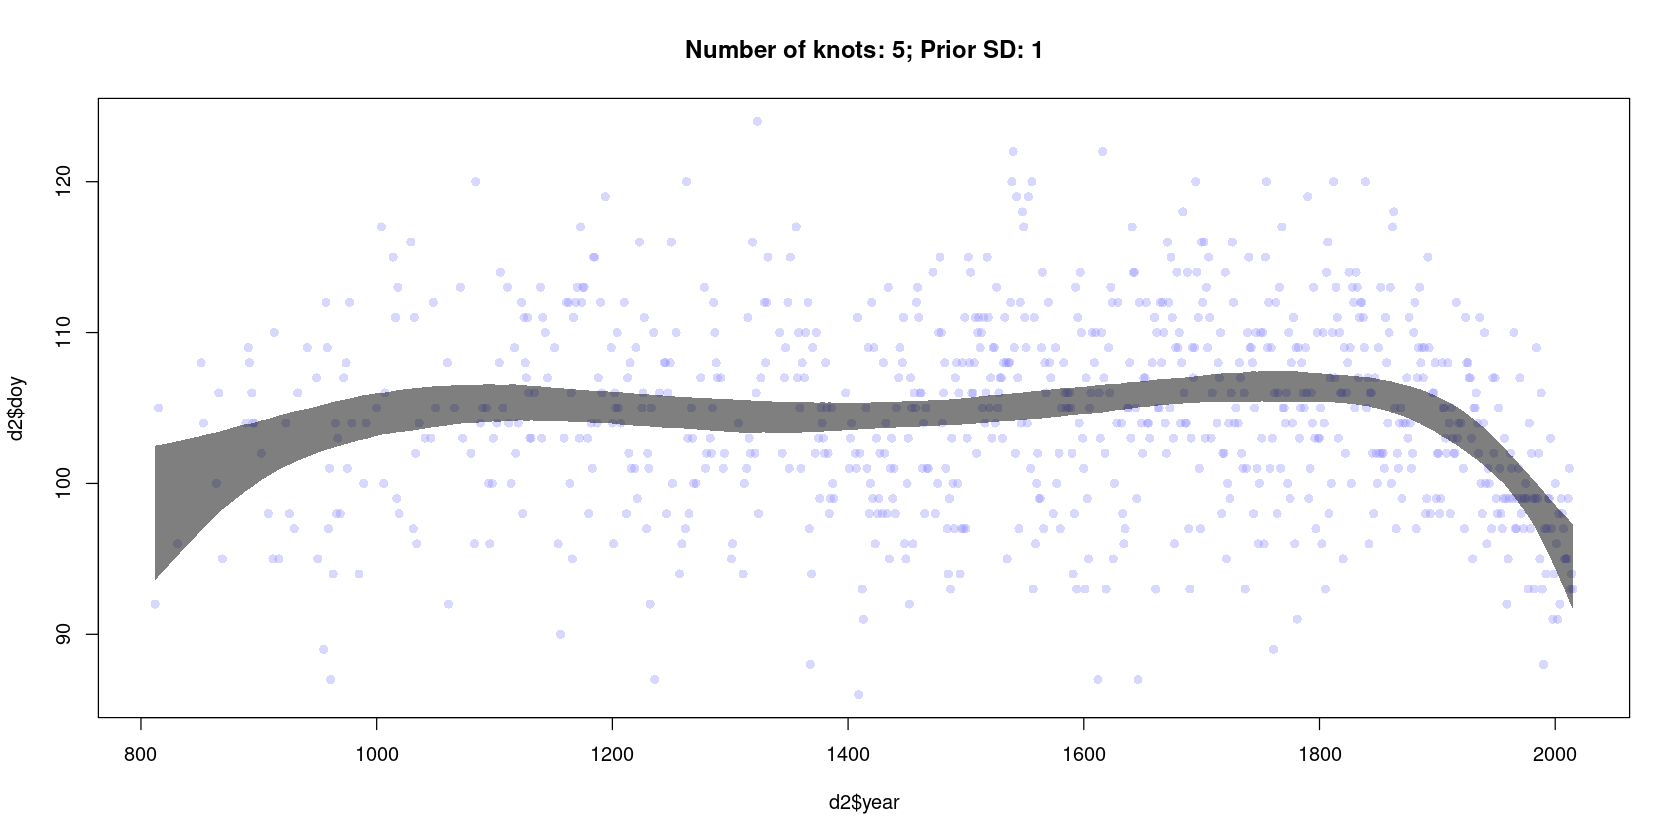

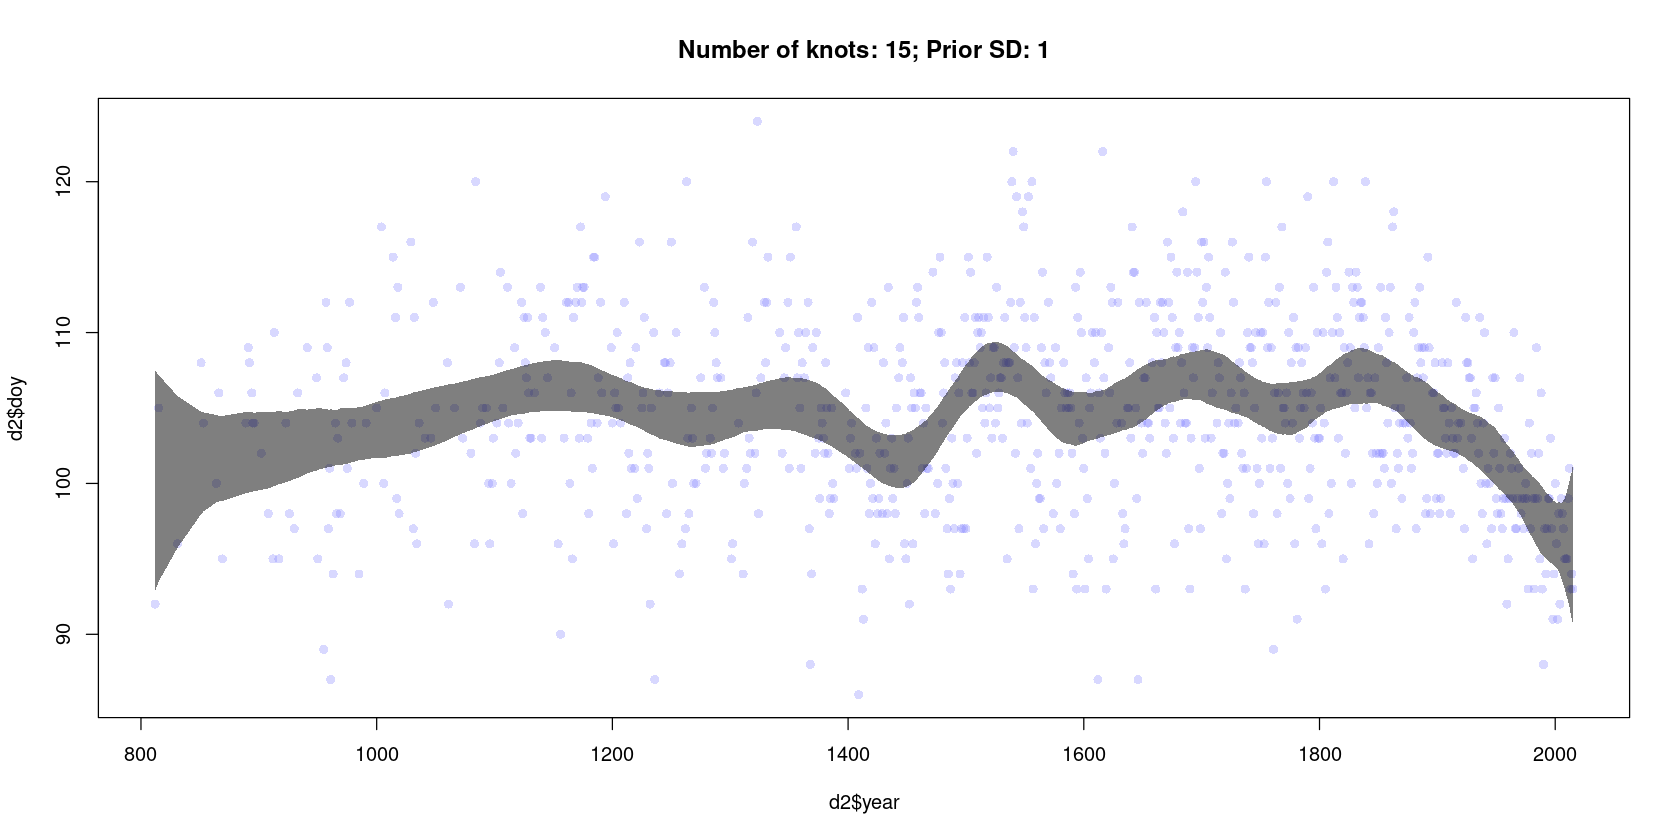

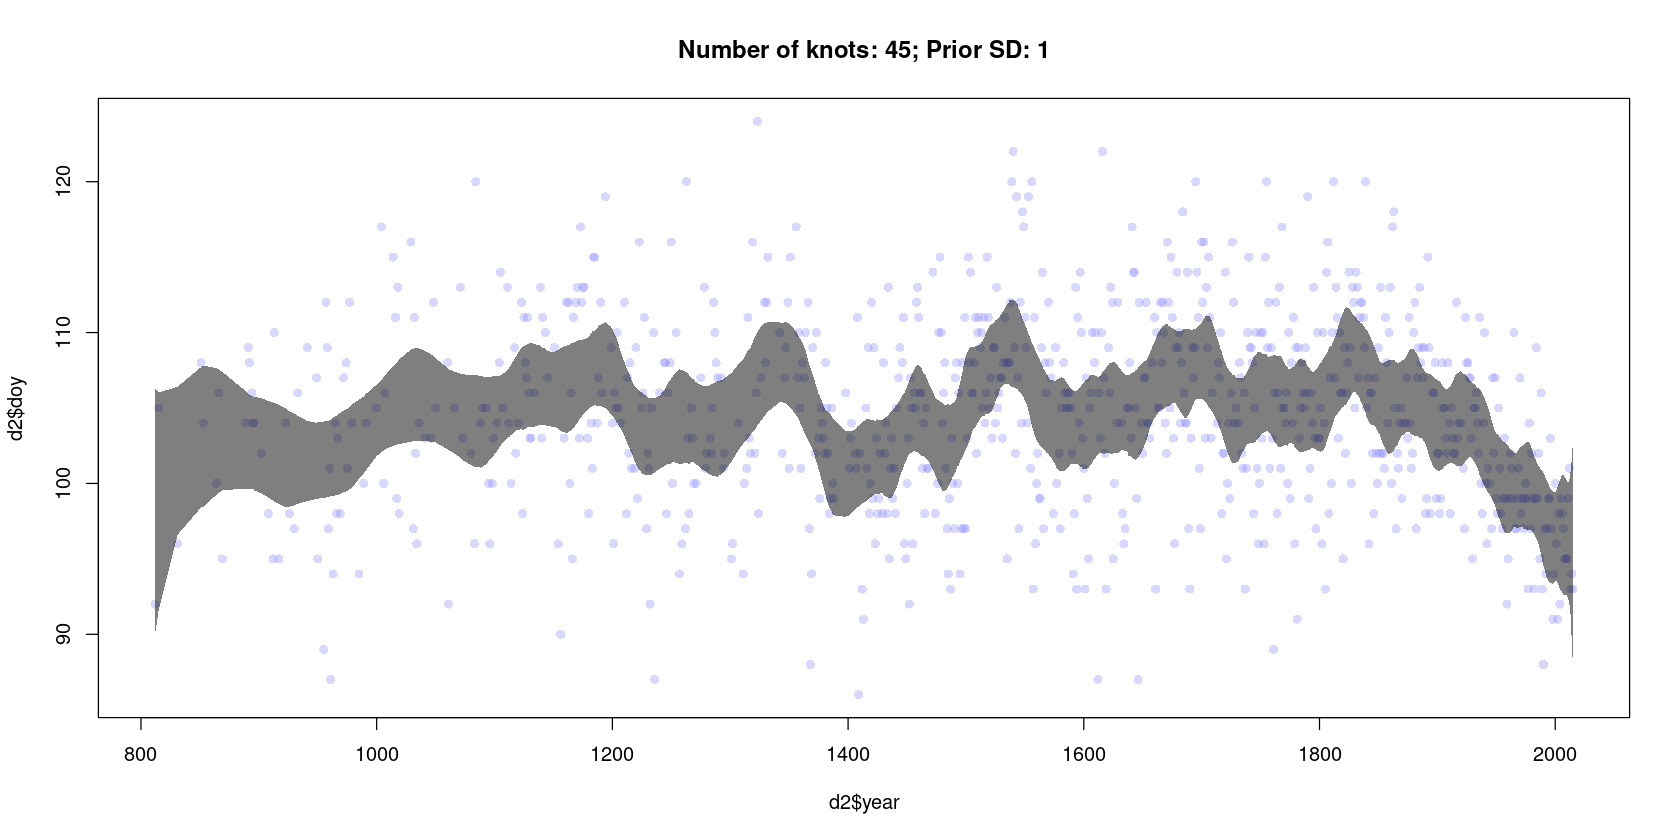

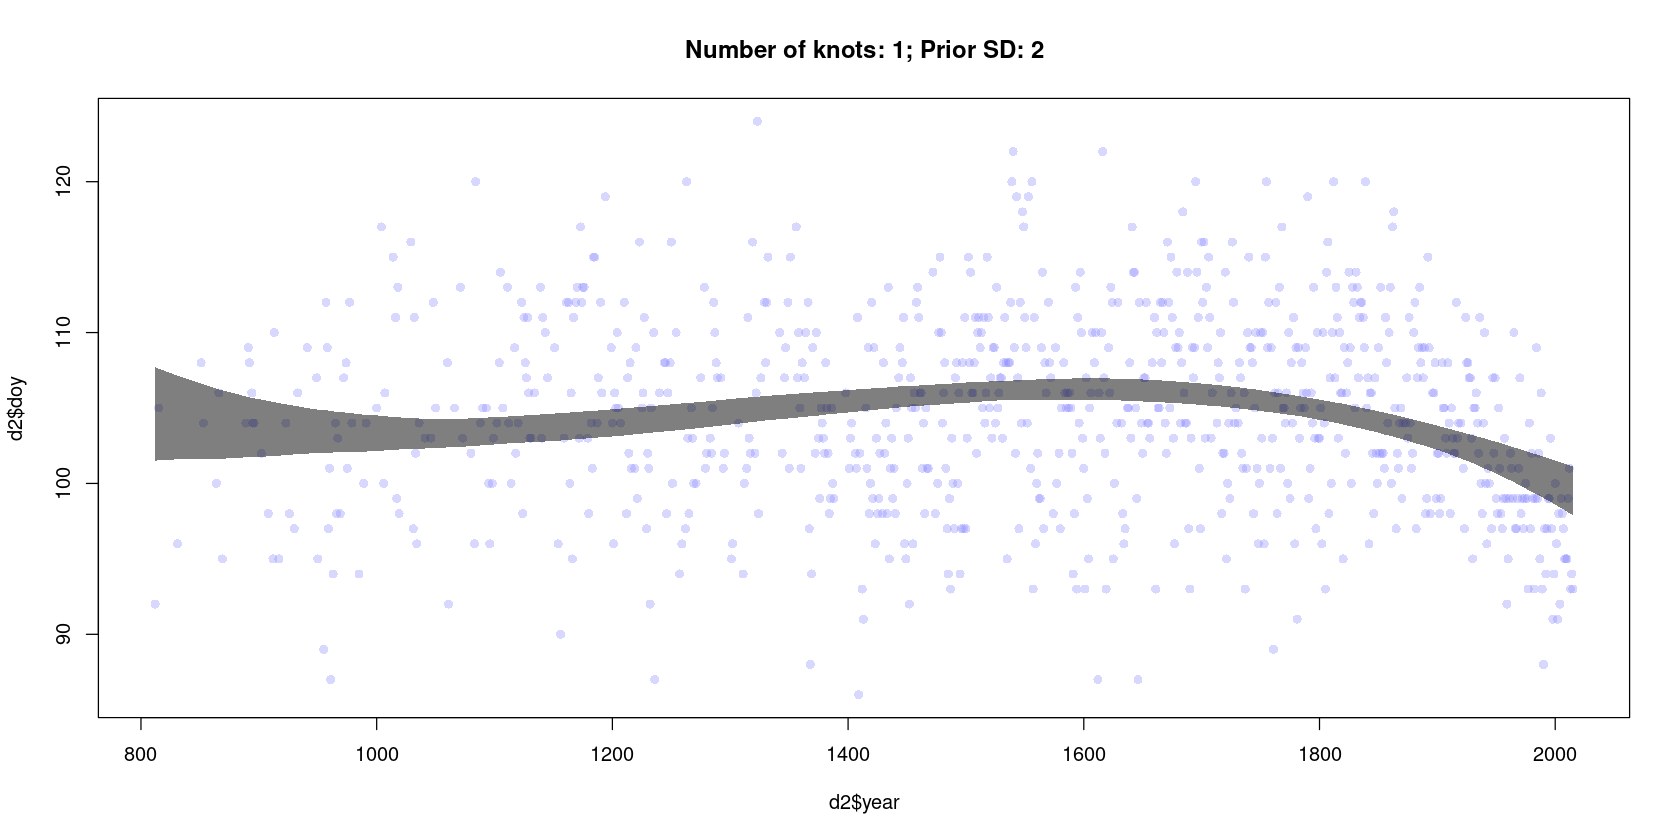

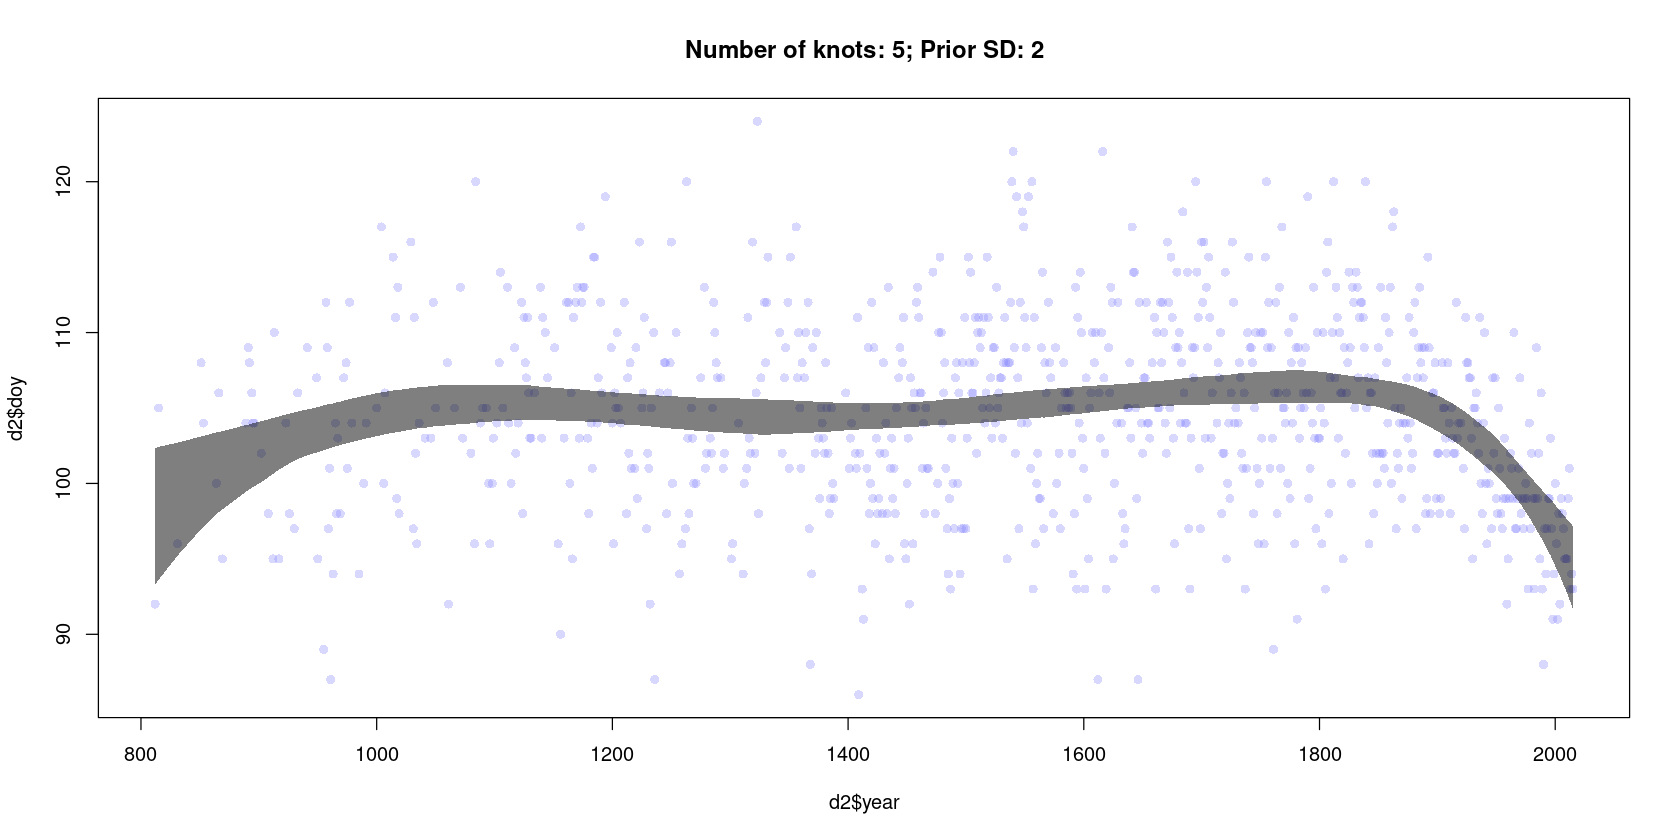

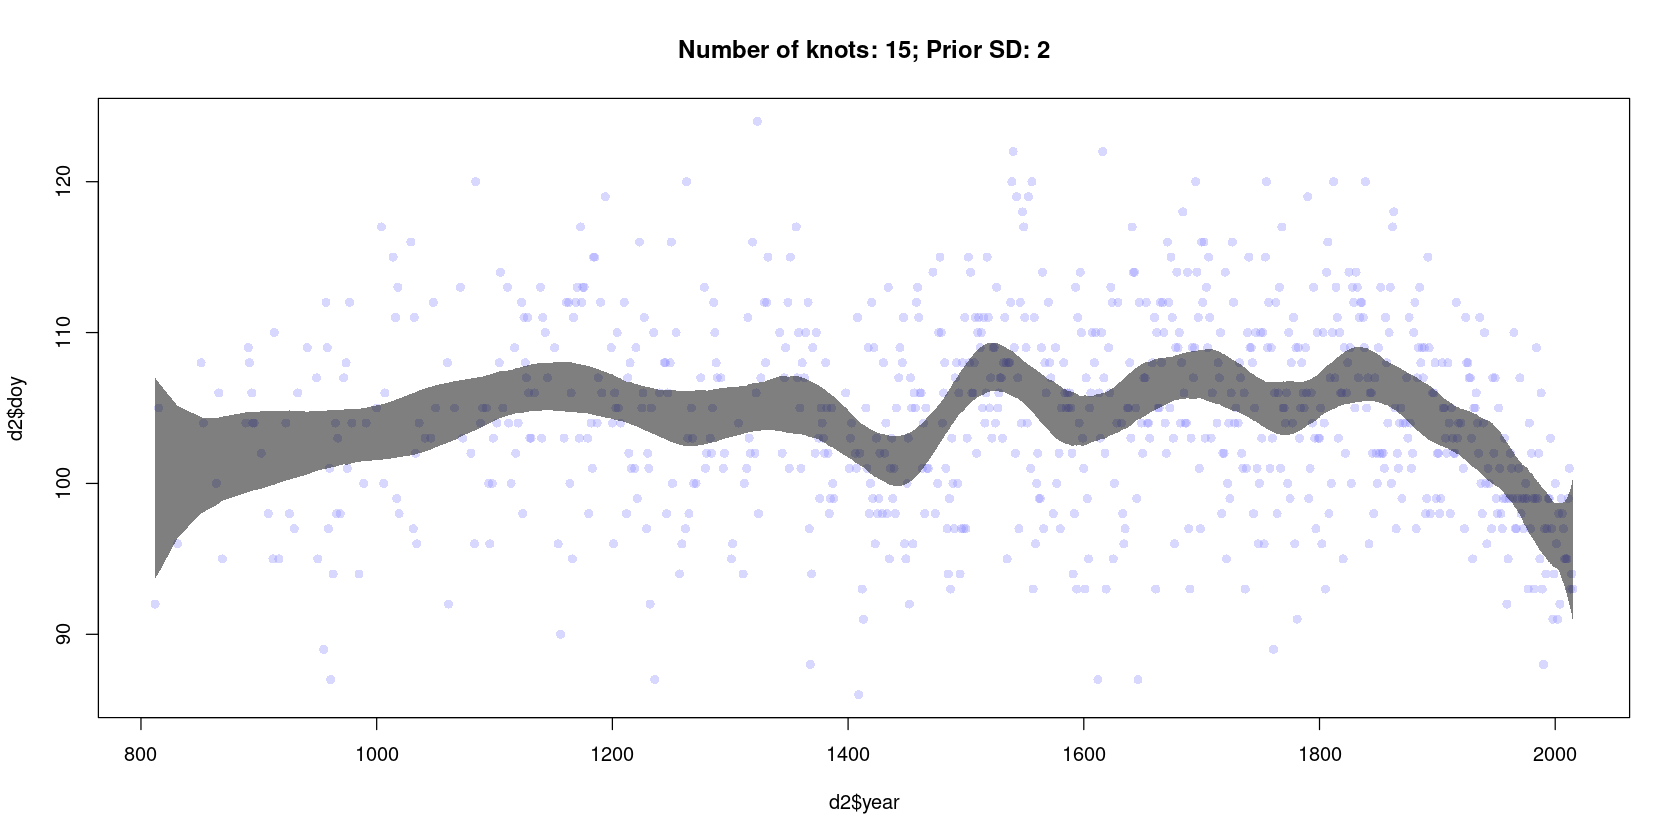

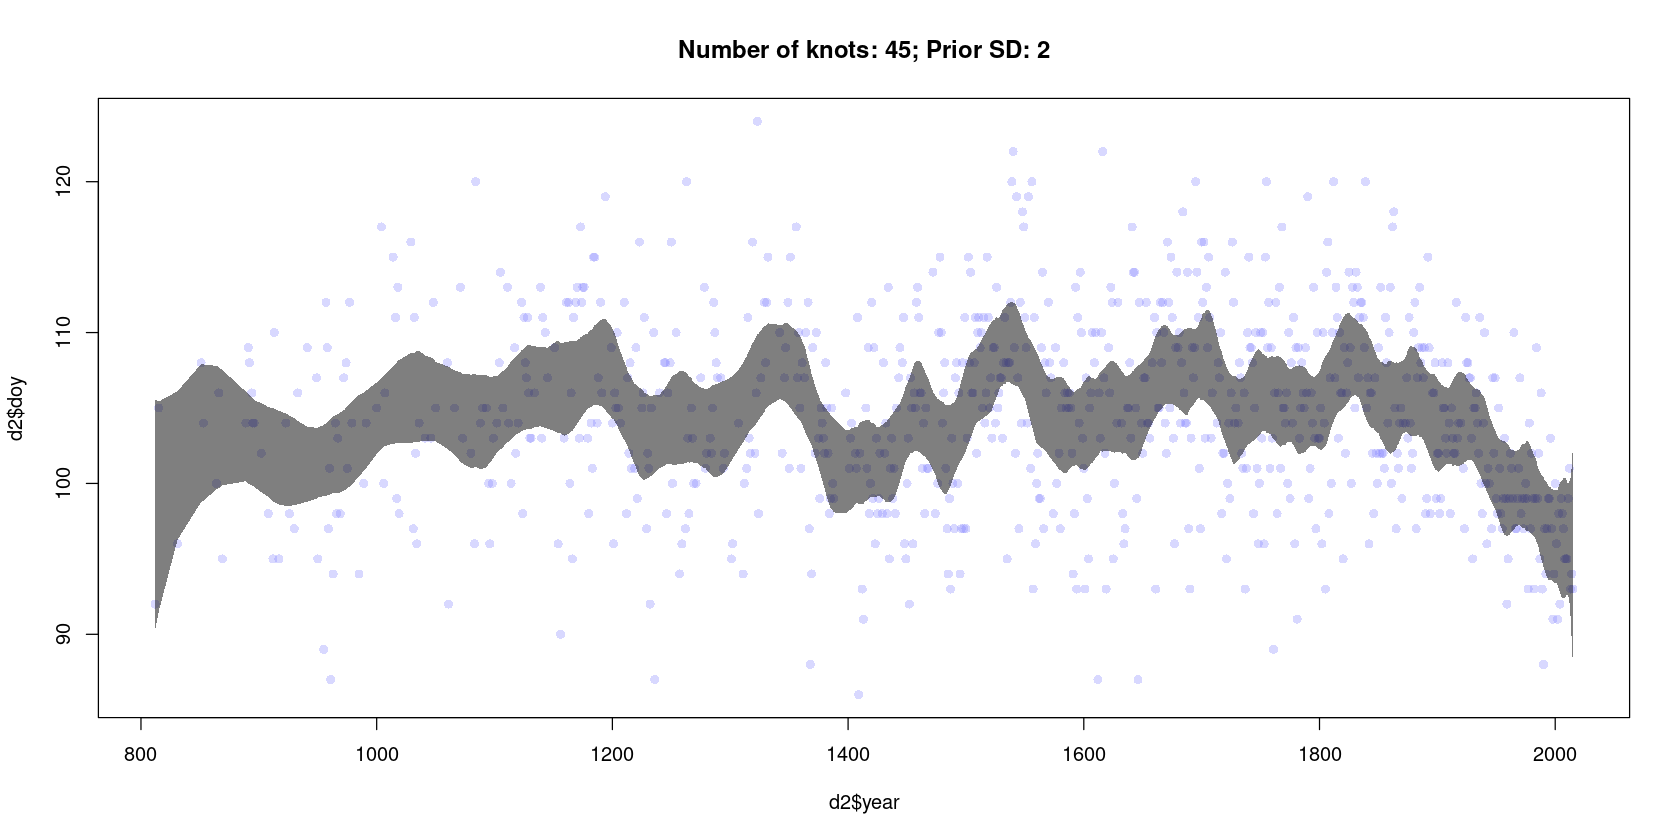

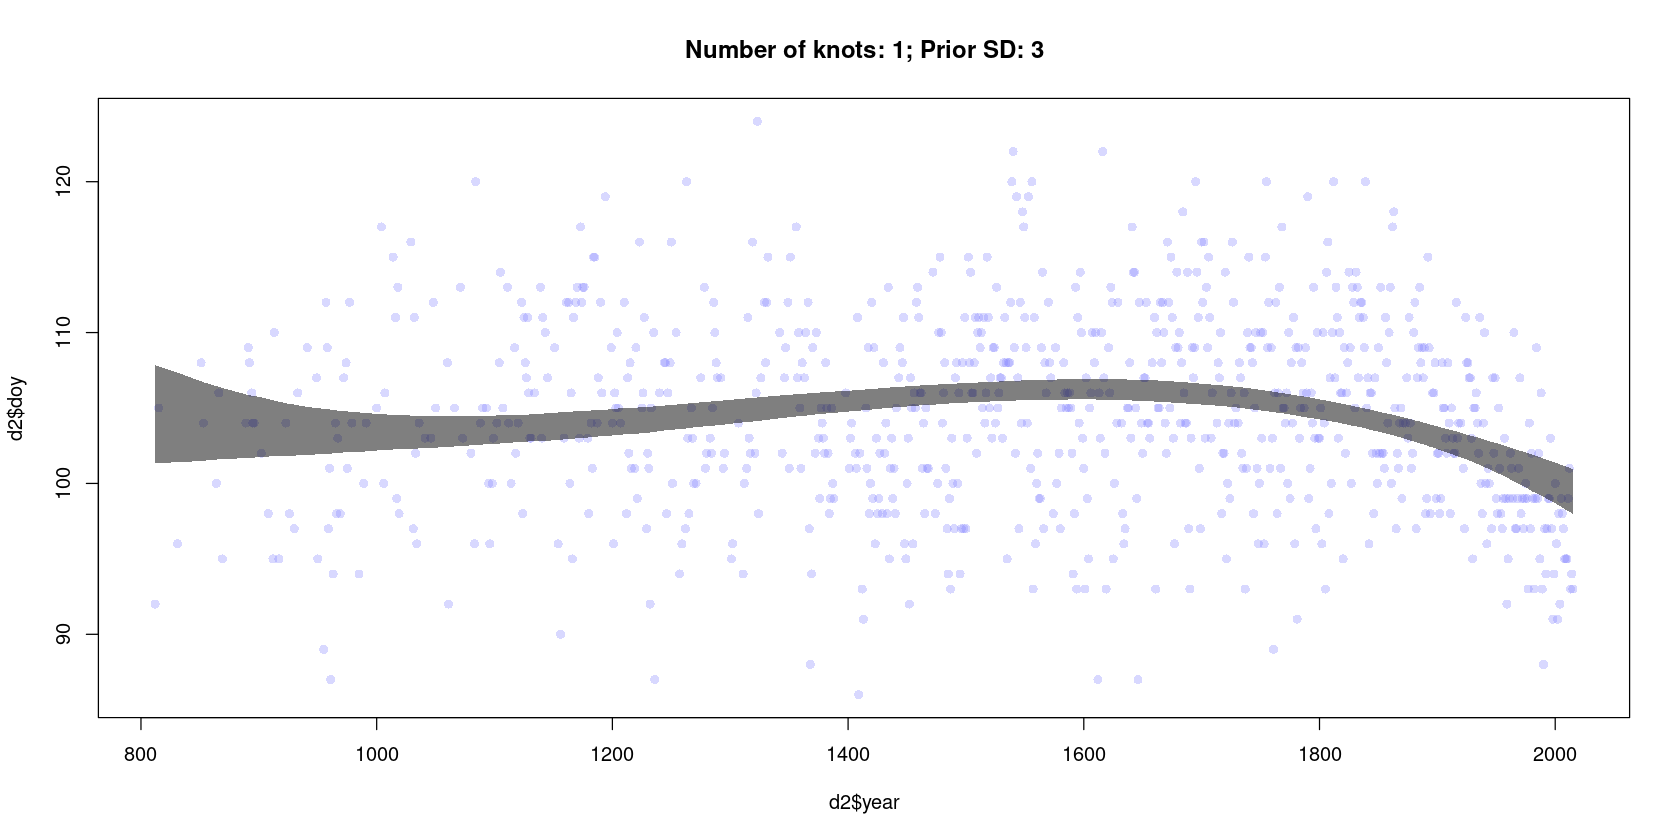

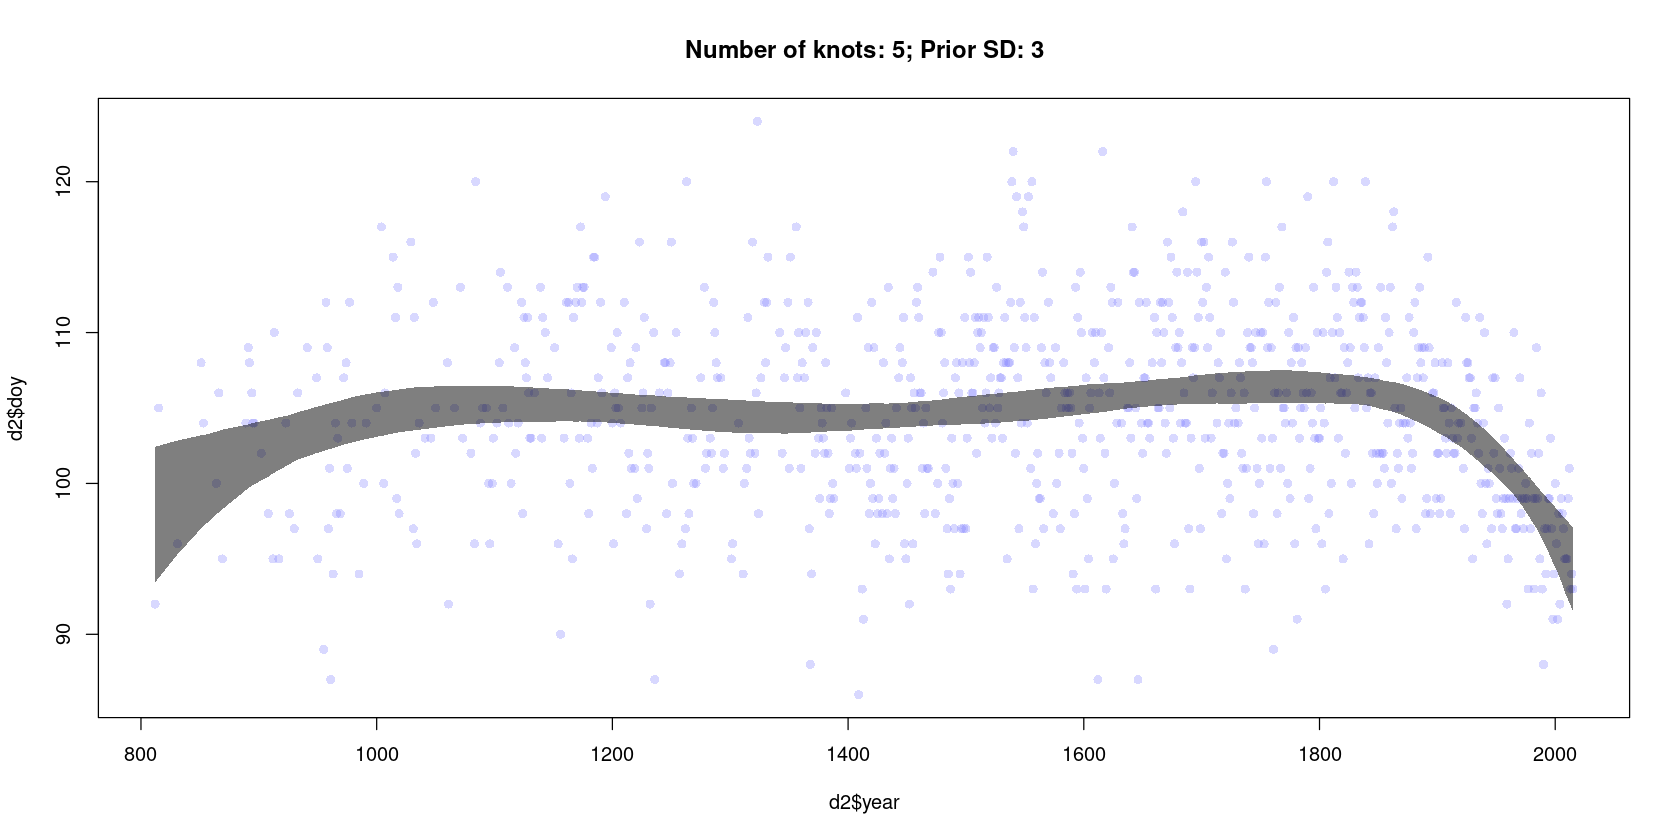

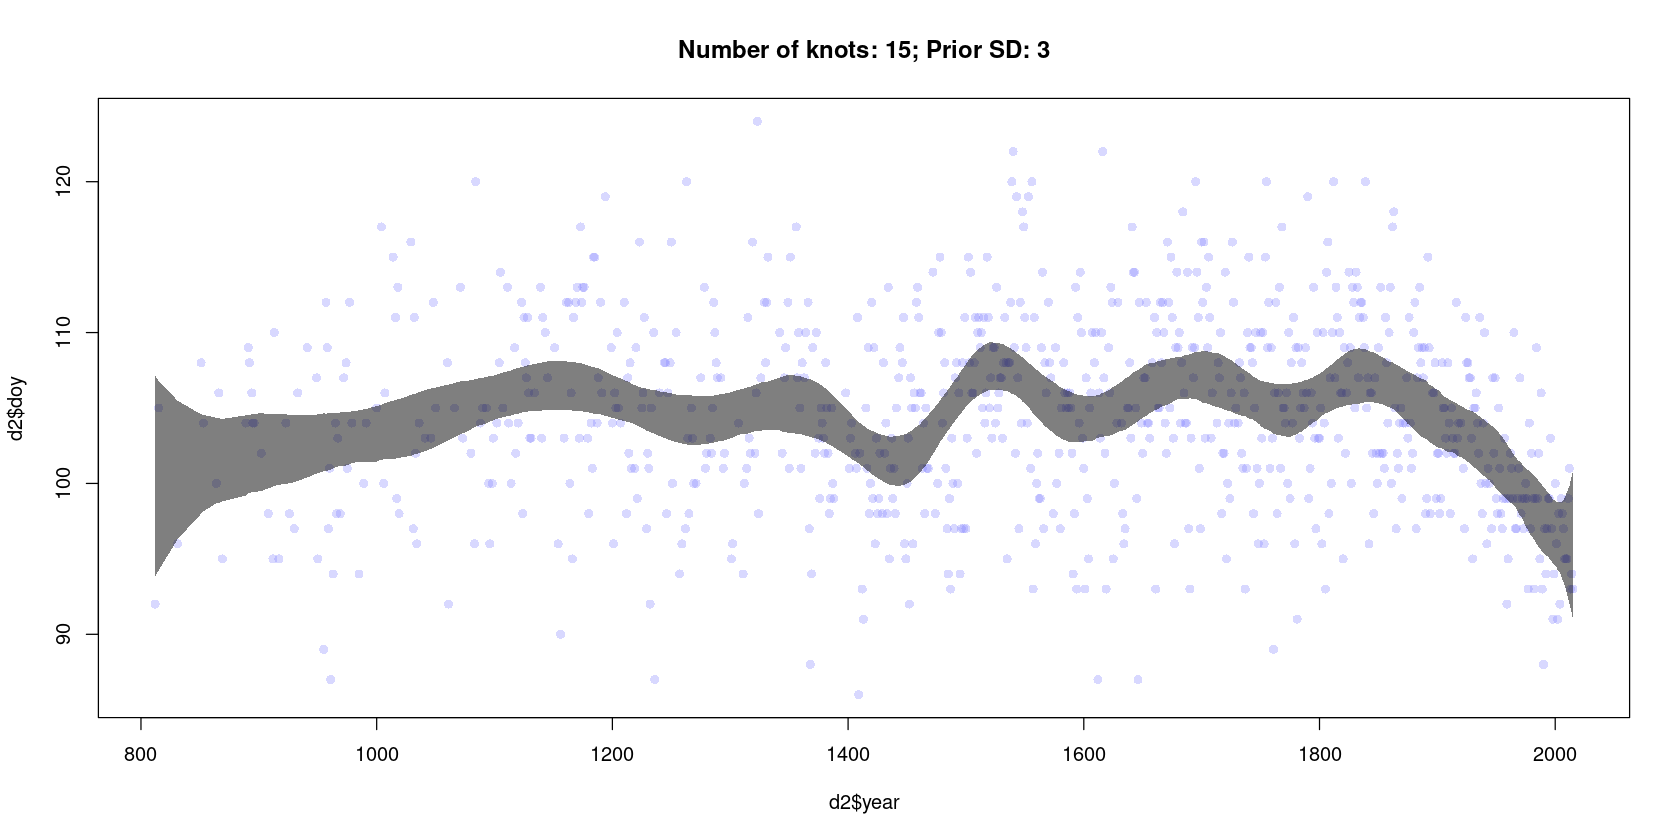

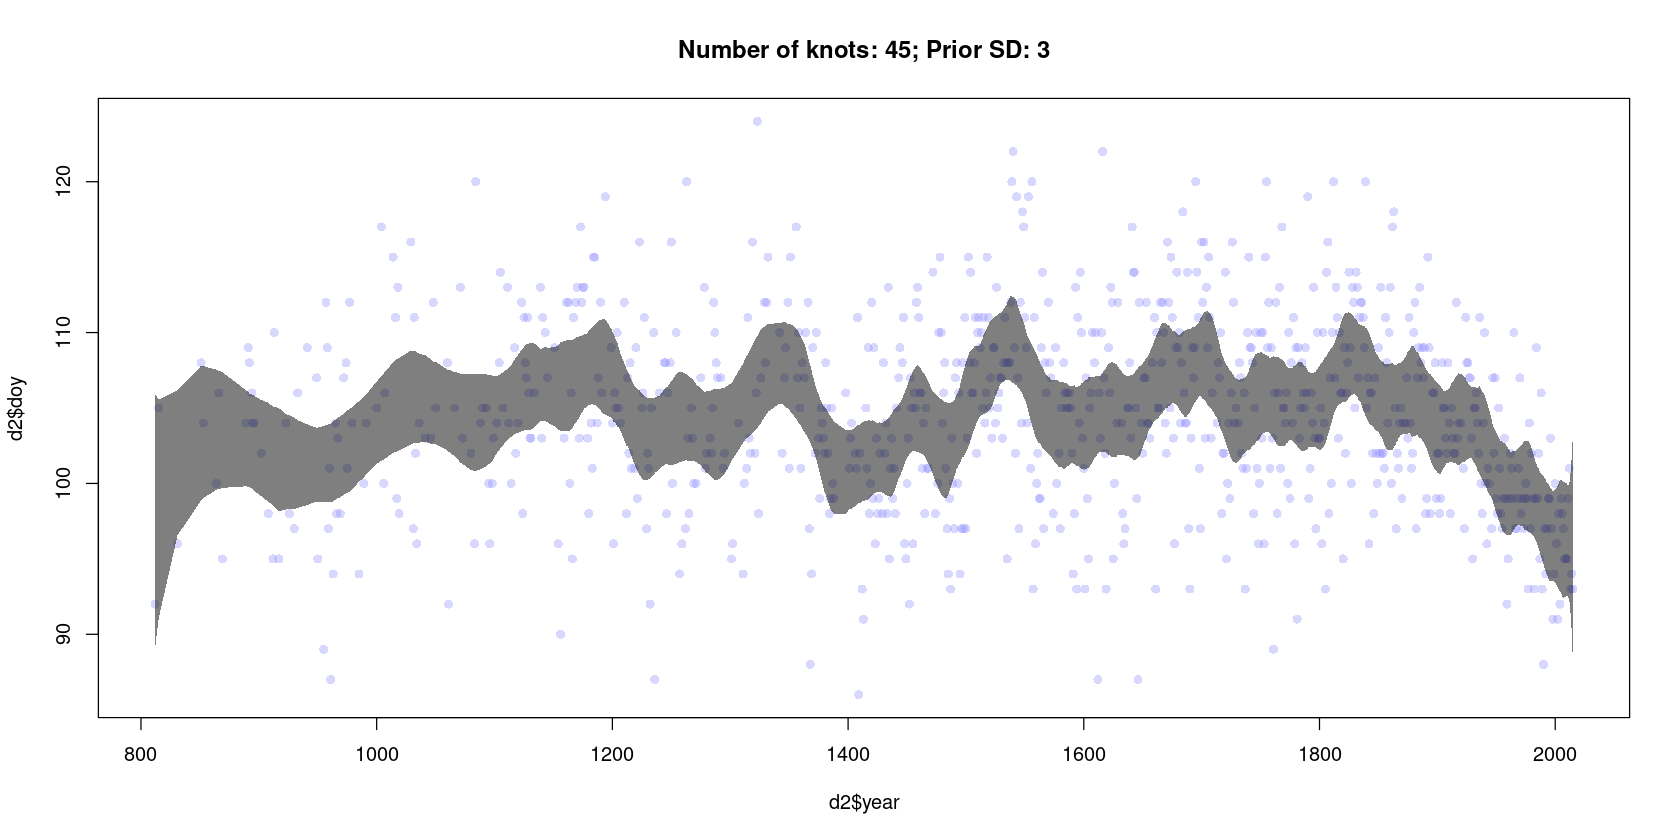

In [99]:
d <- cherry_blossoms
d2 <- d[complete.cases(d$doy),]
for (deviation in c(1, 2, 3)) {
    for (num_knots in c(1, 5, 15, 45)) {
        knot_list <- quantile(d2$year, probs=seq(0,1,length.out=num_knots))
        B <- bs(d2$year,
               knots=knot_list[-c(1,num_knots)],
                degree=3,
                intercept=TRUE
           )
        m4m8 <- quap(
            alist(
                D ~ dnorm(mu, sigma),
                mu <- a + B %*% w,
                a ~ dnorm(100, 10),
                w ~ dnorm(0, 10),
                sigma ~ dexp(deviation)
            ),
            data=list(D=d2$doy, B=B),
            start=list(w=rep(0,ncol(B))),
        )
        post <- extract.samples(m4m8)
        w <- apply(post$w, 2, mean)
        mu <- link(m4m8)
        mu_PI <- apply(mu, 2, PI, 0.97)
        plot(d2$year, d2$doy, col=col.alpha(rangi2, 0.3), pch=16, main=concat("Number of knots: ", num_knots, "; Prior SD: ", deviation))
        shade(mu_PI, d2$year, col=col.alpha("black", 0.5))
    }
}


So, changing the number of knots seems to affect the wiggliness of the result, although the prior SD doesn't seem to have that much of an effect.

*4H1* The weights listed below are recorded in the !Kung census, but heights are not recorded for the individuals. Provide predicted heights and 89% intervals for each of these individuals. That is, fill in the table below, using model-based predictions.

|Individual | Weight | Expected height | 89% interval |
| --- | --- | --- | --- |
| 1 | 46.95 |
| 2 | 43.72 |
| 3 | 64.78 |
| 4 | 32.59 |
| 5 | 54.63 |

In [108]:
num_samples <- 1e4
post <- extract.samples(m4.3)
for (weight in c(46.95, 43.72, 64.78, 32.59, 54.63)) {
    mus <- post$a + post$b * (weight - xbar)
    heights <- rnorm(num_samples, mus, post$sigma)
    print(concat("Weight: ", weight, "; expected height: ", mean(heights)))
    print(PI(heights, prob=0.89))
}

[1] "Weight: 46.95; expected height: 156.317665010796"
      5%      94% 
148.0900 164.5259 
[1] "Weight: 43.72; expected height: 153.49619798218"
      5%      94% 
145.6186 161.7106 
[1] "Weight: 64.78; expected height: 172.395778278508"
      5%      94% 
163.9979 180.7353 
[1] "Weight: 32.59; expected height: 143.379062712885"
      5%      94% 
135.1722 151.5093 
[1] "Weight: 54.63; expected height: 163.323431308543"
      5%      94% 
155.1950 171.4784 


*4H2* Select out all of the rows in the `Howell1` data with ages below 18. If you do it right, you should end up with a new data frame with 192 rows in it
a) Fit a linear regression to these data, using `quap`. Present and interpret the estimates. For every 10 units of increase in weight, how much taller does the model predict the child gets?
b) Plot the raw data, with height on the vertical axis and weight on the horizontal axis. Superimpose the MAP regression line and 89% interval for the mean. Also superimpose the 89% interval for the predicted heights.
c) What aspects of the model concern you? Describe the kinds of assumptions you would change, if any, to improve the mode. You don't have to write any new code. Just explain what the model appears to be doing a bad job of, and what you hypothesize would be a better model.

In [113]:
# a)
d <- Howell1
d4h2 <- d[d$age < 18,]
head(d4h2)

,height,weight,age,male
,<dbl>,<dbl>,<dbl>,<int>
19,121.92,19.61785,12.0,1
20,105.41,13.94795,8.0,0
21,86.36,10.48931,6.5,0
24,129.54,23.58678,13.0,1
25,109.22,15.98912,7.0,0
29,137.16,27.32892,17.0,1


In [114]:
nrow(d4h2)

[1] 192

In [132]:
wbar <- mean(d4h2$weight)
model <- quap(
    alist(
        height ~ dnorm(mu, sigma),
        mu <- a + b * weight,
        a ~ dnorm(100, 20),
        b ~ dlnorm(0, 1),
        sigma ~ dexp(1)
    ),
    data=d4h2
)

In [133]:
precis(model)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,58.485593,1.36557687,56.303137,60.668048
b,2.708246,0.06677885,2.601520,2.814971
sigma,8.261958,0.40870468,7.608768,8.915147


This indicates that for each 10 units increase in weight, we would expect to see a roughly 27cm increase in height.

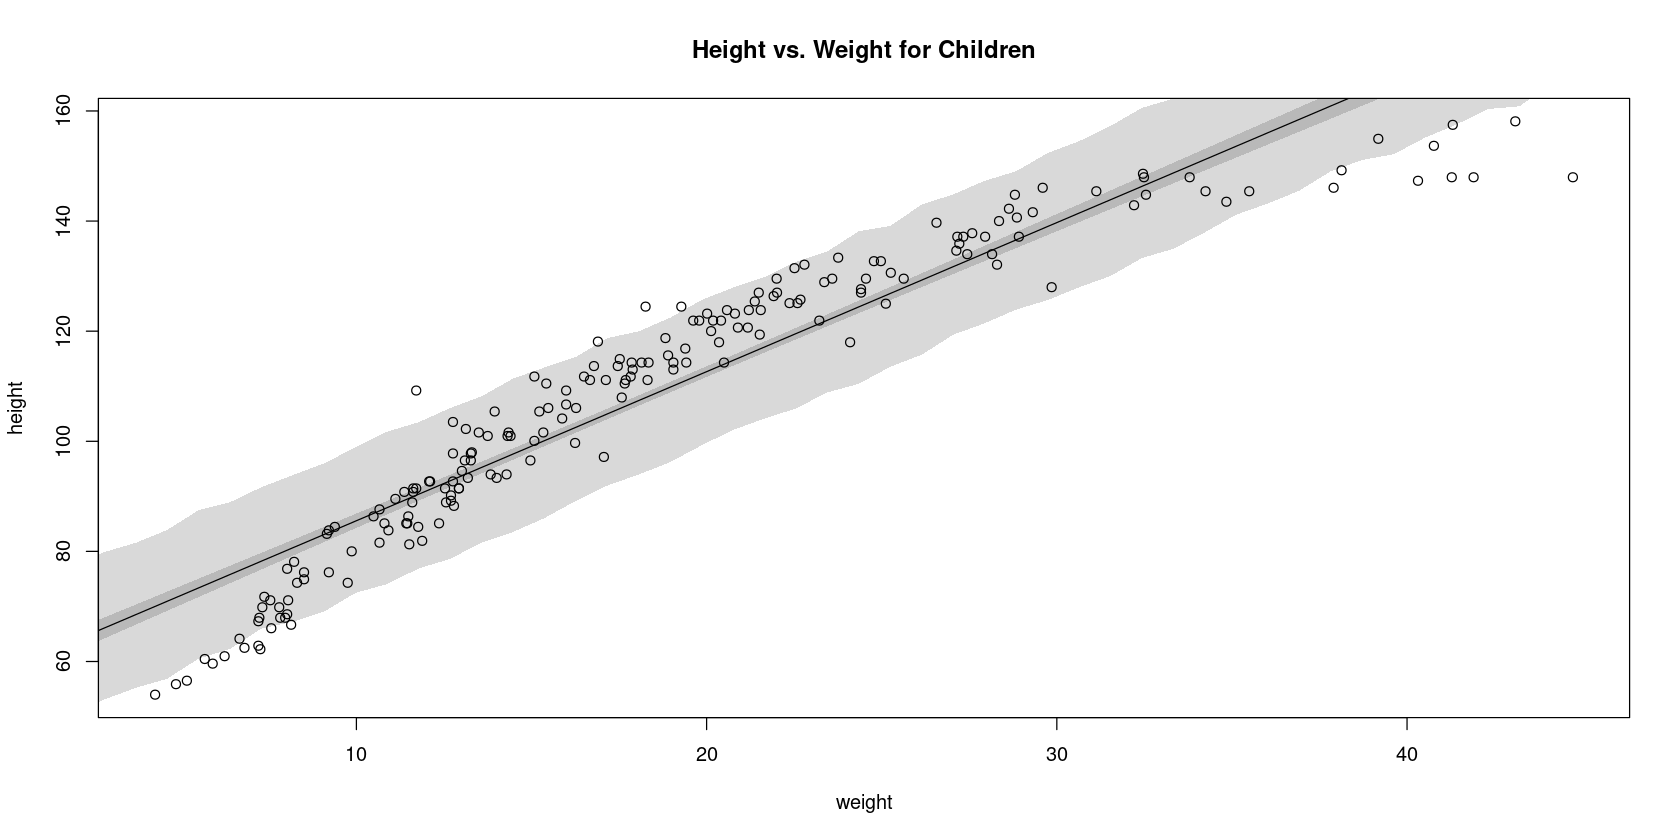

In [143]:
# b)
post <- extract.samples(model)
weight_seq <- seq(from=1, to=45, length.out=50)
mu <- sapply(weight_seq, function(weight) {
    mean(post$a + post$b * weight)
})

ci <- sapply(weight_seq, function(weight) {
    PI(post$a + post$b * weight, prob=0.89)
})

sim_heights <- sim(model, data=list(weight=weight_seq))
sim_heights_ci <- apply(sim_heights, 2, PI, prob=0.89)

plot(height ~ weight, data=d4h2, main="Height vs. Weight for Children")
lines(weight_seq, mu)
shade(ci, weight_seq)
shade(sim_heights_ci, weight_seq)

c) This model seems to do well in the middle~ of the interval, but systematically overestimates heights to the right (heavier children) and left (lighter children). There is definitely a curve to the data, so some sort of curved model (e.g. quadratic regression) might fit the data better.

*4H3* Suppose that a colleague of yours, who works on allometry, glances at the practice problem up above. Your colleague exclaims, "That's silly! Everyone knows that it's only the logarithm of body weight that scales with height!" let's take the colleague's advice and see what happens.
a) Model the relationship between height and the natural logarithm of weight. Use the entire `Howell1` data set - all 544 rows of adults and children. Can you interpret the resulting estimates?
b) Begin with this plot: `plot(height ~ weight, data=Howell1)`. Then use samples from the quadratic approcimate posterior of the model in a) to superimpose on the plot:
1. The predicted mean height as a function of weight;
1. The 97% interval for the mean;
1. The 97% interval for predicted heights

In [156]:
# a)
d <- Howell1
d4h3 <- d

model <- quap(
    alist(
        height ~ dnorm(mu, sigma),
        mu <- a + b * log(weight),
        a ~ dnorm(100, 10),
        b ~ dlnorm(0, 1),
        sigma ~ dexp(1)
    ),
    data=d4h3
)

In [166]:
precis(model)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,-21.611652,1.3273670,-23.733041,-19.490263
b,46.460955,0.3803681,45.853053,47.068856
sigma,5.123559,0.1550072,4.875828,5.371291


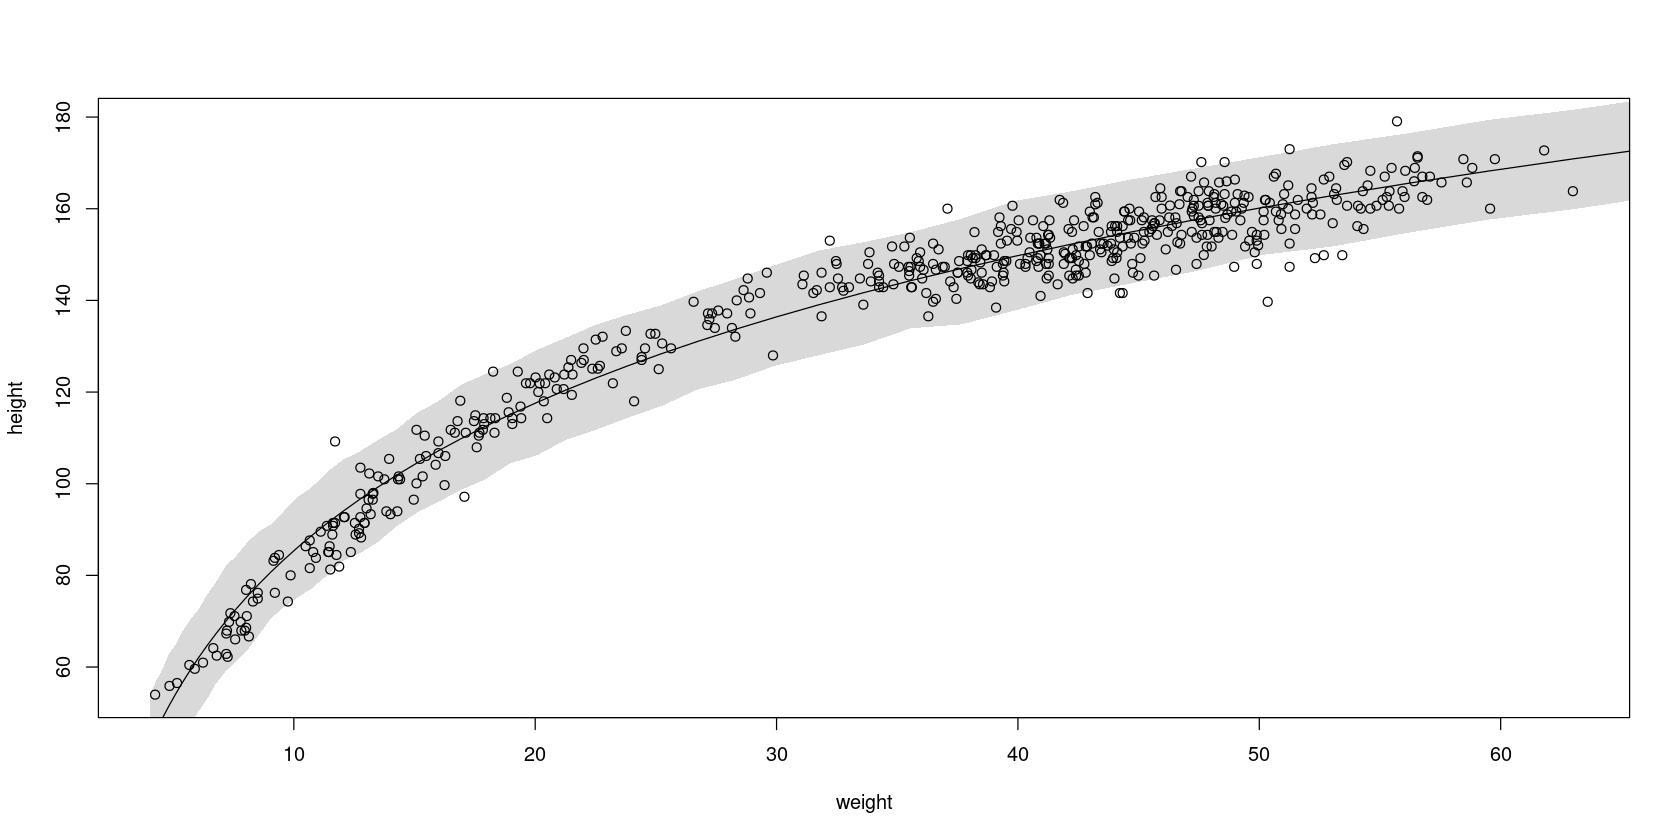

In [169]:
# b)
plot(height ~ weight, data=Howell1)

weight_seq <- seq(from=1.4, to=4.2, length.out=50)
post <- extract.samples(model)

mean_line <- sapply(weight_seq, function(weight) {
    mean(post$a + post$b * weight)
})

heights <- sapply(weight_seq, function(weight) {
    PI(
        rnorm(1000, post$a + post$b * weight, post$sigma),
        prob=0.97
    )
})

lines(exp(weight_seq), mean_line)
shade(heights, exp(weight_seq))